# DIAYN

In [8]:
import torch
import torch.nn as nn
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import numpy as np
from network_utils import np2torch

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_util import make_vec_env
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
NUM_SKILLS = 20

class SkillDist(nn.Module):
    def __init__(self, num_skills=NUM_SKILLS, skill_size=10):
        super(SkillDist, self).__init__()

        self.num_skills = num_skills
        self.skill_size = skill_size
        self.p = 1 / num_skills
        self.p_ = torch.tensor([self.p])
        self.dist = torch.distributions.Categorical(probs = torch.ones(num_skills) * self.p)
        self.embed = torch.nn.Embedding(self.num_skills, self.skill_size)
        self.embed.weight.requires_grad = False

    def sample(self):
        hello = self.dist.sample()
        return self.embed(hello), hello.detach().numpy()

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        nn.init.uniform_(self.fc1.weight, -0.01, 0.01)
        nn.init.uniform_(self.fc2.weight, -0.01, 0.01)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.softmax(x, dim=0)
        return x

class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: Env):
        super(CustomEnvWrapper, self).__init__(env)
        self.discriminator = Discriminator(input_size=env.observation_space.shape[0], hidden_size=128, output_size=NUM_SKILLS)
        self.optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)

        self.skill_dist = SkillDist()
        self.skill, self.skill_i = self.skill_dist.sample()

        low = self.observation_space.low
        high = self.observation_space.high
        for i in range(self.skill_dist.skill_size):
            low = np.append(low, -np.inf)
            high = np.append(high, np.inf)
        self.observation_space = Box(low, high, dtype=np.float32)

        self.rewards = []
        self.loss = []
    
    def reset(self, seed=137):
        state = self.env.reset(seed=seed)
        self.skill, self.skill_i = self.skill_dist.sample()
        new_state = np.append(state[0], self.skill.detach().numpy())
        return (new_state, state[1])

    def step(self, action):
        state, reward, done, info, _ = self.env.step(action)
        reward = self.custom_reward_function(action, state, reward)

        self.rewards.append(reward)

        state = np.append(state, self.skill.detach().numpy())

        # Change skill if new trajectory
        if done:
            self.skill, self.skill_i = self.skill_dist.sample()

        return state, reward, done, info, _
    
    def custom_reward_function(self, action, state, original_reward):
        a = torch.log(self.discriminator(np2torch(state)))[self.skill_i]
        b = torch.log(self.skill_dist.p_)

        r = a - b

        f = -a

        self.loss.append(a.item())

        self.optimizer.zero_grad()
        f.backward()
        self.optimizer.step()

        r_ = r.detach().numpy()

        return r_
    
    def cur_skill(self):
        return self.skill_i
    
    def set_skill(self, i):
        assert i < self.skill_dist.num_skills
        self.skill_i = i
        self.skill = self.skill_dist.embed(torch.tensor([i]))

In [3]:
# DIAYN on PPO
env = gym.make("HalfCheetah-v4")
env = CustomEnvWrapper(env)

model = PPO(
    "MlpPolicy",  # Use the Multi-Layer Perceptron (MLP) policy
    env,  # The environment
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.2,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,  # Set to 1 to enable verbose output
)
model.learn(total_timesteps=1000000, progress_bar=True)
model.save("diayn_ppo_cheetah_big3")

all_rewards = env.rewards
all_loss = env.loss
del model # remove to demonstrate saving and loading

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.75e+03 |
| time/              |          |
|    fps             | 1174     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.68e+03    |
| time/                   |             |
|    fps                  | 1016        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017702138 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.68       |
|    explained_variance   | -0.00147    |
|    learning_rate        | 0.0003      |
|    loss                 | 488         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0119     |
|    std                  | 1.05        |
|    value_loss           | 1.06e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.2e+03     |
| time/                   |             |
|    fps                  | 937         |
|    iterations           | 3           |
|    time_elapsed         | 6           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.015503966 |
|    clip_fraction        | 0.0915      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.91       |
|    explained_variance   | 0.0326      |
|    learning_rate        | 0.0003      |
|    loss                 | 359         |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0117     |
|    std                  | 1.09        |
|    value_loss           | 933         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.11e+03    |
| time/                   |             |
|    fps                  | 904         |
|    iterations           | 4           |
|    time_elapsed         | 9           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.027259292 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.22       |
|    explained_variance   | 0.404       |
|    learning_rate        | 0.0003      |
|    loss                 | 103         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.014      |
|    std                  | 1.16        |
|    value_loss           | 198         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.07e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 5           |
|    time_elapsed         | 11          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.010665046 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.51       |
|    explained_variance   | 0.33        |
|    learning_rate        | 0.0003      |
|    loss                 | 265         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00984    |
|    std                  | 1.2         |
|    value_loss           | 708         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 957         |
| time/                   |             |
|    fps                  | 842         |
|    iterations           | 6           |
|    time_elapsed         | 14          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.017423414 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.73       |
|    explained_variance   | 0.562       |
|    learning_rate        | 0.0003      |
|    loss                 | 134         |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0119     |
|    std                  | 1.25        |
|    value_loss           | 311         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 949         |
| time/                   |             |
|    fps                  | 847         |
|    iterations           | 7           |
|    time_elapsed         | 16          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.011308536 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.97       |
|    explained_variance   | 0.346       |
|    learning_rate        | 0.0003      |
|    loss                 | 175         |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0102     |
|    std                  | 1.3         |
|    value_loss           | 412         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 894         |
| time/                   |             |
|    fps                  | 827         |
|    iterations           | 8           |
|    time_elapsed         | 19          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.029424476 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.3       |
|    explained_variance   | -0.00294    |
|    learning_rate        | 0.0003      |
|    loss                 | 190         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.012      |
|    std                  | 1.39        |
|    value_loss           | 575         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 808        |
| time/                   |            |
|    fps                  | 833        |
|    iterations           | 9          |
|    time_elapsed         | 22         |
|    total_timesteps      | 18432      |
| train/                  |            |
|    approx_kl            | 0.02409914 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.7      |
|    explained_variance   | 0.647      |
|    learning_rate        | 0.0003     |
|    loss                 | 130        |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.0163    |
|    std                  | 1.48       |
|    value_loss           | 418        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 914         |
| time/                   |             |
|    fps                  | 854         |
|    iterations           | 10          |
|    time_elapsed         | 23          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.015092107 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11         |
|    explained_variance   | 0.0258      |
|    learning_rate        | 0.0003      |
|    loss                 | 71.4        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0122     |
|    std                  | 1.53        |
|    value_loss           | 188         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 850         |
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 11          |
|    time_elapsed         | 25          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.009743782 |
|    clip_fraction        | 0.0432      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | 0.5         |
|    learning_rate        | 0.0003      |
|    loss                 | 245         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00937    |
|    std                  | 1.58        |
|    value_loss           | 640         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 944         |
| time/                   |             |
|    fps                  | 894         |
|    iterations           | 12          |
|    time_elapsed         | 27          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.017978698 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 196         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0102     |
|    std                  | 1.66        |
|    value_loss           | 415         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 783          |
| time/                   |              |
|    fps                  | 892          |
|    iterations           | 13           |
|    time_elapsed         | 29           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0063763056 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.6        |
|    explained_variance   | 0.415        |
|    learning_rate        | 0.0003       |
|    loss                 | 236          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00612     |
|    std                  | 1.7          |
|    value_loss           | 838          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 832        |
| time/                   |            |
|    fps                  | 898        |
|    iterations           | 14         |
|    time_elapsed         | 31         |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.02153448 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.9      |
|    explained_variance   | 0.426      |
|    learning_rate        | 0.0003     |
|    loss                 | 104        |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0122    |
|    std                  | 1.8        |
|    value_loss           | 289        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 757          |
| time/                   |              |
|    fps                  | 907          |
|    iterations           | 15           |
|    time_elapsed         | 33           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0071635274 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.1        |
|    explained_variance   | 0.66         |
|    learning_rate        | 0.0003       |
|    loss                 | 205          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00692     |
|    std                  | 1.84         |
|    value_loss           | 459          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 712         |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 16          |
|    time_elapsed         | 35          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.039600983 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.4       |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 92          |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00718    |
|    std                  | 1.99        |
|    value_loss           | 241         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 720         |
| time/                   |             |
|    fps                  | 919         |
|    iterations           | 17          |
|    time_elapsed         | 37          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.008763178 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.7       |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.0003      |
|    loss                 | 222         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00601    |
|    std                  | 2.06        |
|    value_loss           | 631         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 787         |
| time/                   |             |
|    fps                  | 928         |
|    iterations           | 18          |
|    time_elapsed         | 39          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.041583203 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.1       |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 131         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0129     |
|    std                  | 2.24        |
|    value_loss           | 435         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 800         |
| time/                   |             |
|    fps                  | 937         |
|    iterations           | 19          |
|    time_elapsed         | 41          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.003216717 |
|    clip_fraction        | 0.00732     |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.4       |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.0003      |
|    loss                 | 92.9        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00525    |
|    std                  | 2.28        |
|    value_loss           | 267         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 716         |
| time/                   |             |
|    fps                  | 943         |
|    iterations           | 20          |
|    time_elapsed         | 43          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008704873 |
|    clip_fraction        | 0.0314      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.5       |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.2        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00856    |
|    std                  | 2.36        |
|    value_loss           | 200         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 734         |
| time/                   |             |
|    fps                  | 946         |
|    iterations           | 21          |
|    time_elapsed         | 45          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.034680143 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.9       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.9        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00875    |
|    std                  | 2.55        |
|    value_loss           | 142         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 753         |
| time/                   |             |
|    fps                  | 950         |
|    iterations           | 22          |
|    time_elapsed         | 47          |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.011791291 |
|    clip_fraction        | 0.0514      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.3       |
|    explained_variance   | 0.471       |
|    learning_rate        | 0.0003      |
|    loss                 | 161         |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00793    |
|    std                  | 2.65        |
|    value_loss           | 411         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 776         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 23          |
|    time_elapsed         | 49          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.005549898 |
|    clip_fraction        | 0.0145      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.4       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.3        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00605    |
|    std                  | 2.72        |
|    value_loss           | 146         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 752        |
| time/                   |            |
|    fps                  | 963        |
|    iterations           | 24         |
|    time_elapsed         | 51         |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.01041062 |
|    clip_fraction        | 0.039      |
|    clip_range           | 0.2        |
|    entropy_loss         | -14.6      |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.0003     |
|    loss                 | 188        |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.00842   |
|    std                  | 2.83       |
|    value_loss           | 405        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 782          |
| time/                   |              |
|    fps                  | 969          |
|    iterations           | 25           |
|    time_elapsed         | 52           |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0021684743 |
|    clip_fraction        | 0.00278      |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.8        |
|    explained_variance   | 0.275        |
|    learning_rate        | 0.0003       |
|    loss                 | 365          |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00484     |
|    std                  | 2.87         |
|    value_loss           | 768          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 788         |
| time/                   |             |
|    fps                  | 974         |
|    iterations           | 26          |
|    time_elapsed         | 54          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.015462482 |
|    clip_fraction        | 0.0669      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15         |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.8        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00609    |
|    std                  | 3.02        |
|    value_loss           | 89.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 752         |
| time/                   |             |
|    fps                  | 981         |
|    iterations           | 27          |
|    time_elapsed         | 56          |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.011017799 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.3       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.0003      |
|    loss                 | 219         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00602    |
|    std                  | 3.14        |
|    value_loss           | 505         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 798         |
| time/                   |             |
|    fps                  | 985         |
|    iterations           | 28          |
|    time_elapsed         | 58          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.013591828 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.5       |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.0003      |
|    loss                 | 65.8        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00443    |
|    std                  | 3.29        |
|    value_loss           | 155         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 774         |
| time/                   |             |
|    fps                  | 989         |
|    iterations           | 29          |
|    time_elapsed         | 60          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.011166539 |
|    clip_fraction        | 0.0382      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.8       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 92.5        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0054     |
|    std                  | 3.44        |
|    value_loss           | 279         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 730         |
| time/                   |             |
|    fps                  | 994         |
|    iterations           | 30          |
|    time_elapsed         | 61          |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.011803039 |
|    clip_fraction        | 0.0416      |
|    clip_range           | 0.2         |
|    entropy_loss         | -16         |
|    explained_variance   | 0.147       |
|    learning_rate        | 0.0003      |
|    loss                 | 80.7        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00411    |
|    std                  | 3.59        |
|    value_loss           | 272         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 705         |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 31          |
|    time_elapsed         | 63          |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.009492639 |
|    clip_fraction        | 0.0345      |
|    clip_range           | 0.2         |
|    entropy_loss         | -16.3       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.1        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.00645    |
|    std                  | 3.73        |
|    value_loss           | 183         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 742        |
| time/                   |            |
|    fps                  | 1001       |
|    iterations           | 32         |
|    time_elapsed         | 65         |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.03324715 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -16.7      |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.0003     |
|    loss                 | 19.5       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.0041    |
|    std                  | 4.03       |
|    value_loss           | 67.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 780        |
| time/                   |            |
|    fps                  | 1005       |
|    iterations           | 33         |
|    time_elapsed         | 67         |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.01777233 |
|    clip_fraction        | 0.083      |
|    clip_range           | 0.2        |
|    entropy_loss         | -17.1      |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.0003     |
|    loss                 | 58.1       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.00344   |
|    std                  | 4.27       |
|    value_loss           | 198        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 783         |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 34          |
|    time_elapsed         | 68          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.014472093 |
|    clip_fraction        | 0.0607      |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.4       |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 145         |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00671    |
|    std                  | 4.48        |
|    value_loss           | 374         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 823         |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 35          |
|    time_elapsed         | 70          |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.004789577 |
|    clip_fraction        | 0.0142      |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.6       |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                 | 108         |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00364    |
|    std                  | 4.6         |
|    value_loss           | 300         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 786         |
| time/                   |             |
|    fps                  | 1016        |
|    iterations           | 36          |
|    time_elapsed         | 72          |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.051825196 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -18         |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.0003      |
|    loss                 | 135         |
|    n_updates            | 350         |
|    policy_gradient_loss | 0.00368     |
|    std                  | 5.09        |
|    value_loss           | 293         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 780        |
| time/                   |            |
|    fps                  | 1019       |
|    iterations           | 37         |
|    time_elapsed         | 74         |
|    total_timesteps      | 75776      |
| train/                  |            |
|    approx_kl            | 0.00345761 |
|    clip_fraction        | 0.00781    |
|    clip_range           | 0.2        |
|    entropy_loss         | -18.3      |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.0003     |
|    loss                 | 251        |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.00237   |
|    std                  | 5.21       |
|    value_loss           | 987        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 762       |
| time/                   |           |
|    fps                  | 1023      |
|    iterations           | 38        |
|    time_elapsed         | 76        |
|    total_timesteps      | 77824     |
| train/                  |           |
|    approx_kl            | 0.0260127 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -18.6     |
|    explained_variance   | 0.645     |
|    learning_rate        | 0.0003    |
|    loss                 | 46.3      |
|    n_updates            | 370       |
|    policy_gradient_loss | -0.00051  |
|    std                  | 5.57      |
|    value_loss           | 156       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 796         |
| time/                   |             |
|    fps                  | 1027        |
|    iterations           | 39          |
|    time_elapsed         | 77          |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.015668822 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -19         |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.6        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00104    |
|    std                  | 5.87        |
|    value_loss           | 101         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 770          |
| time/                   |              |
|    fps                  | 1029         |
|    iterations           | 40           |
|    time_elapsed         | 79           |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0012851427 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -19.2        |
|    explained_variance   | 0.501        |
|    learning_rate        | 0.0003       |
|    loss                 | 179          |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00116     |
|    std                  | 5.96         |
|    value_loss           | 704          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 743        |
| time/                   |            |
|    fps                  | 1033       |
|    iterations           | 41         |
|    time_elapsed         | 81         |
|    total_timesteps      | 83968      |
| train/                  |            |
|    approx_kl            | 0.03287182 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.5      |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.0003     |
|    loss                 | 167        |
|    n_updates            | 400        |
|    policy_gradient_loss | 0.00142    |
|    std                  | 6.41       |
|    value_loss           | 285        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 754         |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 42          |
|    time_elapsed         | 83          |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.017048426 |
|    clip_fraction        | 0.0678      |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.8       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.2        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.000902   |
|    std                  | 6.78        |
|    value_loss           | 124         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 741         |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 43          |
|    time_elapsed         | 84          |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.015960773 |
|    clip_fraction        | 0.0614      |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.1       |
|    explained_variance   | 0.765       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.8        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00115    |
|    std                  | 7.15        |
|    value_loss           | 131         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 711         |
| time/                   |             |
|    fps                  | 1037        |
|    iterations           | 44          |
|    time_elapsed         | 86          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.003207988 |
|    clip_fraction        | 0.00684     |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.4       |
|    explained_variance   | 0.509       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.1        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00134    |
|    std                  | 7.32        |
|    value_loss           | 152         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 714         |
| time/                   |             |
|    fps                  | 1038        |
|    iterations           | 45          |
|    time_elapsed         | 88          |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.010034468 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.6       |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.7        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00172    |
|    std                  | 7.64        |
|    value_loss           | 154         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 703         |
| time/                   |             |
|    fps                  | 1040        |
|    iterations           | 46          |
|    time_elapsed         | 90          |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.018099349 |
|    clip_fraction        | 0.0746      |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.9       |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.0003      |
|    loss                 | 54          |
|    n_updates            | 450         |
|    policy_gradient_loss | 0.000895    |
|    std                  | 8.08        |
|    value_loss           | 137         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 684         |
| time/                   |             |
|    fps                  | 1041        |
|    iterations           | 47          |
|    time_elapsed         | 92          |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.028236564 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|    explained_variance   | 0.698       |
|    learning_rate        | 0.0003      |
|    loss                 | 45          |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.000452    |
|    std                  | 8.7         |
|    value_loss           | 125         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 686         |
| time/                   |             |
|    fps                  | 858         |
|    iterations           | 48          |
|    time_elapsed         | 114         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.015510138 |
|    clip_fraction        | 0.0567      |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.6       |
|    explained_variance   | -10.9       |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.00213    |
|    std                  | 9.17        |
|    value_loss           | 260         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 692         |
| time/                   |             |
|    fps                  | 862         |
|    iterations           | 49          |
|    time_elapsed         | 116         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.026046112 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22         |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0003      |
|    loss                 | 19.8        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00198    |
|    std                  | 9.87        |
|    value_loss           | 74.7        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 643         |
| time/                   |             |
|    fps                  | 866         |
|    iterations           | 50          |
|    time_elapsed         | 118         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.025698867 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.5       |
|    explained_variance   | 0.784       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.2        |
|    n_updates            | 490         |
|    policy_gradient_loss | 0.00168     |
|    std                  | 10.6        |
|    value_loss           | 117         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 617         |
| time/                   |             |
|    fps                  | 863         |
|    iterations           | 51          |
|    time_elapsed         | 121         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.005493829 |
|    clip_fraction        | 0.013       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.7       |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | 23          |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.00179    |
|    std                  | 10.9        |
|    value_loss           | 112         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 637          |
| time/                   |              |
|    fps                  | 866          |
|    iterations           | 52           |
|    time_elapsed         | 122          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0047543584 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -22.9        |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 45.1         |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.000675    |
|    std                  | 11.3         |
|    value_loss           | 149          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 645         |
| time/                   |             |
|    fps                  | 870         |
|    iterations           | 53          |
|    time_elapsed         | 124         |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.032176115 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.3       |
|    explained_variance   | 0.64        |
|    learning_rate        | 0.0003      |
|    loss                 | 23.6        |
|    n_updates            | 520         |
|    policy_gradient_loss | 0.00339     |
|    std                  | 12.1        |
|    value_loss           | 108         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 650         |
| time/                   |             |
|    fps                  | 874         |
|    iterations           | 54          |
|    time_elapsed         | 126         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.013879575 |
|    clip_fraction        | 0.0529      |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.6       |
|    explained_variance   | 0.55        |
|    learning_rate        | 0.0003      |
|    loss                 | 45.8        |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.00141    |
|    std                  | 12.8        |
|    value_loss           | 188         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 669         |
| time/                   |             |
|    fps                  | 872         |
|    iterations           | 55          |
|    time_elapsed         | 129         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.013266243 |
|    clip_fraction        | 0.0487      |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.9       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.2        |
|    n_updates            | 540         |
|    policy_gradient_loss | 0.00202     |
|    std                  | 13.4        |
|    value_loss           | 122         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 687         |
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 56          |
|    time_elapsed         | 130         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.023088688 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.3       |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.0003      |
|    loss                 | 37          |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.00506     |
|    std                  | 14.3        |
|    value_loss           | 159         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 675         |
| time/                   |             |
|    fps                  | 880         |
|    iterations           | 57          |
|    time_elapsed         | 132         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.025612399 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.7       |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.1        |
|    n_updates            | 560         |
|    policy_gradient_loss | 0.00531     |
|    std                  | 15.4        |
|    value_loss           | 172         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 670         |
| time/                   |             |
|    fps                  | 883         |
|    iterations           | 58          |
|    time_elapsed         | 134         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.003561324 |
|    clip_fraction        | 0.011       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.175       |
|    learning_rate        | 0.0003      |
|    loss                 | 291         |
|    n_updates            | 570         |
|    policy_gradient_loss | 0.00018     |
|    std                  | 15.8        |
|    value_loss           | 770         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 664         |
| time/                   |             |
|    fps                  | 887         |
|    iterations           | 59          |
|    time_elapsed         | 136         |
|    total_timesteps      | 120832      |
| train/                  |             |
|    approx_kl            | 0.007456134 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 73.5        |
|    n_updates            | 580         |
|    policy_gradient_loss | 0.00145     |
|    std                  | 16.3        |
|    value_loss           | 167         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 685         |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 60          |
|    time_elapsed         | 138         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.014842171 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.4       |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.2        |
|    n_updates            | 590         |
|    policy_gradient_loss | 0.00194     |
|    std                  | 17.2        |
|    value_loss           | 152         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 688         |
| time/                   |             |
|    fps                  | 892         |
|    iterations           | 61          |
|    time_elapsed         | 139         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.023391247 |
|    clip_fraction        | 0.0995      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.8       |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.3        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.00268     |
|    std                  | 18.4        |
|    value_loss           | 155         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 726          |
| time/                   |              |
|    fps                  | 896          |
|    iterations           | 62           |
|    time_elapsed         | 141          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0119213555 |
|    clip_fraction        | 0.0495       |
|    clip_range           | 0.2          |
|    entropy_loss         | -26.1        |
|    explained_variance   | 0.857        |
|    learning_rate        | 0.0003       |
|    loss                 | 207          |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.00071     |
|    std                  | 19.2         |
|    value_loss           | 500          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 710         |
| time/                   |             |
|    fps                  | 899         |
|    iterations           | 63          |
|    time_elapsed         | 143         |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.005700947 |
|    clip_fraction        | 0.0182      |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.3       |
|    explained_variance   | 0.666       |
|    learning_rate        | 0.0003      |
|    loss                 | 275         |
|    n_updates            | 620         |
|    policy_gradient_loss | 0.000599    |
|    std                  | 19.9        |
|    value_loss           | 681         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 694         |
| time/                   |             |
|    fps                  | 900         |
|    iterations           | 64          |
|    time_elapsed         | 145         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.010327259 |
|    clip_fraction        | 0.0337      |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.6       |
|    explained_variance   | 0.701       |
|    learning_rate        | 0.0003      |
|    loss                 | 103         |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.000531    |
|    std                  | 20.8        |
|    value_loss           | 321         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 697         |
| time/                   |             |
|    fps                  | 903         |
|    iterations           | 65          |
|    time_elapsed         | 147         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.009794992 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.8       |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 110         |
|    n_updates            | 640         |
|    policy_gradient_loss | -7.64e-05   |
|    std                  | 21.7        |
|    value_loss           | 266         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 672          |
| time/                   |              |
|    fps                  | 905          |
|    iterations           | 66           |
|    time_elapsed         | 149          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0028904406 |
|    clip_fraction        | 0.00562      |
|    clip_range           | 0.2          |
|    entropy_loss         | -27          |
|    explained_variance   | 0.213        |
|    learning_rate        | 0.0003       |
|    loss                 | 159          |
|    n_updates            | 650          |
|    policy_gradient_loss | 0.000104     |
|    std                  | 22.2         |
|    value_loss           | 481          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 678         |
| time/                   |             |
|    fps                  | 907         |
|    iterations           | 67          |
|    time_elapsed         | 151         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.033245035 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -27.4       |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 41.5        |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.00984     |
|    std                  | 24.1        |
|    value_loss           | 104         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 723        |
| time/                   |            |
|    fps                  | 910        |
|    iterations           | 68         |
|    time_elapsed         | 152        |
|    total_timesteps      | 139264     |
| train/                  |            |
|    approx_kl            | 0.01947112 |
|    clip_fraction        | 0.0885     |
|    clip_range           | 0.2        |
|    entropy_loss         | -27.8      |
|    explained_variance   | 0.243      |
|    learning_rate        | 0.0003     |
|    loss                 | 67.2       |
|    n_updates            | 670        |
|    policy_gradient_loss | 0.00109    |
|    std                  | 25.6       |
|    value_loss           | 213        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 707         |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 69          |
|    time_elapsed         | 154         |
|    total_timesteps      | 141312      |
| train/                  |             |
|    approx_kl            | 0.021996513 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.2       |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 88.7        |
|    n_updates            | 680         |
|    policy_gradient_loss | 0.00163     |
|    std                  | 27.3        |
|    value_loss           | 215         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 714        |
| time/                   |            |
|    fps                  | 910        |
|    iterations           | 70         |
|    time_elapsed         | 157        |
|    total_timesteps      | 143360     |
| train/                  |            |
|    approx_kl            | 0.01227756 |
|    clip_fraction        | 0.0426     |
|    clip_range           | 0.2        |
|    entropy_loss         | -28.5      |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.0003     |
|    loss                 | 89.6       |
|    n_updates            | 690        |
|    policy_gradient_loss | 0.00142    |
|    std                  | 28.6       |
|    value_loss           | 239        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 713         |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 71          |
|    time_elapsed         | 159         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.029287301 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.9       |
|    explained_variance   | -2.17       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.4        |
|    n_updates            | 700         |
|    policy_gradient_loss | 0.00655     |
|    std                  | 30.8        |
|    value_loss           | 142         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 724         |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 72          |
|    time_elapsed         | 161         |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.013287911 |
|    clip_fraction        | 0.0427      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.2       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.2        |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.00217     |
|    std                  | 32.3        |
|    value_loss           | 193         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 727         |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 73          |
|    time_elapsed         | 163         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.012358082 |
|    clip_fraction        | 0.0385      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.5       |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.0003      |
|    loss                 | 121         |
|    n_updates            | 720         |
|    policy_gradient_loss | 0.00248     |
|    std                  | 33.9        |
|    value_loss           | 401         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 722         |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 74          |
|    time_elapsed         | 165         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.014438564 |
|    clip_fraction        | 0.0572      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.8       |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.7        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.00373     |
|    std                  | 35.6        |
|    value_loss           | 318         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 716         |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 75          |
|    time_elapsed         | 167         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.022572223 |
|    clip_fraction        | 0.0957      |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.1       |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | 62.4        |
|    n_updates            | 740         |
|    policy_gradient_loss | 0.00319     |
|    std                  | 38          |
|    value_loss           | 191         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 718         |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 76          |
|    time_elapsed         | 170         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.006410635 |
|    clip_fraction        | 0.0185      |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.4       |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 252         |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.00198    |
|    std                  | 39.3        |
|    value_loss           | 497         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 672         |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 77          |
|    time_elapsed         | 173         |
|    total_timesteps      | 157696      |
| train/                  |             |
|    approx_kl            | 0.009342084 |
|    clip_fraction        | 0.0341      |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.7       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 136         |
|    n_updates            | 760         |
|    policy_gradient_loss | 0.00275     |
|    std                  | 41          |
|    value_loss           | 399         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 687          |
| time/                   |              |
|    fps                  | 910          |
|    iterations           | 78           |
|    time_elapsed         | 175          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0044424087 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -30.9        |
|    explained_variance   | 0.0147       |
|    learning_rate        | 0.0003       |
|    loss                 | 130          |
|    n_updates            | 770          |
|    policy_gradient_loss | 0.000703     |
|    std                  | 42.2         |
|    value_loss           | 358          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 722        |
| time/                   |            |
|    fps                  | 907        |
|    iterations           | 79         |
|    time_elapsed         | 178        |
|    total_timesteps      | 161792     |
| train/                  |            |
|    approx_kl            | 0.04080393 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -31.3      |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.0003     |
|    loss                 | 50.9       |
|    n_updates            | 780        |
|    policy_gradient_loss | 0.00573    |
|    std                  | 46.2       |
|    value_loss           | 133        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 777        |
| time/                   |            |
|    fps                  | 905        |
|    iterations           | 80         |
|    time_elapsed         | 180        |
|    total_timesteps      | 163840     |
| train/                  |            |
|    approx_kl            | 0.01934255 |
|    clip_fraction        | 0.0929     |
|    clip_range           | 0.2        |
|    entropy_loss         | -31.7      |
|    explained_variance   | -0.0598    |
|    learning_rate        | 0.0003     |
|    loss                 | 247        |
|    n_updates            | 790        |
|    policy_gradient_loss | 0.00111    |
|    std                  | 49.1       |
|    value_loss           | 518        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 789        |
| time/                   |            |
|    fps                  | 902        |
|    iterations           | 81         |
|    time_elapsed         | 183        |
|    total_timesteps      | 165888     |
| train/                  |            |
|    approx_kl            | 0.10136064 |
|    clip_fraction        | 0.393      |
|    clip_range           | 0.2        |
|    entropy_loss         | -32.4      |
|    explained_variance   | 0.156      |
|    learning_rate        | 0.0003     |
|    loss                 | 22.7       |
|    n_updates            | 800        |
|    policy_gradient_loss | 0.0249     |
|    std                  | 56.6       |
|    value_loss           | 94.5       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 783          |
| time/                   |              |
|    fps                  | 901          |
|    iterations           | 82           |
|    time_elapsed         | 186          |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0003097978 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -32.8        |
|    explained_variance   | 0.836        |
|    learning_rate        | 0.0003       |
|    loss                 | 148          |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.000179    |
|    std                  | 57           |
|    value_loss           | 414          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1e+03         |
|    ep_rew_mean          | 775           |
| time/                   |               |
|    fps                  | 899           |
|    iterations           | 83            |
|    time_elapsed         | 188           |
|    total_timesteps      | 169984        |
| train/                  |               |
|    approx_kl            | 0.00037657758 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -32.8         |
|    explained_variance   | 0.76          |
|    learning_rate        | 0.0003        |
|    loss                 | 292           |
|    n_updates            | 820           |
|    policy_gradient_loss | -0.000333     |
|    std                  | 57.5          |
|    value_loss           | 657           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 758          |
| time/                   |              |
|    fps                  | 902          |
|    iterations           | 84           |
|    time_elapsed         | 190          |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0012750052 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.2          |
|    entropy_loss         | -32.9        |
|    explained_variance   | 0.75         |
|    learning_rate        | 0.0003       |
|    loss                 | 175          |
|    n_updates            | 830          |
|    policy_gradient_loss | 5.25e-05     |
|    std                  | 58.4         |
|    value_loss           | 372          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1e+03         |
|    ep_rew_mean          | 797           |
| time/                   |               |
|    fps                  | 904           |
|    iterations           | 85            |
|    time_elapsed         | 192           |
|    total_timesteps      | 174080        |
| train/                  |               |
|    approx_kl            | 0.00023312733 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -32.9         |
|    explained_variance   | 0.793         |
|    learning_rate        | 0.0003        |
|    loss                 | 265           |
|    n_updates            | 840           |
|    policy_gradient_loss | 0.000159      |
|    std                  | 58.8          |
|    value_loss           | 539           |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1e+03         |
|    ep_rew_mean          | 807           |
| time/                   |               |
|    fps                  | 899           |
|    iterations           | 86            |
|    time_elapsed         | 195           |
|    total_timesteps      | 176128        |
| train/                  |               |
|    approx_kl            | 0.00064181717 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -33           |
|    explained_variance   | 0.334         |
|    learning_rate        | 0.0003        |
|    loss                 | 370           |
|    n_updates            | 850           |
|    policy_gradient_loss | -0.000318     |
|    std                  | 59.4          |
|    value_loss           | 965           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 801          |
| time/                   |              |
|    fps                  | 896          |
|    iterations           | 87           |
|    time_elapsed         | 198          |
|    total_timesteps      | 178176       |
| train/                  |              |
|    approx_kl            | 0.0012638936 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.2          |
|    entropy_loss         | -33.1        |
|    explained_variance   | 0.695        |
|    learning_rate        | 0.0003       |
|    loss                 | 197          |
|    n_updates            | 860          |
|    policy_gradient_loss | -0.000299    |
|    std                  | 60.3         |
|    value_loss           | 492          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 807          |
| time/                   |              |
|    fps                  | 897          |
|    iterations           | 88           |
|    time_elapsed         | 200          |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0005512851 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -33.1        |
|    explained_variance   | 0.843        |
|    learning_rate        | 0.0003       |
|    loss                 | 240          |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.000461    |
|    std                  | 60.9         |
|    value_loss           | 566          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 801         |
| time/                   |             |
|    fps                  | 899         |
|    iterations           | 89          |
|    time_elapsed         | 202         |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.005566802 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -33.3       |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 128         |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.00187    |
|    std                  | 62.9        |
|    value_loss           | 344         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 804         |
| time/                   |             |
|    fps                  | 900         |
|    iterations           | 90          |
|    time_elapsed         | 204         |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.005364718 |
|    clip_fraction        | 0.0169      |
|    clip_range           | 0.2         |
|    entropy_loss         | -33.4       |
|    explained_variance   | 0.668       |
|    learning_rate        | 0.0003      |
|    loss                 | 112         |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.00102    |
|    std                  | 64.9        |
|    value_loss           | 321         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 802         |
| time/                   |             |
|    fps                  | 902         |
|    iterations           | 91          |
|    time_elapsed         | 206         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.004468806 |
|    clip_fraction        | 0.0102      |
|    clip_range           | 0.2         |
|    entropy_loss         | -33.6       |
|    explained_variance   | 0.632       |
|    learning_rate        | 0.0003      |
|    loss                 | 128         |
|    n_updates            | 900         |
|    policy_gradient_loss | 0.000109    |
|    std                  | 66.8        |
|    value_loss           | 330         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 841         |
| time/                   |             |
|    fps                  | 903         |
|    iterations           | 92          |
|    time_elapsed         | 208         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.006546743 |
|    clip_fraction        | 0.0195      |
|    clip_range           | 0.2         |
|    entropy_loss         | -33.8       |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.0003      |
|    loss                 | 82.6        |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.000959    |
|    std                  | 69.2        |
|    value_loss           | 250         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 879         |
| time/                   |             |
|    fps                  | 902         |
|    iterations           | 93          |
|    time_elapsed         | 211         |
|    total_timesteps      | 190464      |
| train/                  |             |
|    approx_kl            | 0.016764682 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.6        |
|    n_updates            | 920         |
|    policy_gradient_loss | 0.00375     |
|    std                  | 72.9        |
|    value_loss           | 201         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 881         |
| time/                   |             |
|    fps                  | 898         |
|    iterations           | 94          |
|    time_elapsed         | 214         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.008566236 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.4       |
|    explained_variance   | 0.559       |
|    learning_rate        | 0.0003      |
|    loss                 | 161         |
|    n_updates            | 930         |
|    policy_gradient_loss | 0.000669    |
|    std                  | 75.8        |
|    value_loss           | 302         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 894         |
| time/                   |             |
|    fps                  | 900         |
|    iterations           | 95          |
|    time_elapsed         | 216         |
|    total_timesteps      | 194560      |
| train/                  |             |
|    approx_kl            | 0.004306494 |
|    clip_fraction        | 0.0116      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.6       |
|    explained_variance   | -0.116      |
|    learning_rate        | 0.0003      |
|    loss                 | 232         |
|    n_updates            | 940         |
|    policy_gradient_loss | 0.00142     |
|    std                  | 78          |
|    value_loss           | 725         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 931         |
| time/                   |             |
|    fps                  | 902         |
|    iterations           | 96          |
|    time_elapsed         | 217         |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.008144349 |
|    clip_fraction        | 0.0262      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.8       |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.6        |
|    n_updates            | 950         |
|    policy_gradient_loss | -0.000739   |
|    std                  | 81.1        |
|    value_loss           | 230         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 953         |
| time/                   |             |
|    fps                  | 904         |
|    iterations           | 97          |
|    time_elapsed         | 219         |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 0.013994466 |
|    clip_fraction        | 0.0512      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35         |
|    explained_variance   | 0.735       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.2        |
|    n_updates            | 960         |
|    policy_gradient_loss | 0.00153     |
|    std                  | 85.3        |
|    value_loss           | 289         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 956         |
| time/                   |             |
|    fps                  | 904         |
|    iterations           | 98          |
|    time_elapsed         | 221         |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.025724052 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.4       |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.0003      |
|    loss                 | 88.9        |
|    n_updates            | 970         |
|    policy_gradient_loss | 0.00171     |
|    std                  | 91.6        |
|    value_loss           | 235         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1e+03        |
| time/                   |              |
|    fps                  | 905          |
|    iterations           | 99           |
|    time_elapsed         | 223          |
|    total_timesteps      | 202752       |
| train/                  |              |
|    approx_kl            | 0.0031033305 |
|    clip_fraction        | 0.00713      |
|    clip_range           | 0.2          |
|    entropy_loss         | -35.7        |
|    explained_variance   | 0.695        |
|    learning_rate        | 0.0003       |
|    loss                 | 600          |
|    n_updates            | 980          |
|    policy_gradient_loss | 0.000176     |
|    std                  | 93.7         |
|    value_loss           | 875          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.02e+03    |
| time/                   |             |
|    fps                  | 907         |
|    iterations           | 100         |
|    time_elapsed         | 225         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.010559892 |
|    clip_fraction        | 0.0336      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.00124    |
|    std                  | 98.3        |
|    value_loss           | 410         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.04e+03   |
| time/                   |            |
|    fps                  | 908        |
|    iterations           | 101        |
|    time_elapsed         | 227        |
|    total_timesteps      | 206848     |
| train/                  |            |
|    approx_kl            | 0.01444494 |
|    clip_fraction        | 0.0542     |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.2      |
|    explained_variance   | 0.534      |
|    learning_rate        | 0.0003     |
|    loss                 | 66.4       |
|    n_updates            | 1000       |
|    policy_gradient_loss | 0.00559    |
|    std                  | 104        |
|    value_loss           | 275        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.03e+03    |
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 102         |
|    time_elapsed         | 229         |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.008795507 |
|    clip_fraction        | 0.0275      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.5       |
|    explained_variance   | 0.442       |
|    learning_rate        | 0.0003      |
|    loss                 | 99.7        |
|    n_updates            | 1010        |
|    policy_gradient_loss | 0.00208     |
|    std                  | 108         |
|    value_loss           | 370         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.05e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 103         |
|    time_elapsed         | 231         |
|    total_timesteps      | 210944      |
| train/                  |             |
|    approx_kl            | 0.012186052 |
|    clip_fraction        | 0.0415      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.8       |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 1020        |
|    policy_gradient_loss | 0.00192     |
|    std                  | 114         |
|    value_loss           | 406         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.05e+03    |
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 104         |
|    time_elapsed         | 234         |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.014007758 |
|    clip_fraction        | 0.0505      |
|    clip_range           | 0.2         |
|    entropy_loss         | -37.1       |
|    explained_variance   | 0.722       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 1030        |
|    policy_gradient_loss | 0.00387     |
|    std                  | 119         |
|    value_loss           | 406         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.04e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 105         |
|    time_elapsed         | 236         |
|    total_timesteps      | 215040      |
| train/                  |             |
|    approx_kl            | 0.011300582 |
|    clip_fraction        | 0.0384      |
|    clip_range           | 0.2         |
|    entropy_loss         | -37.3       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 162         |
|    n_updates            | 1040        |
|    policy_gradient_loss | -0.00221    |
|    std                  | 125         |
|    value_loss           | 520         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.12e+03     |
| time/                   |              |
|    fps                  | 911          |
|    iterations           | 106          |
|    time_elapsed         | 238          |
|    total_timesteps      | 217088       |
| train/                  |              |
|    approx_kl            | 0.0103908945 |
|    clip_fraction        | 0.037        |
|    clip_range           | 0.2          |
|    entropy_loss         | -37.6        |
|    explained_variance   | 0.7          |
|    learning_rate        | 0.0003       |
|    loss                 | 193          |
|    n_updates            | 1050         |
|    policy_gradient_loss | 0.00104      |
|    std                  | 131          |
|    value_loss           | 745          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.13e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 107         |
|    time_elapsed         | 240         |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.020780955 |
|    clip_fraction        | 0.0909      |
|    clip_range           | 0.2         |
|    entropy_loss         | -37.9       |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.3        |
|    n_updates            | 1060        |
|    policy_gradient_loss | 0.00173     |
|    std                  | 139         |
|    value_loss           | 200         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.15e+03     |
| time/                   |              |
|    fps                  | 912          |
|    iterations           | 108          |
|    time_elapsed         | 242          |
|    total_timesteps      | 221184       |
| train/                  |              |
|    approx_kl            | 0.0076300814 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -38.2        |
|    explained_variance   | 0.557        |
|    learning_rate        | 0.0003       |
|    loss                 | 433          |
|    n_updates            | 1070         |
|    policy_gradient_loss | 0.00099      |
|    std                  | 144          |
|    value_loss           | 917          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.12e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 109         |
|    time_elapsed         | 244         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.023080606 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.5       |
|    explained_variance   | 0.379       |
|    learning_rate        | 0.0003      |
|    loss                 | 152         |
|    n_updates            | 1080        |
|    policy_gradient_loss | 0.00352     |
|    std                  | 154         |
|    value_loss           | 718         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.14e+03   |
| time/                   |            |
|    fps                  | 912        |
|    iterations           | 110        |
|    time_elapsed         | 246        |
|    total_timesteps      | 225280     |
| train/                  |            |
|    approx_kl            | 0.02176499 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -38.9      |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.0003     |
|    loss                 | 166        |
|    n_updates            | 1090       |
|    policy_gradient_loss | 0.00618    |
|    std                  | 164        |
|    value_loss           | 408        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.19e+03    |
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 111         |
|    time_elapsed         | 249         |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.026758833 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.3       |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 67.2        |
|    n_updates            | 1100        |
|    policy_gradient_loss | 0.00749     |
|    std                  | 176         |
|    value_loss           | 180         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.17e+03     |
| time/                   |              |
|    fps                  | 906          |
|    iterations           | 112          |
|    time_elapsed         | 253          |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 0.0151190935 |
|    clip_fraction        | 0.0559       |
|    clip_range           | 0.2          |
|    entropy_loss         | -39.7        |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.0003       |
|    loss                 | 86           |
|    n_updates            | 1110         |
|    policy_gradient_loss | 0.00165      |
|    std                  | 186          |
|    value_loss           | 225          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.16e+03    |
| time/                   |             |
|    fps                  | 907         |
|    iterations           | 113         |
|    time_elapsed         | 254         |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 0.010945402 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -40         |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 262         |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.000603   |
|    std                  | 194         |
|    value_loss           | 609         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.21e+03    |
| time/                   |             |
|    fps                  | 908         |
|    iterations           | 114         |
|    time_elapsed         | 256         |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.013720148 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | -40.3       |
|    explained_variance   | -0.0392     |
|    learning_rate        | 0.0003      |
|    loss                 | 281         |
|    n_updates            | 1130        |
|    policy_gradient_loss | 0.00168     |
|    std                  | 205         |
|    value_loss           | 702         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.24e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 115         |
|    time_elapsed         | 258         |
|    total_timesteps      | 235520      |
| train/                  |             |
|    approx_kl            | 0.027709497 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -40.7       |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.6        |
|    n_updates            | 1140        |
|    policy_gradient_loss | 0.00537     |
|    std                  | 220         |
|    value_loss           | 174         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.24e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 116         |
|    time_elapsed         | 260         |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.011376262 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -41         |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.0003      |
|    loss                 | 75.4        |
|    n_updates            | 1150        |
|    policy_gradient_loss | 0.0017      |
|    std                  | 230         |
|    value_loss           | 248         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.24e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 117         |
|    time_elapsed         | 262         |
|    total_timesteps      | 239616      |
| train/                  |             |
|    approx_kl            | 0.016306274 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.3       |
|    explained_variance   | 0.658       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.9        |
|    n_updates            | 1160        |
|    policy_gradient_loss | 0.000741    |
|    std                  | 244         |
|    value_loss           | 174         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.28e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 118         |
|    time_elapsed         | 264         |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.023672339 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.7       |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.4        |
|    n_updates            | 1170        |
|    policy_gradient_loss | 0.00299     |
|    std                  | 261         |
|    value_loss           | 194         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.29e+03   |
| time/                   |            |
|    fps                  | 913        |
|    iterations           | 119        |
|    time_elapsed         | 266        |
|    total_timesteps      | 243712     |
| train/                  |            |
|    approx_kl            | 0.01068695 |
|    clip_fraction        | 0.0353     |
|    clip_range           | 0.2        |
|    entropy_loss         | -42        |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.0003     |
|    loss                 | 245        |
|    n_updates            | 1180       |
|    policy_gradient_loss | 9.12e-05   |
|    std                  | 273        |
|    value_loss           | 491        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.27e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 120         |
|    time_elapsed         | 269         |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.009358845 |
|    clip_fraction        | 0.0303      |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.3       |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.0003      |
|    loss                 | 376         |
|    n_updates            | 1190        |
|    policy_gradient_loss | 0.001       |
|    std                  | 285         |
|    value_loss           | 715         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.25e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 121         |
|    time_elapsed         | 271         |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.009370972 |
|    clip_fraction        | 0.0294      |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.5       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 158         |
|    n_updates            | 1200        |
|    policy_gradient_loss | 0.000693    |
|    std                  | 298         |
|    value_loss           | 302         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.25e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 122         |
|    time_elapsed         | 273         |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.016345821 |
|    clip_fraction        | 0.0622      |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 152         |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.000501   |
|    std                  | 314         |
|    value_loss           | 378         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.26e+03     |
| time/                   |              |
|    fps                  | 912          |
|    iterations           | 123          |
|    time_elapsed         | 276          |
|    total_timesteps      | 251904       |
| train/                  |              |
|    approx_kl            | 0.0055994513 |
|    clip_fraction        | 0.0184       |
|    clip_range           | 0.2          |
|    entropy_loss         | -43.1        |
|    explained_variance   | 0.669        |
|    learning_rate        | 0.0003       |
|    loss                 | 432          |
|    n_updates            | 1220         |
|    policy_gradient_loss | 0.000477     |
|    std                  | 325          |
|    value_loss           | 882          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.27e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 124         |
|    time_elapsed         | 278         |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.036410976 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.4        |
|    n_updates            | 1230        |
|    policy_gradient_loss | 0.00895     |
|    std                  | 352         |
|    value_loss           | 145         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.32e+03     |
| time/                   |              |
|    fps                  | 911          |
|    iterations           | 125          |
|    time_elapsed         | 280          |
|    total_timesteps      | 256000       |
| train/                  |              |
|    approx_kl            | 0.0059108334 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -43.8        |
|    explained_variance   | 0.386        |
|    learning_rate        | 0.0003       |
|    loss                 | 507          |
|    n_updates            | 1240         |
|    policy_gradient_loss | 0.00322      |
|    std                  | 365          |
|    value_loss           | 1.27e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.38e+03    |
| time/                   |             |
|    fps                  | 907         |
|    iterations           | 126         |
|    time_elapsed         | 284         |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.024999857 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 49.6        |
|    n_updates            | 1250        |
|    policy_gradient_loss | 0.00362     |
|    std                  | 389         |
|    value_loss           | 233         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.4e+03      |
| time/                   |              |
|    fps                  | 907          |
|    iterations           | 127          |
|    time_elapsed         | 286          |
|    total_timesteps      | 260096       |
| train/                  |              |
|    approx_kl            | 0.0062303613 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -44.4        |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.0003       |
|    loss                 | 212          |
|    n_updates            | 1260         |
|    policy_gradient_loss | 0.00136      |
|    std                  | 403          |
|    value_loss           | 320          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.42e+03    |
| time/                   |             |
|    fps                  | 908         |
|    iterations           | 128         |
|    time_elapsed         | 288         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.011150597 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.0003      |
|    loss                 | 207         |
|    n_updates            | 1270        |
|    policy_gradient_loss | 0.00252     |
|    std                  | 422         |
|    value_loss           | 481         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.35e+03    |
| time/                   |             |
|    fps                  | 908         |
|    iterations           | 129         |
|    time_elapsed         | 290         |
|    total_timesteps      | 264192      |
| train/                  |             |
|    approx_kl            | 0.010009556 |
|    clip_fraction        | 0.0324      |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.9       |
|    explained_variance   | 0.666       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.1        |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.00109    |
|    std                  | 441         |
|    value_loss           | 322         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.35e+03     |
| time/                   |              |
|    fps                  | 907          |
|    iterations           | 130          |
|    time_elapsed         | 293          |
|    total_timesteps      | 266240       |
| train/                  |              |
|    approx_kl            | 0.0030504162 |
|    clip_fraction        | 0.00698      |
|    clip_range           | 0.2          |
|    entropy_loss         | -45.1        |
|    explained_variance   | 0.183        |
|    learning_rate        | 0.0003       |
|    loss                 | 694          |
|    n_updates            | 1290         |
|    policy_gradient_loss | 0.000532     |
|    std                  | 452          |
|    value_loss           | 1.56e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.36e+03    |
| time/                   |             |
|    fps                  | 906         |
|    iterations           | 131         |
|    time_elapsed         | 296         |
|    total_timesteps      | 268288      |
| train/                  |             |
|    approx_kl            | 0.014903113 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.3       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.6        |
|    n_updates            | 1300        |
|    policy_gradient_loss | 0.000482    |
|    std                  | 477         |
|    value_loss           | 199         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.35e+03    |
| time/                   |             |
|    fps                  | 904         |
|    iterations           | 132         |
|    time_elapsed         | 298         |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.035492018 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.8       |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.0003      |
|    loss                 | 88.6        |
|    n_updates            | 1310        |
|    policy_gradient_loss | 0.0138      |
|    std                  | 516         |
|    value_loss           | 285         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.37e+03    |
| time/                   |             |
|    fps                  | 903         |
|    iterations           | 133         |
|    time_elapsed         | 301         |
|    total_timesteps      | 272384      |
| train/                  |             |
|    approx_kl            | 0.035060517 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.2       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | 35.6        |
|    n_updates            | 1320        |
|    policy_gradient_loss | 0.0122      |
|    std                  | 559         |
|    value_loss           | 136         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.4e+03     |
| time/                   |             |
|    fps                  | 903         |
|    iterations           | 134         |
|    time_elapsed         | 303         |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.023948703 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.6       |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.5        |
|    n_updates            | 1330        |
|    policy_gradient_loss | -0.000317   |
|    std                  | 598         |
|    value_loss           | 206         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.42e+03  |
| time/                   |           |
|    fps                  | 904       |
|    iterations           | 135       |
|    time_elapsed         | 305       |
|    total_timesteps      | 276480    |
| train/                  |           |
|    approx_kl            | 0.0098878 |
|    clip_fraction        | 0.0326    |
|    clip_range           | 0.2       |
|    entropy_loss         | -47       |
|    explained_variance   | 0.674     |
|    learning_rate        | 0.0003    |
|    loss                 | 46.1      |
|    n_updates            | 1340      |
|    policy_gradient_loss | 0.000926  |
|    std                  | 624       |
|    value_loss           | 261       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.4e+03      |
| time/                   |              |
|    fps                  | 904          |
|    iterations           | 136          |
|    time_elapsed         | 307          |
|    total_timesteps      | 278528       |
| train/                  |              |
|    approx_kl            | 0.0072040902 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -47.2        |
|    explained_variance   | 0.372        |
|    learning_rate        | 0.0003       |
|    loss                 | 363          |
|    n_updates            | 1350         |
|    policy_gradient_loss | 0.00105      |
|    std                  | 647          |
|    value_loss           | 1.05e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.43e+03    |
| time/                   |             |
|    fps                  | 904         |
|    iterations           | 137         |
|    time_elapsed         | 310         |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.008752025 |
|    clip_fraction        | 0.0283      |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.4       |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.0003      |
|    loss                 | 269         |
|    n_updates            | 1360        |
|    policy_gradient_loss | 0.000535    |
|    std                  | 673         |
|    value_loss           | 644         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.43e+03    |
| time/                   |             |
|    fps                  | 905         |
|    iterations           | 138         |
|    time_elapsed         | 312         |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.011563657 |
|    clip_fraction        | 0.0401      |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.7       |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.0003      |
|    loss                 | 60.3        |
|    n_updates            | 1370        |
|    policy_gradient_loss | 0.00133     |
|    std                  | 704         |
|    value_loss           | 233         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.47e+03     |
| time/                   |              |
|    fps                  | 906          |
|    iterations           | 139          |
|    time_elapsed         | 313          |
|    total_timesteps      | 284672       |
| train/                  |              |
|    approx_kl            | 0.0050102673 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -47.9        |
|    explained_variance   | 0.153        |
|    learning_rate        | 0.0003       |
|    loss                 | 474          |
|    n_updates            | 1380         |
|    policy_gradient_loss | 0.00121      |
|    std                  | 726          |
|    value_loss           | 951          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.48e+03    |
| time/                   |             |
|    fps                  | 907         |
|    iterations           | 140         |
|    time_elapsed         | 315         |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.028507758 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.3       |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.2        |
|    n_updates            | 1390        |
|    policy_gradient_loss | 0.00288     |
|    std                  | 784         |
|    value_loss           | 206         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.46e+03    |
| time/                   |             |
|    fps                  | 908         |
|    iterations           | 141         |
|    time_elapsed         | 317         |
|    total_timesteps      | 288768      |
| train/                  |             |
|    approx_kl            | 0.009643969 |
|    clip_fraction        | 0.0346      |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.6       |
|    explained_variance   | 0.674       |
|    learning_rate        | 0.0003      |
|    loss                 | 189         |
|    n_updates            | 1400        |
|    policy_gradient_loss | 0.00211     |
|    std                  | 816         |
|    value_loss           | 435         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.48e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 142         |
|    time_elapsed         | 319         |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.014945237 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.9       |
|    explained_variance   | 0.406       |
|    learning_rate        | 0.0003      |
|    loss                 | 163         |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.00108    |
|    std                  | 860         |
|    value_loss           | 608         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 143         |
|    time_elapsed         | 321         |
|    total_timesteps      | 292864      |
| train/                  |             |
|    approx_kl            | 0.008247837 |
|    clip_fraction        | 0.027       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.1       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | 302         |
|    n_updates            | 1420        |
|    policy_gradient_loss | 0.00216     |
|    std                  | 896         |
|    value_loss           | 725         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 144         |
|    time_elapsed         | 323         |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.005990486 |
|    clip_fraction        | 0.0183      |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.4       |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.0003      |
|    loss                 | 415         |
|    n_updates            | 1430        |
|    policy_gradient_loss | 0.000706    |
|    std                  | 925         |
|    value_loss           | 1.04e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 145         |
|    time_elapsed         | 325         |
|    total_timesteps      | 296960      |
| train/                  |             |
|    approx_kl            | 0.010424812 |
|    clip_fraction        | 0.0341      |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.6       |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.0003      |
|    loss                 | 214         |
|    n_updates            | 1440        |
|    policy_gradient_loss | 0.00129     |
|    std                  | 967         |
|    value_loss           | 436         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 146         |
|    time_elapsed         | 327         |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.012481011 |
|    clip_fraction        | 0.0467      |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.9       |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.0003      |
|    loss                 | 189         |
|    n_updates            | 1450        |
|    policy_gradient_loss | -6.98e-05   |
|    std                  | 1.02e+03    |
|    value_loss           | 427         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 147         |
|    time_elapsed         | 329         |
|    total_timesteps      | 301056      |
| train/                  |             |
|    approx_kl            | 0.012281556 |
|    clip_fraction        | 0.0425      |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.2       |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0003      |
|    loss                 | 93.2        |
|    n_updates            | 1460        |
|    policy_gradient_loss | 0.00428     |
|    std                  | 1.07e+03    |
|    value_loss           | 310         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 148         |
|    time_elapsed         | 332         |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.027583685 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.6       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 230         |
|    n_updates            | 1470        |
|    policy_gradient_loss | 0.00234     |
|    std                  | 1.14e+03    |
|    value_loss           | 506         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.48e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 149         |
|    time_elapsed         | 334         |
|    total_timesteps      | 305152      |
| train/                  |             |
|    approx_kl            | 0.015478753 |
|    clip_fraction        | 0.0638      |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.9       |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0003      |
|    loss                 | 353         |
|    n_updates            | 1480        |
|    policy_gradient_loss | 0.00426     |
|    std                  | 1.21e+03    |
|    value_loss           | 806         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.47e+03   |
| time/                   |            |
|    fps                  | 911        |
|    iterations           | 150        |
|    time_elapsed         | 337        |
|    total_timesteps      | 307200     |
| train/                  |            |
|    approx_kl            | 0.01667238 |
|    clip_fraction        | 0.0782     |
|    clip_range           | 0.2        |
|    entropy_loss         | -51.3      |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.0003     |
|    loss                 | 373        |
|    n_updates            | 1490       |
|    policy_gradient_loss | 0.00336    |
|    std                  | 1.28e+03   |
|    value_loss           | 657        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 151         |
|    time_elapsed         | 339         |
|    total_timesteps      | 309248      |
| train/                  |             |
|    approx_kl            | 0.005933223 |
|    clip_fraction        | 0.0178      |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.5       |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.0003      |
|    loss                 | 341         |
|    n_updates            | 1500        |
|    policy_gradient_loss | 0.000958    |
|    std                  | 1.33e+03    |
|    value_loss           | 773         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 152         |
|    time_elapsed         | 341         |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.015596384 |
|    clip_fraction        | 0.0557      |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.8       |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 44.7        |
|    n_updates            | 1510        |
|    policy_gradient_loss | 0.00324     |
|    std                  | 1.4e+03     |
|    value_loss           | 230         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 153         |
|    time_elapsed         | 343         |
|    total_timesteps      | 313344      |
| train/                  |             |
|    approx_kl            | 0.038174734 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.2       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.1        |
|    n_updates            | 1520        |
|    policy_gradient_loss | 0.00381     |
|    std                  | 1.52e+03    |
|    value_loss           | 120         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.52e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 154         |
|    time_elapsed         | 346         |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.033388395 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.7       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.6        |
|    n_updates            | 1530        |
|    policy_gradient_loss | 0.00479     |
|    std                  | 1.65e+03    |
|    value_loss           | 183         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.49e+03     |
| time/                   |              |
|    fps                  | 912          |
|    iterations           | 155          |
|    time_elapsed         | 348          |
|    total_timesteps      | 317440       |
| train/                  |              |
|    approx_kl            | 0.0106622195 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -53          |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 285          |
|    n_updates            | 1540         |
|    policy_gradient_loss | -0.000107    |
|    std                  | 1.72e+03     |
|    value_loss           | 930          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 156         |
|    time_elapsed         | 350         |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.013508255 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.3       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | 120         |
|    n_updates            | 1550        |
|    policy_gradient_loss | 0.00126     |
|    std                  | 1.81e+03    |
|    value_loss           | 280         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 157         |
|    time_elapsed         | 353         |
|    total_timesteps      | 321536      |
| train/                  |             |
|    approx_kl            | 0.021726016 |
|    clip_fraction        | 0.0978      |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.7       |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.5        |
|    n_updates            | 1560        |
|    policy_gradient_loss | 0.00206     |
|    std                  | 1.93e+03    |
|    value_loss           | 195         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.53e+03    |
| time/                   |             |
|    fps                  | 908         |
|    iterations           | 158         |
|    time_elapsed         | 355         |
|    total_timesteps      | 323584      |
| train/                  |             |
|    approx_kl            | 0.008175445 |
|    clip_fraction        | 0.0263      |
|    clip_range           | 0.2         |
|    entropy_loss         | -54         |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 216         |
|    n_updates            | 1570        |
|    policy_gradient_loss | -0.000222   |
|    std                  | 2.01e+03    |
|    value_loss           | 789         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.53e+03    |
| time/                   |             |
|    fps                  | 900         |
|    iterations           | 159         |
|    time_elapsed         | 361         |
|    total_timesteps      | 325632      |
| train/                  |             |
|    approx_kl            | 0.041863307 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.4       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.4        |
|    n_updates            | 1580        |
|    policy_gradient_loss | 0.00491     |
|    std                  | 2.21e+03    |
|    value_loss           | 135         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.53e+03    |
| time/                   |             |
|    fps                  | 900         |
|    iterations           | 160         |
|    time_elapsed         | 363         |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.017362528 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.8       |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.2        |
|    n_updates            | 1590        |
|    policy_gradient_loss | -0.000686   |
|    std                  | 2.33e+03    |
|    value_loss           | 176         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.56e+03     |
| time/                   |              |
|    fps                  | 900          |
|    iterations           | 161          |
|    time_elapsed         | 366          |
|    total_timesteps      | 329728       |
| train/                  |              |
|    approx_kl            | 0.0048821196 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -55.1        |
|    explained_variance   | 0.625        |
|    learning_rate        | 0.0003       |
|    loss                 | 204          |
|    n_updates            | 1600         |
|    policy_gradient_loss | 0.000924     |
|    std                  | 2.4e+03      |
|    value_loss           | 749          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.57e+03     |
| time/                   |              |
|    fps                  | 900          |
|    iterations           | 162          |
|    time_elapsed         | 368          |
|    total_timesteps      | 331776       |
| train/                  |              |
|    approx_kl            | 0.0066608805 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -55.3        |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.0003       |
|    loss                 | 201          |
|    n_updates            | 1610         |
|    policy_gradient_loss | -0.000702    |
|    std                  | 2.49e+03     |
|    value_loss           | 482          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.58e+03    |
| time/                   |             |
|    fps                  | 899         |
|    iterations           | 163         |
|    time_elapsed         | 371         |
|    total_timesteps      | 333824      |
| train/                  |             |
|    approx_kl            | 0.011406742 |
|    clip_fraction        | 0.0404      |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.5       |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.0003      |
|    loss                 | 254         |
|    n_updates            | 1620        |
|    policy_gradient_loss | 0.000833    |
|    std                  | 2.61e+03    |
|    value_loss           | 772         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.56e+03     |
| time/                   |              |
|    fps                  | 895          |
|    iterations           | 164          |
|    time_elapsed         | 374          |
|    total_timesteps      | 335872       |
| train/                  |              |
|    approx_kl            | 0.0041588815 |
|    clip_fraction        | 0.0103       |
|    clip_range           | 0.2          |
|    entropy_loss         | -55.8        |
|    explained_variance   | 0.737        |
|    learning_rate        | 0.0003       |
|    loss                 | 897          |
|    n_updates            | 1630         |
|    policy_gradient_loss | 0.000193     |
|    std                  | 2.69e+03     |
|    value_loss           | 1.35e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.56e+03    |
| time/                   |             |
|    fps                  | 894         |
|    iterations           | 165         |
|    time_elapsed         | 377         |
|    total_timesteps      | 337920      |
| train/                  |             |
|    approx_kl            | 0.027040567 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.1       |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.2        |
|    n_updates            | 1640        |
|    policy_gradient_loss | 0.00482     |
|    std                  | 2.89e+03    |
|    value_loss           | 167         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.56e+03    |
| time/                   |             |
|    fps                  | 894         |
|    iterations           | 166         |
|    time_elapsed         | 380         |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.026079815 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.5       |
|    explained_variance   | 0.426       |
|    learning_rate        | 0.0003      |
|    loss                 | 295         |
|    n_updates            | 1650        |
|    policy_gradient_loss | 0.00488     |
|    std                  | 3.1e+03     |
|    value_loss           | 714         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.57e+03    |
| time/                   |             |
|    fps                  | 893         |
|    iterations           | 167         |
|    time_elapsed         | 382         |
|    total_timesteps      | 342016      |
| train/                  |             |
|    approx_kl            | 0.011342332 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.8       |
|    explained_variance   | 0.77        |
|    learning_rate        | 0.0003      |
|    loss                 | 124         |
|    n_updates            | 1660        |
|    policy_gradient_loss | 0.000902    |
|    std                  | 3.24e+03    |
|    value_loss           | 455         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.61e+03  |
| time/                   |           |
|    fps                  | 892       |
|    iterations           | 168       |
|    time_elapsed         | 385       |
|    total_timesteps      | 344064    |
| train/                  |           |
|    approx_kl            | 0.0519006 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -57.3     |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.0003    |
|    loss                 | 77.9      |
|    n_updates            | 1670      |
|    policy_gradient_loss | 0.00585   |
|    std                  | 3.58e+03  |
|    value_loss           | 198       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.62e+03     |
| time/                   |              |
|    fps                  | 891          |
|    iterations           | 169          |
|    time_elapsed         | 388          |
|    total_timesteps      | 346112       |
| train/                  |              |
|    approx_kl            | 0.0032406435 |
|    clip_fraction        | 0.00806      |
|    clip_range           | 0.2          |
|    entropy_loss         | -57.7        |
|    explained_variance   | 0.753        |
|    learning_rate        | 0.0003       |
|    loss                 | 285          |
|    n_updates            | 1680         |
|    policy_gradient_loss | 0.000754     |
|    std                  | 3.67e+03     |
|    value_loss           | 1.11e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.64e+03    |
| time/                   |             |
|    fps                  | 891         |
|    iterations           | 170         |
|    time_elapsed         | 390         |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.015671879 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.9       |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 70.6        |
|    n_updates            | 1690        |
|    policy_gradient_loss | 0.000161    |
|    std                  | 3.86e+03    |
|    value_loss           | 188         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.68e+03    |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 171         |
|    time_elapsed         | 393         |
|    total_timesteps      | 350208      |
| train/                  |             |
|    approx_kl            | 0.018236604 |
|    clip_fraction        | 0.0666      |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.2       |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 93          |
|    n_updates            | 1700        |
|    policy_gradient_loss | 0.00445     |
|    std                  | 4.09e+03    |
|    value_loss           | 241         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.68e+03    |
| time/                   |             |
|    fps                  | 889         |
|    iterations           | 172         |
|    time_elapsed         | 395         |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.016795397 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.5       |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 43          |
|    n_updates            | 1710        |
|    policy_gradient_loss | 0.00207     |
|    std                  | 4.33e+03    |
|    value_loss           | 184         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.69e+03    |
| time/                   |             |
|    fps                  | 888         |
|    iterations           | 173         |
|    time_elapsed         | 398         |
|    total_timesteps      | 354304      |
| train/                  |             |
|    approx_kl            | 0.014926575 |
|    clip_fraction        | 0.0536      |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.9       |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0003      |
|    loss                 | 44.6        |
|    n_updates            | 1720        |
|    policy_gradient_loss | 0.00396     |
|    std                  | 4.57e+03    |
|    value_loss           | 218         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.69e+03    |
| time/                   |             |
|    fps                  | 888         |
|    iterations           | 174         |
|    time_elapsed         | 401         |
|    total_timesteps      | 356352      |
| train/                  |             |
|    approx_kl            | 0.008123405 |
|    clip_fraction        | 0.0256      |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.2       |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.0003      |
|    loss                 | 146         |
|    n_updates            | 1730        |
|    policy_gradient_loss | -0.000349   |
|    std                  | 4.75e+03    |
|    value_loss           | 314         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.68e+03     |
| time/                   |              |
|    fps                  | 888          |
|    iterations           | 175          |
|    time_elapsed         | 403          |
|    total_timesteps      | 358400       |
| train/                  |              |
|    approx_kl            | 0.0055961832 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -59.4        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 95.1         |
|    n_updates            | 1740         |
|    policy_gradient_loss | 0.000637     |
|    std                  | 4.9e+03      |
|    value_loss           | 267          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.67e+03    |
| time/                   |             |
|    fps                  | 888         |
|    iterations           | 176         |
|    time_elapsed         | 405         |
|    total_timesteps      | 360448      |
| train/                  |             |
|    approx_kl            | 0.009150725 |
|    clip_fraction        | 0.0296      |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.6       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 123         |
|    n_updates            | 1750        |
|    policy_gradient_loss | -0.000268   |
|    std                  | 5.11e+03    |
|    value_loss           | 316         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.67e+03    |
| time/                   |             |
|    fps                  | 888         |
|    iterations           | 177         |
|    time_elapsed         | 407         |
|    total_timesteps      | 362496      |
| train/                  |             |
|    approx_kl            | 0.024949608 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.9       |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 248         |
|    n_updates            | 1760        |
|    policy_gradient_loss | 0.00479     |
|    std                  | 5.47e+03    |
|    value_loss           | 279         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.73e+03    |
| time/                   |             |
|    fps                  | 889         |
|    iterations           | 178         |
|    time_elapsed         | 409         |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.041596934 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.4       |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | 3.6         |
|    n_updates            | 1770        |
|    policy_gradient_loss | 0.00758     |
|    std                  | 5.96e+03    |
|    value_loss           | 154         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.72e+03  |
| time/                   |           |
|    fps                  | 890       |
|    iterations           | 179       |
|    time_elapsed         | 411       |
|    total_timesteps      | 366592    |
| train/                  |           |
|    approx_kl            | 0.0091611 |
|    clip_fraction        | 0.0281    |
|    clip_range           | 0.2       |
|    entropy_loss         | -60.8     |
|    explained_variance   | 0.886     |
|    learning_rate        | 0.0003    |
|    loss                 | 105       |
|    n_updates            | 1780      |
|    policy_gradient_loss | -0.00098  |
|    std                  | 6.21e+03  |
|    value_loss           | 249       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.73e+03    |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 180         |
|    time_elapsed         | 414         |
|    total_timesteps      | 368640      |
| train/                  |             |
|    approx_kl            | 0.001455573 |
|    clip_fraction        | 0.00127     |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.9       |
|    explained_variance   | 0.568       |
|    learning_rate        | 0.0003      |
|    loss                 | 343         |
|    n_updates            | 1790        |
|    policy_gradient_loss | -0.00058    |
|    std                  | 6.31e+03    |
|    value_loss           | 1.21e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.74e+03     |
| time/                   |              |
|    fps                  | 890          |
|    iterations           | 181          |
|    time_elapsed         | 416          |
|    total_timesteps      | 370688       |
| train/                  |              |
|    approx_kl            | 0.0065051476 |
|    clip_fraction        | 0.0202       |
|    clip_range           | 0.2          |
|    entropy_loss         | -61.1        |
|    explained_variance   | 0.903        |
|    learning_rate        | 0.0003       |
|    loss                 | 211          |
|    n_updates            | 1800         |
|    policy_gradient_loss | -0.000836    |
|    std                  | 6.54e+03     |
|    value_loss           | 410          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.74e+03    |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 182         |
|    time_elapsed         | 418         |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.026744533 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.4       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 93.7        |
|    n_updates            | 1810        |
|    policy_gradient_loss | 0.00676     |
|    std                  | 7e+03       |
|    value_loss           | 165         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.75e+03    |
| time/                   |             |
|    fps                  | 889         |
|    iterations           | 183         |
|    time_elapsed         | 421         |
|    total_timesteps      | 374784      |
| train/                  |             |
|    approx_kl            | 0.017703332 |
|    clip_fraction        | 0.0704      |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.8       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.3        |
|    n_updates            | 1820        |
|    policy_gradient_loss | 0.000483    |
|    std                  | 7.43e+03    |
|    value_loss           | 169         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.73e+03   |
| time/                   |            |
|    fps                  | 889        |
|    iterations           | 184        |
|    time_elapsed         | 423        |
|    total_timesteps      | 376832     |
| train/                  |            |
|    approx_kl            | 0.00462387 |
|    clip_fraction        | 0.0136     |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.1      |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.0003     |
|    loss                 | 366        |
|    n_updates            | 1830       |
|    policy_gradient_loss | 0.000298   |
|    std                  | 7.64e+03   |
|    value_loss           | 927        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.75e+03     |
| time/                   |              |
|    fps                  | 890          |
|    iterations           | 185          |
|    time_elapsed         | 425          |
|    total_timesteps      | 378880       |
| train/                  |              |
|    approx_kl            | 0.0035444512 |
|    clip_fraction        | 0.00771      |
|    clip_range           | 0.2          |
|    entropy_loss         | -62.2        |
|    explained_variance   | 0.893        |
|    learning_rate        | 0.0003       |
|    loss                 | 257          |
|    n_updates            | 1840         |
|    policy_gradient_loss | -0.00132     |
|    std                  | 7.85e+03     |
|    value_loss           | 688          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.76e+03    |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 186         |
|    time_elapsed         | 427         |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.011504179 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.4       |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.9        |
|    n_updates            | 1850        |
|    policy_gradient_loss | 0.000405    |
|    std                  | 8.22e+03    |
|    value_loss           | 365         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.79e+03    |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 187         |
|    time_elapsed         | 429         |
|    total_timesteps      | 382976      |
| train/                  |             |
|    approx_kl            | 0.010356366 |
|    clip_fraction        | 0.0351      |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.7       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 158         |
|    n_updates            | 1860        |
|    policy_gradient_loss | -5.13e-05   |
|    std                  | 8.59e+03    |
|    value_loss           | 462         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.79e+03    |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 188         |
|    time_elapsed         | 432         |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.036487173 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.1       |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0003      |
|    loss                 | 94          |
|    n_updates            | 1870        |
|    policy_gradient_loss | 0.00678     |
|    std                  | 9.32e+03    |
|    value_loss           | 147         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.79e+03     |
| time/                   |              |
|    fps                  | 890          |
|    iterations           | 189          |
|    time_elapsed         | 434          |
|    total_timesteps      | 387072       |
| train/                  |              |
|    approx_kl            | 0.0067672106 |
|    clip_fraction        | 0.0205       |
|    clip_range           | 0.2          |
|    entropy_loss         | -63.4        |
|    explained_variance   | 0.926        |
|    learning_rate        | 0.0003       |
|    loss                 | 132          |
|    n_updates            | 1880         |
|    policy_gradient_loss | -0.00155     |
|    std                  | 9.66e+03     |
|    value_loss           | 379          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.79e+03     |
| time/                   |              |
|    fps                  | 891          |
|    iterations           | 190          |
|    time_elapsed         | 436          |
|    total_timesteps      | 389120       |
| train/                  |              |
|    approx_kl            | 0.0065735886 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -63.6        |
|    explained_variance   | 0.903        |
|    learning_rate        | 0.0003       |
|    loss                 | 221          |
|    n_updates            | 1890         |
|    policy_gradient_loss | -0.00108     |
|    std                  | 1e+04        |
|    value_loss           | 487          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.81e+03    |
| time/                   |             |
|    fps                  | 891         |
|    iterations           | 191         |
|    time_elapsed         | 438         |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.014572193 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.9       |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 154         |
|    n_updates            | 1900        |
|    policy_gradient_loss | 0.000757    |
|    std                  | 1.05e+04    |
|    value_loss           | 410         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.83e+03    |
| time/                   |             |
|    fps                  | 892         |
|    iterations           | 192         |
|    time_elapsed         | 440         |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.019589342 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.2       |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.6        |
|    n_updates            | 1910        |
|    policy_gradient_loss | 0.00564     |
|    std                  | 1.12e+04    |
|    value_loss           | 200         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.84e+03    |
| time/                   |             |
|    fps                  | 893         |
|    iterations           | 193         |
|    time_elapsed         | 442         |
|    total_timesteps      | 395264      |
| train/                  |             |
|    approx_kl            | 0.019092202 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.6       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 111         |
|    n_updates            | 1920        |
|    policy_gradient_loss | 0.00236     |
|    std                  | 1.18e+04    |
|    value_loss           | 481         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.84e+03    |
| time/                   |             |
|    fps                  | 894         |
|    iterations           | 194         |
|    time_elapsed         | 444         |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.017151233 |
|    clip_fraction        | 0.0724      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.9       |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 80          |
|    n_updates            | 1930        |
|    policy_gradient_loss | 0.00274     |
|    std                  | 1.26e+04    |
|    value_loss           | 418         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.86e+03    |
| time/                   |             |
|    fps                  | 894         |
|    iterations           | 195         |
|    time_elapsed         | 446         |
|    total_timesteps      | 399360      |
| train/                  |             |
|    approx_kl            | 0.016189313 |
|    clip_fraction        | 0.0637      |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.3       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 84.8        |
|    n_updates            | 1940        |
|    policy_gradient_loss | 0.00484     |
|    std                  | 1.32e+04    |
|    value_loss           | 217         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.86e+03    |
| time/                   |             |
|    fps                  | 895         |
|    iterations           | 196         |
|    time_elapsed         | 448         |
|    total_timesteps      | 401408      |
| train/                  |             |
|    approx_kl            | 0.015272023 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.6       |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.4        |
|    n_updates            | 1950        |
|    policy_gradient_loss | -0.000916   |
|    std                  | 1.4e+04     |
|    value_loss           | 249         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.89e+03    |
| time/                   |             |
|    fps                  | 895         |
|    iterations           | 197         |
|    time_elapsed         | 450         |
|    total_timesteps      | 403456      |
| train/                  |             |
|    approx_kl            | 0.033262752 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66         |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.6        |
|    n_updates            | 1960        |
|    policy_gradient_loss | 0.00789     |
|    std                  | 1.52e+04    |
|    value_loss           | 196         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.9e+03   |
| time/                   |           |
|    fps                  | 895       |
|    iterations           | 198       |
|    time_elapsed         | 452       |
|    total_timesteps      | 405504    |
| train/                  |           |
|    approx_kl            | 0.0059592 |
|    clip_fraction        | 0.0173    |
|    clip_range           | 0.2       |
|    entropy_loss         | -66.3     |
|    explained_variance   | 0.749     |
|    learning_rate        | 0.0003    |
|    loss                 | 202       |
|    n_updates            | 1970      |
|    policy_gradient_loss | -0.00146  |
|    std                  | 1.57e+04  |
|    value_loss           | 678       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.91e+03     |
| time/                   |              |
|    fps                  | 896          |
|    iterations           | 199          |
|    time_elapsed         | 454          |
|    total_timesteps      | 407552       |
| train/                  |              |
|    approx_kl            | 0.0056560775 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -66.5        |
|    explained_variance   | 0.865        |
|    learning_rate        | 0.0003       |
|    loss                 | 134          |
|    n_updates            | 1980         |
|    policy_gradient_loss | 0.00141      |
|    std                  | 1.62e+04     |
|    value_loss           | 414          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 896         |
|    iterations           | 200         |
|    time_elapsed         | 456         |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.020115253 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.8       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 159         |
|    n_updates            | 1990        |
|    policy_gradient_loss | 0.0038      |
|    std                  | 1.73e+04    |
|    value_loss           | 321         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.89e+03    |
| time/                   |             |
|    fps                  | 897         |
|    iterations           | 201         |
|    time_elapsed         | 458         |
|    total_timesteps      | 411648      |
| train/                  |             |
|    approx_kl            | 0.010627838 |
|    clip_fraction        | 0.035       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.2       |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.7        |
|    n_updates            | 2000        |
|    policy_gradient_loss | 0.000406    |
|    std                  | 1.81e+04    |
|    value_loss           | 230         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.87e+03    |
| time/                   |             |
|    fps                  | 897         |
|    iterations           | 202         |
|    time_elapsed         | 460         |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.004797085 |
|    clip_fraction        | 0.014       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.4       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 379         |
|    n_updates            | 2010        |
|    policy_gradient_loss | 0.000937    |
|    std                  | 1.86e+04    |
|    value_loss           | 828         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.87e+03    |
| time/                   |             |
|    fps                  | 897         |
|    iterations           | 203         |
|    time_elapsed         | 462         |
|    total_timesteps      | 415744      |
| train/                  |             |
|    approx_kl            | 0.013816553 |
|    clip_fraction        | 0.0448      |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.6       |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 105         |
|    n_updates            | 2020        |
|    policy_gradient_loss | 0.00294     |
|    std                  | 1.96e+04    |
|    value_loss           | 293         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.88e+03    |
| time/                   |             |
|    fps                  | 898         |
|    iterations           | 204         |
|    time_elapsed         | 465         |
|    total_timesteps      | 417792      |
| train/                  |             |
|    approx_kl            | 0.022688434 |
|    clip_fraction        | 0.0963      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68         |
|    explained_variance   | 0.7         |
|    learning_rate        | 0.0003      |
|    loss                 | 347         |
|    n_updates            | 2030        |
|    policy_gradient_loss | -0.00106    |
|    std                  | 2.08e+04    |
|    value_loss           | 604         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.88e+03   |
| time/                   |            |
|    fps                  | 898        |
|    iterations           | 205        |
|    time_elapsed         | 467        |
|    total_timesteps      | 419840     |
| train/                  |            |
|    approx_kl            | 0.01090388 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -68.3      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0003     |
|    loss                 | 218        |
|    n_updates            | 2040       |
|    policy_gradient_loss | -0.00123   |
|    std                  | 2.18e+04   |
|    value_loss           | 513        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.89e+03    |
| time/                   |             |
|    fps                  | 899         |
|    iterations           | 206         |
|    time_elapsed         | 469         |
|    total_timesteps      | 421888      |
| train/                  |             |
|    approx_kl            | 0.035683937 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.7       |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.7        |
|    n_updates            | 2050        |
|    policy_gradient_loss | 0.000919    |
|    std                  | 2.37e+04    |
|    value_loss           | 186         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.9e+03     |
| time/                   |             |
|    fps                  | 900         |
|    iterations           | 207         |
|    time_elapsed         | 470         |
|    total_timesteps      | 423936      |
| train/                  |             |
|    approx_kl            | 0.047855735 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.2       |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                 | 53.5        |
|    n_updates            | 2060        |
|    policy_gradient_loss | 0.00661     |
|    std                  | 2.6e+04     |
|    value_loss           | 184         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.9e+03     |
| time/                   |             |
|    fps                  | 901         |
|    iterations           | 208         |
|    time_elapsed         | 472         |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.007184691 |
|    clip_fraction        | 0.0218      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.6       |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 169         |
|    n_updates            | 2070        |
|    policy_gradient_loss | -0.00101    |
|    std                  | 2.7e+04     |
|    value_loss           | 378         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.9e+03      |
| time/                   |              |
|    fps                  | 901          |
|    iterations           | 209          |
|    time_elapsed         | 474          |
|    total_timesteps      | 428032       |
| train/                  |              |
|    approx_kl            | 0.0025804802 |
|    clip_fraction        | 0.00474      |
|    clip_range           | 0.2          |
|    entropy_loss         | -69.8        |
|    explained_variance   | 0.779        |
|    learning_rate        | 0.0003       |
|    loss                 | 160          |
|    n_updates            | 2080         |
|    policy_gradient_loss | 0.00152      |
|    std                  | 2.76e+04     |
|    value_loss           | 562          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 902         |
|    iterations           | 210         |
|    time_elapsed         | 476         |
|    total_timesteps      | 430080      |
| train/                  |             |
|    approx_kl            | 0.009032497 |
|    clip_fraction        | 0.0279      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70         |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 122         |
|    n_updates            | 2090        |
|    policy_gradient_loss | 0.0012      |
|    std                  | 2.88e+04    |
|    value_loss           | 322         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 903         |
|    iterations           | 211         |
|    time_elapsed         | 478         |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 0.022963308 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.3       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 127         |
|    n_updates            | 2100        |
|    policy_gradient_loss | 0.00294     |
|    std                  | 3.08e+04    |
|    value_loss           | 371         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 903         |
|    iterations           | 212         |
|    time_elapsed         | 480         |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.013655515 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.6       |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.0003      |
|    loss                 | 149         |
|    n_updates            | 2110        |
|    policy_gradient_loss | 0.00213     |
|    std                  | 3.24e+04    |
|    value_loss           | 301         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.92e+03     |
| time/                   |              |
|    fps                  | 903          |
|    iterations           | 213          |
|    time_elapsed         | 482          |
|    total_timesteps      | 436224       |
| train/                  |              |
|    approx_kl            | 0.0052114576 |
|    clip_fraction        | 0.0173       |
|    clip_range           | 0.2          |
|    entropy_loss         | -70.9        |
|    explained_variance   | 0.574        |
|    learning_rate        | 0.0003       |
|    loss                 | 566          |
|    n_updates            | 2120         |
|    policy_gradient_loss | 0.0016       |
|    std                  | 3.34e+04     |
|    value_loss           | 948          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 904         |
|    iterations           | 214         |
|    time_elapsed         | 484         |
|    total_timesteps      | 438272      |
| train/                  |             |
|    approx_kl            | 0.013958581 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.1       |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.4        |
|    n_updates            | 2130        |
|    policy_gradient_loss | 0.00114     |
|    std                  | 3.5e+04     |
|    value_loss           | 275         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 905         |
|    iterations           | 215         |
|    time_elapsed         | 486         |
|    total_timesteps      | 440320      |
| train/                  |             |
|    approx_kl            | 0.017707018 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.4       |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.7        |
|    n_updates            | 2140        |
|    policy_gradient_loss | 0.00294     |
|    std                  | 3.72e+04    |
|    value_loss           | 220         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 906         |
|    iterations           | 216         |
|    time_elapsed         | 488         |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.016491946 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.8       |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 131         |
|    n_updates            | 2150        |
|    policy_gradient_loss | -0.00168    |
|    std                  | 3.93e+04    |
|    value_loss           | 390         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 906         |
|    iterations           | 217         |
|    time_elapsed         | 489         |
|    total_timesteps      | 444416      |
| train/                  |             |
|    approx_kl            | 0.037785027 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.2       |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.3        |
|    n_updates            | 2160        |
|    policy_gradient_loss | 0.00708     |
|    std                  | 4.26e+04    |
|    value_loss           | 161         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 907         |
|    iterations           | 218         |
|    time_elapsed         | 491         |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.014143543 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.6       |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.6        |
|    n_updates            | 2170        |
|    policy_gradient_loss | 0.00137     |
|    std                  | 4.49e+04    |
|    value_loss           | 170         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 908         |
|    iterations           | 219         |
|    time_elapsed         | 493         |
|    total_timesteps      | 448512      |
| train/                  |             |
|    approx_kl            | 0.030175496 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73         |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.0003      |
|    loss                 | -9.7        |
|    n_updates            | 2180        |
|    policy_gradient_loss | 0.00584     |
|    std                  | 4.86e+04    |
|    value_loss           | 90.3        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.92e+03     |
| time/                   |              |
|    fps                  | 909          |
|    iterations           | 220          |
|    time_elapsed         | 495          |
|    total_timesteps      | 450560       |
| train/                  |              |
|    approx_kl            | 0.0038702465 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -73.3        |
|    explained_variance   | 0.905        |
|    learning_rate        | 0.0003       |
|    loss                 | 47.1         |
|    n_updates            | 2190         |
|    policy_gradient_loss | 0.00221      |
|    std                  | 4.99e+04     |
|    value_loss           | 302          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 221         |
|    time_elapsed         | 497         |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.013773854 |
|    clip_fraction        | 0.0482      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.5       |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 251         |
|    n_updates            | 2200        |
|    policy_gradient_loss | 0.00115     |
|    std                  | 5.25e+04    |
|    value_loss           | 565         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.93e+03     |
| time/                   |              |
|    fps                  | 910          |
|    iterations           | 222          |
|    time_elapsed         | 499          |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 0.0130164735 |
|    clip_fraction        | 0.0475       |
|    clip_range           | 0.2          |
|    entropy_loss         | -73.8        |
|    explained_variance   | 0.906        |
|    learning_rate        | 0.0003       |
|    loss                 | 45           |
|    n_updates            | 2210         |
|    policy_gradient_loss | 0.0016       |
|    std                  | 5.52e+04     |
|    value_loss           | 166          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 223         |
|    time_elapsed         | 501         |
|    total_timesteps      | 456704      |
| train/                  |             |
|    approx_kl            | 0.010064866 |
|    clip_fraction        | 0.0329      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.1       |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.3        |
|    n_updates            | 2220        |
|    policy_gradient_loss | 0.000767    |
|    std                  | 5.76e+04    |
|    value_loss           | 290         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 224         |
|    time_elapsed         | 502         |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.008095534 |
|    clip_fraction        | 0.0247      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.4       |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 191         |
|    n_updates            | 2230        |
|    policy_gradient_loss | -0.00014    |
|    std                  | 6e+04       |
|    value_loss           | 452         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 225         |
|    time_elapsed         | 504         |
|    total_timesteps      | 460800      |
| train/                  |             |
|    approx_kl            | 0.013084613 |
|    clip_fraction        | 0.0525      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.7       |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 75          |
|    n_updates            | 2240        |
|    policy_gradient_loss | 0.00121     |
|    std                  | 6.32e+04    |
|    value_loss           | 256         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 226         |
|    time_elapsed         | 506         |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.027013335 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75         |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 29          |
|    n_updates            | 2250        |
|    policy_gradient_loss | 0.00318     |
|    std                  | 6.79e+04    |
|    value_loss           | 158         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.97e+03     |
| time/                   |              |
|    fps                  | 914          |
|    iterations           | 227          |
|    time_elapsed         | 508          |
|    total_timesteps      | 464896       |
| train/                  |              |
|    approx_kl            | 0.0050689126 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -75.3        |
|    explained_variance   | 0.909        |
|    learning_rate        | 0.0003       |
|    loss                 | 129          |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.00108     |
|    std                  | 7.01e+04     |
|    value_loss           | 462          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 228         |
|    time_elapsed         | 510         |
|    total_timesteps      | 466944      |
| train/                  |             |
|    approx_kl            | 0.011926136 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.6       |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.7        |
|    n_updates            | 2270        |
|    policy_gradient_loss | -0.000145   |
|    std                  | 7.37e+04    |
|    value_loss           | 209         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 229         |
|    time_elapsed         | 512         |
|    total_timesteps      | 468992      |
| train/                  |             |
|    approx_kl            | 0.008966268 |
|    clip_fraction        | 0.0314      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.8       |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.2        |
|    n_updates            | 2280        |
|    policy_gradient_loss | 6.69e-05    |
|    std                  | 7.68e+04    |
|    value_loss           | 365         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 230         |
|    time_elapsed         | 514         |
|    total_timesteps      | 471040      |
| train/                  |             |
|    approx_kl            | 0.006371797 |
|    clip_fraction        | 0.0184      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.1       |
|    explained_variance   | 0.534       |
|    learning_rate        | 0.0003      |
|    loss                 | 571         |
|    n_updates            | 2290        |
|    policy_gradient_loss | 0.000605    |
|    std                  | 7.94e+04    |
|    value_loss           | 1.15e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 231         |
|    time_elapsed         | 516         |
|    total_timesteps      | 473088      |
| train/                  |             |
|    approx_kl            | 0.014070733 |
|    clip_fraction        | 0.0536      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.3       |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 138         |
|    n_updates            | 2300        |
|    policy_gradient_loss | 0.00354     |
|    std                  | 8.38e+04    |
|    value_loss           | 323         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.97e+03    |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 232         |
|    time_elapsed         | 518         |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.010115022 |
|    clip_fraction        | 0.0354      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.6       |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 115         |
|    n_updates            | 2310        |
|    policy_gradient_loss | 0.00295     |
|    std                  | 8.75e+04    |
|    value_loss           | 251         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.97e+03    |
| time/                   |             |
|    fps                  | 917         |
|    iterations           | 233         |
|    time_elapsed         | 520         |
|    total_timesteps      | 477184      |
| train/                  |             |
|    approx_kl            | 0.034535788 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77         |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.0003      |
|    loss                 | -9.71       |
|    n_updates            | 2320        |
|    policy_gradient_loss | 0.00646     |
|    std                  | 9.49e+04    |
|    value_loss           | 111         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 918         |
|    iterations           | 234         |
|    time_elapsed         | 522         |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.007943915 |
|    clip_fraction        | 0.0262      |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.4       |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 479         |
|    n_updates            | 2330        |
|    policy_gradient_loss | -0.00142    |
|    std                  | 9.86e+04    |
|    value_loss           | 494         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 917         |
|    iterations           | 235         |
|    time_elapsed         | 524         |
|    total_timesteps      | 481280      |
| train/                  |             |
|    approx_kl            | 0.015446309 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.6       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 51.1        |
|    n_updates            | 2340        |
|    policy_gradient_loss | 0.00401     |
|    std                  | 1.04e+05    |
|    value_loss           | 263         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 236         |
|    time_elapsed         | 527         |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.040809527 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.244       |
|    n_updates            | 2350        |
|    policy_gradient_loss | 0.0101      |
|    std                  | 1.14e+05    |
|    value_loss           | 71.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 237         |
|    time_elapsed         | 530         |
|    total_timesteps      | 485376      |
| train/                  |             |
|    approx_kl            | 0.011132987 |
|    clip_fraction        | 0.0387      |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.4       |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 100         |
|    n_updates            | 2360        |
|    policy_gradient_loss | 0.000705    |
|    std                  | 1.19e+05    |
|    value_loss           | 299         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 238         |
|    time_elapsed         | 532         |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.009183954 |
|    clip_fraction        | 0.0301      |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.7       |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.0003      |
|    loss                 | 145         |
|    n_updates            | 2370        |
|    policy_gradient_loss | 0.000293    |
|    std                  | 1.24e+05    |
|    value_loss           | 252         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.99e+03     |
| time/                   |              |
|    fps                  | 914          |
|    iterations           | 239          |
|    time_elapsed         | 535          |
|    total_timesteps      | 489472       |
| train/                  |              |
|    approx_kl            | 0.0069598784 |
|    clip_fraction        | 0.0227       |
|    clip_range           | 0.2          |
|    entropy_loss         | -78.9        |
|    explained_variance   | 0.915        |
|    learning_rate        | 0.0003       |
|    loss                 | 54.7         |
|    n_updates            | 2380         |
|    policy_gradient_loss | 0.000286     |
|    std                  | 1.28e+05     |
|    value_loss           | 298          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.98e+03   |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 240        |
|    time_elapsed         | 537        |
|    total_timesteps      | 491520     |
| train/                  |            |
|    approx_kl            | 0.00471358 |
|    clip_fraction        | 0.0117     |
|    clip_range           | 0.2        |
|    entropy_loss         | -79.1      |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.0003     |
|    loss                 | 511        |
|    n_updates            | 2390       |
|    policy_gradient_loss | -0.00121   |
|    std                  | 1.32e+05   |
|    value_loss           | 683        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 241         |
|    time_elapsed         | 540         |
|    total_timesteps      | 493568      |
| train/                  |             |
|    approx_kl            | 0.016921971 |
|    clip_fraction        | 0.071       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.4       |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 282         |
|    n_updates            | 2400        |
|    policy_gradient_loss | 0.00377     |
|    std                  | 1.4e+05     |
|    value_loss           | 410         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 242         |
|    time_elapsed         | 542         |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.013359168 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.7       |
|    explained_variance   | 0.874       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.8        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.00167    |
|    std                  | 1.47e+05    |
|    value_loss           | 300         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 243         |
|    time_elapsed         | 544         |
|    total_timesteps      | 497664      |
| train/                  |             |
|    approx_kl            | 0.023043575 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.1       |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.1        |
|    n_updates            | 2420        |
|    policy_gradient_loss | 0.00112     |
|    std                  | 1.57e+05    |
|    value_loss           | 208         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2e+03      |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 244        |
|    time_elapsed         | 546        |
|    total_timesteps      | 499712     |
| train/                  |            |
|    approx_kl            | 0.01624474 |
|    clip_fraction        | 0.0696     |
|    clip_range           | 0.2        |
|    entropy_loss         | -80.5      |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.0003     |
|    loss                 | 134        |
|    n_updates            | 2430       |
|    policy_gradient_loss | 0.00449    |
|    std                  | 1.67e+05   |
|    value_loss           | 235        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 245         |
|    time_elapsed         | 548         |
|    total_timesteps      | 501760      |
| train/                  |             |
|    approx_kl            | 0.008876592 |
|    clip_fraction        | 0.0279      |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.7       |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0003      |
|    loss                 | 113         |
|    n_updates            | 2440        |
|    policy_gradient_loss | 0.00189     |
|    std                  | 1.74e+05    |
|    value_loss           | 311         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.99e+03   |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 246        |
|    time_elapsed         | 550        |
|    total_timesteps      | 503808     |
| train/                  |            |
|    approx_kl            | 0.01311903 |
|    clip_fraction        | 0.0465     |
|    clip_range           | 0.2        |
|    entropy_loss         | -81        |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.0003     |
|    loss                 | 175        |
|    n_updates            | 2450       |
|    policy_gradient_loss | -0.00184   |
|    std                  | 1.83e+05   |
|    value_loss           | 498        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 247         |
|    time_elapsed         | 552         |
|    total_timesteps      | 505856      |
| train/                  |             |
|    approx_kl            | 0.012054395 |
|    clip_fraction        | 0.0439      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.3       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 169         |
|    n_updates            | 2460        |
|    policy_gradient_loss | 0.00035     |
|    std                  | 1.92e+05    |
|    value_loss           | 436         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2e+03      |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 248        |
|    time_elapsed         | 555        |
|    total_timesteps      | 507904     |
| train/                  |            |
|    approx_kl            | 0.01593609 |
|    clip_fraction        | 0.0649     |
|    clip_range           | 0.2        |
|    entropy_loss         | -81.6      |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.0003     |
|    loss                 | 160        |
|    n_updates            | 2470       |
|    policy_gradient_loss | 0.00597    |
|    std                  | 2.03e+05   |
|    value_loss           | 362        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.96e+03   |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 249        |
|    time_elapsed         | 557        |
|    total_timesteps      | 509952     |
| train/                  |            |
|    approx_kl            | 0.01468637 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -81.9      |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.0003     |
|    loss                 | 159        |
|    n_updates            | 2480       |
|    policy_gradient_loss | -0.000831  |
|    std                  | 2.13e+05   |
|    value_loss           | 359        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.98e+03     |
| time/                   |              |
|    fps                  | 913          |
|    iterations           | 250          |
|    time_elapsed         | 560          |
|    total_timesteps      | 512000       |
| train/                  |              |
|    approx_kl            | 0.0071449582 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -82.2        |
|    explained_variance   | 0.577        |
|    learning_rate        | 0.0003       |
|    loss                 | 377          |
|    n_updates            | 2490         |
|    policy_gradient_loss | 0.000714     |
|    std                  | 2.22e+05     |
|    value_loss           | 938          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 251         |
|    time_elapsed         | 562         |
|    total_timesteps      | 514048      |
| train/                  |             |
|    approx_kl            | 0.021273892 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.5       |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.0003      |
|    loss                 | 433         |
|    n_updates            | 2500        |
|    policy_gradient_loss | 0.00647     |
|    std                  | 2.36e+05    |
|    value_loss           | 621         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 252         |
|    time_elapsed         | 564         |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.014522949 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.9       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 155         |
|    n_updates            | 2510        |
|    policy_gradient_loss | 0.00177     |
|    std                  | 2.49e+05    |
|    value_loss           | 279         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.99e+03     |
| time/                   |              |
|    fps                  | 914          |
|    iterations           | 253          |
|    time_elapsed         | 566          |
|    total_timesteps      | 518144       |
| train/                  |              |
|    approx_kl            | 0.0116092805 |
|    clip_fraction        | 0.0341       |
|    clip_range           | 0.2          |
|    entropy_loss         | -83.2        |
|    explained_variance   | 0.79         |
|    learning_rate        | 0.0003       |
|    loss                 | 120          |
|    n_updates            | 2520         |
|    policy_gradient_loss | 0.000659     |
|    std                  | 2.61e+05     |
|    value_loss           | 454          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 254         |
|    time_elapsed         | 569         |
|    total_timesteps      | 520192      |
| train/                  |             |
|    approx_kl            | 0.011901995 |
|    clip_fraction        | 0.042       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.4       |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 193         |
|    n_updates            | 2530        |
|    policy_gradient_loss | 0.00128     |
|    std                  | 2.73e+05    |
|    value_loss           | 428         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.98e+03     |
| time/                   |              |
|    fps                  | 914          |
|    iterations           | 255          |
|    time_elapsed         | 571          |
|    total_timesteps      | 522240       |
| train/                  |              |
|    approx_kl            | 0.0081051225 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -83.7        |
|    explained_variance   | 0.899        |
|    learning_rate        | 0.0003       |
|    loss                 | 217          |
|    n_updates            | 2540         |
|    policy_gradient_loss | 0.000611     |
|    std                  | 2.84e+05     |
|    value_loss           | 456          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 256         |
|    time_elapsed         | 573         |
|    total_timesteps      | 524288      |
| train/                  |             |
|    approx_kl            | 0.016321052 |
|    clip_fraction        | 0.0595      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84         |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.0003      |
|    loss                 | 260         |
|    n_updates            | 2550        |
|    policy_gradient_loss | 0.00232     |
|    std                  | 3e+05       |
|    value_loss           | 341         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 257         |
|    time_elapsed         | 575         |
|    total_timesteps      | 526336      |
| train/                  |             |
|    approx_kl            | 0.012880267 |
|    clip_fraction        | 0.0489      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.3       |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 166         |
|    n_updates            | 2560        |
|    policy_gradient_loss | 0.00434     |
|    std                  | 3.15e+05    |
|    value_loss           | 410         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 258         |
|    time_elapsed         | 577         |
|    total_timesteps      | 528384      |
| train/                  |             |
|    approx_kl            | 0.018545149 |
|    clip_fraction        | 0.0682      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.6       |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 204         |
|    n_updates            | 2570        |
|    policy_gradient_loss | 0.00307     |
|    std                  | 3.34e+05    |
|    value_loss           | 265         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.99e+03   |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 259        |
|    time_elapsed         | 579        |
|    total_timesteps      | 530432     |
| train/                  |            |
|    approx_kl            | 0.05232232 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -85.1      |
|    explained_variance   | 0.606      |
|    learning_rate        | 0.0003     |
|    loss                 | 59         |
|    n_updates            | 2580       |
|    policy_gradient_loss | 0.0102     |
|    std                  | 3.68e+05   |
|    value_loss           | 128        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 260         |
|    time_elapsed         | 582         |
|    total_timesteps      | 532480      |
| train/                  |             |
|    approx_kl            | 0.008291726 |
|    clip_fraction        | 0.0251      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.5       |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 95.2        |
|    n_updates            | 2590        |
|    policy_gradient_loss | 0.00145     |
|    std                  | 3.84e+05    |
|    value_loss           | 241         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 261         |
|    time_elapsed         | 585         |
|    total_timesteps      | 534528      |
| train/                  |             |
|    approx_kl            | 0.006601174 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.7       |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.0003      |
|    loss                 | 47.4        |
|    n_updates            | 2600        |
|    policy_gradient_loss | 0.0012      |
|    std                  | 3.97e+05    |
|    value_loss           | 436         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.02e+03   |
| time/                   |            |
|    fps                  | 913        |
|    iterations           | 262        |
|    time_elapsed         | 587        |
|    total_timesteps      | 536576     |
| train/                  |            |
|    approx_kl            | 0.01853626 |
|    clip_fraction        | 0.0822     |
|    clip_range           | 0.2        |
|    entropy_loss         | -86        |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.0003     |
|    loss                 | 63.1       |
|    n_updates            | 2610       |
|    policy_gradient_loss | 0.00449    |
|    std                  | 4.22e+05   |
|    value_loss           | 196        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 263         |
|    time_elapsed         | 589         |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.014282163 |
|    clip_fraction        | 0.0548      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.3       |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.8        |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.00247     |
|    std                  | 4.45e+05    |
|    value_loss           | 225         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 264         |
|    time_elapsed         | 591         |
|    total_timesteps      | 540672      |
| train/                  |             |
|    approx_kl            | 0.005317613 |
|    clip_fraction        | 0.0149      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.6       |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 562         |
|    n_updates            | 2630        |
|    policy_gradient_loss | 0.00293     |
|    std                  | 4.59e+05    |
|    value_loss           | 900         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 265         |
|    time_elapsed         | 593         |
|    total_timesteps      | 542720      |
| train/                  |             |
|    approx_kl            | 0.014960263 |
|    clip_fraction        | 0.0569      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.9       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 2640        |
|    policy_gradient_loss | 0.00251     |
|    std                  | 4.84e+05    |
|    value_loss           | 302         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 266         |
|    time_elapsed         | 595         |
|    total_timesteps      | 544768      |
| train/                  |             |
|    approx_kl            | 0.012166303 |
|    clip_fraction        | 0.0411      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.1       |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.5        |
|    n_updates            | 2650        |
|    policy_gradient_loss | 0.00243     |
|    std                  | 5.06e+05    |
|    value_loss           | 289         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 267         |
|    time_elapsed         | 597         |
|    total_timesteps      | 546816      |
| train/                  |             |
|    approx_kl            | 0.018472139 |
|    clip_fraction        | 0.0762      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.5       |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | 152         |
|    n_updates            | 2660        |
|    policy_gradient_loss | -0.000628   |
|    std                  | 5.36e+05    |
|    value_loss           | 351         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2e+03      |
| time/                   |            |
|    fps                  | 916        |
|    iterations           | 268        |
|    time_elapsed         | 598        |
|    total_timesteps      | 548864     |
| train/                  |            |
|    approx_kl            | 0.02293206 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -87.9      |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.0003     |
|    loss                 | 152        |
|    n_updates            | 2670       |
|    policy_gradient_loss | 0.00389    |
|    std                  | 5.73e+05   |
|    value_loss           | 297        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 269         |
|    time_elapsed         | 600         |
|    total_timesteps      | 550912      |
| train/                  |             |
|    approx_kl            | 0.011838783 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.2       |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 440         |
|    n_updates            | 2680        |
|    policy_gradient_loss | 0.00173     |
|    std                  | 6.02e+05    |
|    value_loss           | 638         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 270         |
|    time_elapsed         | 603         |
|    total_timesteps      | 552960      |
| train/                  |             |
|    approx_kl            | 0.020495687 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.5       |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.1        |
|    n_updates            | 2690        |
|    policy_gradient_loss | 0.00505     |
|    std                  | 6.4e+05     |
|    value_loss           | 149         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 271         |
|    time_elapsed         | 605         |
|    total_timesteps      | 555008      |
| train/                  |             |
|    approx_kl            | 0.016282132 |
|    clip_fraction        | 0.0648      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.9       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 91          |
|    n_updates            | 2700        |
|    policy_gradient_loss | 0.00127     |
|    std                  | 6.78e+05    |
|    value_loss           | 268         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 272         |
|    time_elapsed         | 607         |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.012871853 |
|    clip_fraction        | 0.0456      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.2       |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 73.3        |
|    n_updates            | 2710        |
|    policy_gradient_loss | 0.00353     |
|    std                  | 7.12e+05    |
|    value_loss           | 341         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 273         |
|    time_elapsed         | 611         |
|    total_timesteps      | 559104      |
| train/                  |             |
|    approx_kl            | 0.011971255 |
|    clip_fraction        | 0.0438      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.5       |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.3        |
|    n_updates            | 2720        |
|    policy_gradient_loss | 0.00315     |
|    std                  | 7.47e+05    |
|    value_loss           | 192         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 274         |
|    time_elapsed         | 613         |
|    total_timesteps      | 561152      |
| train/                  |             |
|    approx_kl            | 0.019827703 |
|    clip_fraction        | 0.0822      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.8       |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.2        |
|    n_updates            | 2730        |
|    policy_gradient_loss | 0.00414     |
|    std                  | 7.92e+05    |
|    value_loss           | 207         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2e+03        |
| time/                   |              |
|    fps                  | 914          |
|    iterations           | 275          |
|    time_elapsed         | 615          |
|    total_timesteps      | 563200       |
| train/                  |              |
|    approx_kl            | 0.0038724467 |
|    clip_fraction        | 0.00972      |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.1        |
|    explained_variance   | 0.823        |
|    learning_rate        | 0.0003       |
|    loss                 | 179          |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.0022      |
|    std                  | 8.14e+05     |
|    value_loss           | 747          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 276         |
|    time_elapsed         | 618         |
|    total_timesteps      | 565248      |
| train/                  |             |
|    approx_kl            | 0.036146224 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.4       |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 67          |
|    n_updates            | 2750        |
|    policy_gradient_loss | 0.00527     |
|    std                  | 8.85e+05    |
|    value_loss           | 154         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.01e+03     |
| time/                   |              |
|    fps                  | 914          |
|    iterations           | 277          |
|    time_elapsed         | 620          |
|    total_timesteps      | 567296       |
| train/                  |              |
|    approx_kl            | 0.0046889437 |
|    clip_fraction        | 0.0129       |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.7        |
|    explained_variance   | 0.91         |
|    learning_rate        | 0.0003       |
|    loss                 | 33.2         |
|    n_updates            | 2760         |
|    policy_gradient_loss | 0.00139      |
|    std                  | 9.12e+05     |
|    value_loss           | 395          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.04e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 278         |
|    time_elapsed         | 622         |
|    total_timesteps      | 569344      |
| train/                  |             |
|    approx_kl            | 0.029342646 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.1       |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.8        |
|    n_updates            | 2770        |
|    policy_gradient_loss | 0.0017      |
|    std                  | 9.83e+05    |
|    value_loss           | 122         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 279         |
|    time_elapsed         | 624         |
|    total_timesteps      | 571392      |
| train/                  |             |
|    approx_kl            | 0.008034308 |
|    clip_fraction        | 0.0263      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.4       |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 115         |
|    n_updates            | 2780        |
|    policy_gradient_loss | 0.00106     |
|    std                  | 1.02e+06    |
|    value_loss           | 391         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.03e+03   |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 280        |
|    time_elapsed         | 626        |
|    total_timesteps      | 573440     |
| train/                  |            |
|    approx_kl            | 0.01573819 |
|    clip_fraction        | 0.0612     |
|    clip_range           | 0.2        |
|    entropy_loss         | -91.7      |
|    explained_variance   | 0.507      |
|    learning_rate        | 0.0003     |
|    loss                 | 88.7       |
|    n_updates            | 2790       |
|    policy_gradient_loss | 0.00162    |
|    std                  | 1.08e+06   |
|    value_loss           | 396        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.03e+03   |
| time/                   |            |
|    fps                  | 914        |
|    iterations           | 281        |
|    time_elapsed         | 629        |
|    total_timesteps      | 575488     |
| train/                  |            |
|    approx_kl            | 0.03654264 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -92.1      |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.0003     |
|    loss                 | -1.79      |
|    n_updates            | 2800       |
|    policy_gradient_loss | 0.00646    |
|    std                  | 1.18e+06   |
|    value_loss           | 84.9       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 282         |
|    time_elapsed         | 631         |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.027858164 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.6       |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.79        |
|    n_updates            | 2810        |
|    policy_gradient_loss | 0.00392     |
|    std                  | 1.26e+06    |
|    value_loss           | 106         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.03e+03     |
| time/                   |              |
|    fps                  | 913          |
|    iterations           | 283          |
|    time_elapsed         | 634          |
|    total_timesteps      | 579584       |
| train/                  |              |
|    approx_kl            | 0.0017020914 |
|    clip_fraction        | 0.00234      |
|    clip_range           | 0.2          |
|    entropy_loss         | -92.8        |
|    explained_variance   | 0.882        |
|    learning_rate        | 0.0003       |
|    loss                 | 214          |
|    n_updates            | 2820         |
|    policy_gradient_loss | 0.000617     |
|    std                  | 1.28e+06     |
|    value_loss           | 533          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.02e+03     |
| time/                   |              |
|    fps                  | 913          |
|    iterations           | 284          |
|    time_elapsed         | 636          |
|    total_timesteps      | 581632       |
| train/                  |              |
|    approx_kl            | 0.0069084037 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -93          |
|    explained_variance   | 0.852        |
|    learning_rate        | 0.0003       |
|    loss                 | 107          |
|    n_updates            | 2830         |
|    policy_gradient_loss | 0.00104      |
|    std                  | 1.33e+06     |
|    value_loss           | 248          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 285         |
|    time_elapsed         | 638         |
|    total_timesteps      | 583680      |
| train/                  |             |
|    approx_kl            | 0.020840526 |
|    clip_fraction        | 0.0936      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.3       |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 2840        |
|    policy_gradient_loss | 0.00499     |
|    std                  | 1.42e+06    |
|    value_loss           | 83          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 286         |
|    time_elapsed         | 641         |
|    total_timesteps      | 585728      |
| train/                  |             |
|    approx_kl            | 0.010623492 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.6       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 111         |
|    n_updates            | 2850        |
|    policy_gradient_loss | -0.000379   |
|    std                  | 1.48e+06    |
|    value_loss           | 284         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.03e+03     |
| time/                   |              |
|    fps                  | 913          |
|    iterations           | 287          |
|    time_elapsed         | 643          |
|    total_timesteps      | 587776       |
| train/                  |              |
|    approx_kl            | 0.0045142425 |
|    clip_fraction        | 0.0126       |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.8        |
|    explained_variance   | 0.923        |
|    learning_rate        | 0.0003       |
|    loss                 | 111          |
|    n_updates            | 2860         |
|    policy_gradient_loss | 0.000666     |
|    std                  | 1.53e+06     |
|    value_loss           | 310          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.04e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 288         |
|    time_elapsed         | 645         |
|    total_timesteps      | 589824      |
| train/                  |             |
|    approx_kl            | 0.008437857 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -94         |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 238         |
|    n_updates            | 2870        |
|    policy_gradient_loss | 0.000318    |
|    std                  | 1.59e+06    |
|    value_loss           | 429         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.04e+03   |
| time/                   |            |
|    fps                  | 913        |
|    iterations           | 289        |
|    time_elapsed         | 648        |
|    total_timesteps      | 591872     |
| train/                  |            |
|    approx_kl            | 0.01883734 |
|    clip_fraction        | 0.0778     |
|    clip_range           | 0.2        |
|    entropy_loss         | -94.3      |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.0003     |
|    loss                 | 71.1       |
|    n_updates            | 2880       |
|    policy_gradient_loss | 0.00202    |
|    std                  | 1.68e+06   |
|    value_loss           | 152        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.05e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 290         |
|    time_elapsed         | 650         |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.011416176 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.6       |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 41.4        |
|    n_updates            | 2890        |
|    policy_gradient_loss | 0.000406    |
|    std                  | 1.76e+06    |
|    value_loss           | 240         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.05e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 291         |
|    time_elapsed         | 652         |
|    total_timesteps      | 595968      |
| train/                  |             |
|    approx_kl            | 0.013287513 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.9       |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.0003      |
|    loss                 | 69          |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.000568   |
|    std                  | 1.85e+06    |
|    value_loss           | 202         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 292         |
|    time_elapsed         | 655         |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.010560164 |
|    clip_fraction        | 0.0385      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.2       |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | 212         |
|    n_updates            | 2910        |
|    policy_gradient_loss | 0.00276     |
|    std                  | 1.94e+06    |
|    value_loss           | 360         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.04e+03     |
| time/                   |              |
|    fps                  | 912          |
|    iterations           | 293          |
|    time_elapsed         | 657          |
|    total_timesteps      | 600064       |
| train/                  |              |
|    approx_kl            | 0.0050409455 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -95.4        |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 174          |
|    n_updates            | 2920         |
|    policy_gradient_loss | 0.00032      |
|    std                  | 2e+06        |
|    value_loss           | 433          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.04e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 294         |
|    time_elapsed         | 659         |
|    total_timesteps      | 602112      |
| train/                  |             |
|    approx_kl            | 0.022711532 |
|    clip_fraction        | 0.096       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.7       |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.3        |
|    n_updates            | 2930        |
|    policy_gradient_loss | 0.00419     |
|    std                  | 2.13e+06    |
|    value_loss           | 167         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 295         |
|    time_elapsed         | 662         |
|    total_timesteps      | 604160      |
| train/                  |             |
|    approx_kl            | 0.005454636 |
|    clip_fraction        | 0.0169      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96         |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.6        |
|    n_updates            | 2940        |
|    policy_gradient_loss | 0.00024     |
|    std                  | 2.2e+06     |
|    value_loss           | 445         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 296         |
|    time_elapsed         | 664         |
|    total_timesteps      | 606208      |
| train/                  |             |
|    approx_kl            | 0.006043896 |
|    clip_fraction        | 0.0202      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.2       |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.0003      |
|    loss                 | 219         |
|    n_updates            | 2950        |
|    policy_gradient_loss | 0.00118     |
|    std                  | 2.27e+06    |
|    value_loss           | 494         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.04e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 297         |
|    time_elapsed         | 666         |
|    total_timesteps      | 608256      |
| train/                  |             |
|    approx_kl            | 0.014405133 |
|    clip_fraction        | 0.0557      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.5       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.1        |
|    n_updates            | 2960        |
|    policy_gradient_loss | -1.94e-05   |
|    std                  | 2.4e+06     |
|    value_loss           | 271         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.06e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 298         |
|    time_elapsed         | 668         |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.015941761 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.8       |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 46.1        |
|    n_updates            | 2970        |
|    policy_gradient_loss | 0.000873    |
|    std                  | 2.53e+06    |
|    value_loss           | 273         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 299         |
|    time_elapsed         | 671         |
|    total_timesteps      | 612352      |
| train/                  |             |
|    approx_kl            | 0.009162001 |
|    clip_fraction        | 0.0289      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.1       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 113         |
|    n_updates            | 2980        |
|    policy_gradient_loss | -0.000818   |
|    std                  | 2.64e+06    |
|    value_loss           | 295         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.08e+03   |
| time/                   |            |
|    fps                  | 912        |
|    iterations           | 300        |
|    time_elapsed         | 673        |
|    total_timesteps      | 614400     |
| train/                  |            |
|    approx_kl            | 0.06317618 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -97.6      |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.0003     |
|    loss                 | 46.1       |
|    n_updates            | 2990       |
|    policy_gradient_loss | 0.0173     |
|    std                  | 2.95e+06   |
|    value_loss           | 169        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.08e+03     |
| time/                   |              |
|    fps                  | 912          |
|    iterations           | 301          |
|    time_elapsed         | 675          |
|    total_timesteps      | 616448       |
| train/                  |              |
|    approx_kl            | 0.0025619403 |
|    clip_fraction        | 0.00537      |
|    clip_range           | 0.2          |
|    entropy_loss         | -97.9        |
|    explained_variance   | 0.808        |
|    learning_rate        | 0.0003       |
|    loss                 | 69.9         |
|    n_updates            | 3000         |
|    policy_gradient_loss | 0.000638     |
|    std                  | 3.01e+06     |
|    value_loss           | 529          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.07e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 302         |
|    time_elapsed         | 677         |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.008637297 |
|    clip_fraction        | 0.0255      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.1       |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.0003      |
|    loss                 | 39.6        |
|    n_updates            | 3010        |
|    policy_gradient_loss | 0.00199     |
|    std                  | 3.13e+06    |
|    value_loss           | 249         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 303         |
|    time_elapsed         | 680         |
|    total_timesteps      | 620544      |
| train/                  |             |
|    approx_kl            | 0.013204288 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.4       |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.4        |
|    n_updates            | 3020        |
|    policy_gradient_loss | 0.00181     |
|    std                  | 3.28e+06    |
|    value_loss           | 241         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 304         |
|    time_elapsed         | 682         |
|    total_timesteps      | 622592      |
| train/                  |             |
|    approx_kl            | 0.006238429 |
|    clip_fraction        | 0.0206      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.6       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 128         |
|    n_updates            | 3030        |
|    policy_gradient_loss | -0.000536   |
|    std                  | 3.39e+06    |
|    value_loss           | 406         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 305         |
|    time_elapsed         | 684         |
|    total_timesteps      | 624640      |
| train/                  |             |
|    approx_kl            | 0.022523202 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.9       |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.8        |
|    n_updates            | 3040        |
|    policy_gradient_loss | 0.00109     |
|    std                  | 3.61e+06    |
|    value_loss           | 196         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.09e+03   |
| time/                   |            |
|    fps                  | 912        |
|    iterations           | 306        |
|    time_elapsed         | 686        |
|    total_timesteps      | 626688     |
| train/                  |            |
|    approx_kl            | 0.02043207 |
|    clip_fraction        | 0.0856     |
|    clip_range           | 0.2        |
|    entropy_loss         | -99.3      |
|    explained_variance   | 0.663      |
|    learning_rate        | 0.0003     |
|    loss                 | 152        |
|    n_updates            | 3050       |
|    policy_gradient_loss | 0.000378   |
|    std                  | 3.83e+06   |
|    value_loss           | 327        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.07e+03   |
| time/                   |            |
|    fps                  | 912        |
|    iterations           | 307        |
|    time_elapsed         | 689        |
|    total_timesteps      | 628736     |
| train/                  |            |
|    approx_kl            | 0.04149946 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -99.7      |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.0003     |
|    loss                 | -6.52      |
|    n_updates            | 3060       |
|    policy_gradient_loss | 0.0101     |
|    std                  | 4.2e+06    |
|    value_loss           | 73.7       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.08e+03     |
| time/                   |              |
|    fps                  | 911          |
|    iterations           | 308          |
|    time_elapsed         | 691          |
|    total_timesteps      | 630784       |
| train/                  |              |
|    approx_kl            | 0.0034762179 |
|    clip_fraction        | 0.00728      |
|    clip_range           | 0.2          |
|    entropy_loss         | -100         |
|    explained_variance   | 0.91         |
|    learning_rate        | 0.0003       |
|    loss                 | 85.5         |
|    n_updates            | 3070         |
|    policy_gradient_loss | 0.000883     |
|    std                  | 4.31e+06     |
|    value_loss           | 358          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.09e+03   |
| time/                   |            |
|    fps                  | 911        |
|    iterations           | 309        |
|    time_elapsed         | 694        |
|    total_timesteps      | 632832     |
| train/                  |            |
|    approx_kl            | 0.00913602 |
|    clip_fraction        | 0.0271     |
|    clip_range           | 0.2        |
|    entropy_loss         | -100       |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.6       |
|    n_updates            | 3080       |
|    policy_gradient_loss | 0.000699   |
|    std                  | 4.5e+06    |
|    value_loss           | 149        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 310         |
|    time_elapsed         | 696         |
|    total_timesteps      | 634880      |
| train/                  |             |
|    approx_kl            | 0.021970836 |
|    clip_fraction        | 0.0887      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.48        |
|    n_updates            | 3090        |
|    policy_gradient_loss | 0.00193     |
|    std                  | 4.81e+06    |
|    value_loss           | 101         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.08e+03   |
| time/                   |            |
|    fps                  | 911        |
|    iterations           | 311        |
|    time_elapsed         | 698        |
|    total_timesteps      | 636928     |
| train/                  |            |
|    approx_kl            | 0.00492581 |
|    clip_fraction        | 0.0159     |
|    clip_range           | 0.2        |
|    entropy_loss         | -101       |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.0003     |
|    loss                 | 250        |
|    n_updates            | 3100       |
|    policy_gradient_loss | -0.00146   |
|    std                  | 4.95e+06   |
|    value_loss           | 572        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.08e+03     |
| time/                   |              |
|    fps                  | 911          |
|    iterations           | 312          |
|    time_elapsed         | 700          |
|    total_timesteps      | 638976       |
| train/                  |              |
|    approx_kl            | 0.0057526766 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.2         |
|    n_updates            | 3110         |
|    policy_gradient_loss | 0.001        |
|    std                  | 5.11e+06     |
|    value_loss           | 346          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 313         |
|    time_elapsed         | 703         |
|    total_timesteps      | 641024      |
| train/                  |             |
|    approx_kl            | 0.011484406 |
|    clip_fraction        | 0.0409      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.0003      |
|    loss                 | 138         |
|    n_updates            | 3120        |
|    policy_gradient_loss | 0.00117     |
|    std                  | 5.36e+06    |
|    value_loss           | 420         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 314         |
|    time_elapsed         | 705         |
|    total_timesteps      | 643072      |
| train/                  |             |
|    approx_kl            | 0.014103732 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 147         |
|    n_updates            | 3130        |
|    policy_gradient_loss | 0.000794    |
|    std                  | 5.64e+06    |
|    value_loss           | 583         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 315         |
|    time_elapsed         | 707         |
|    total_timesteps      | 645120      |
| train/                  |             |
|    approx_kl            | 0.009801922 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.0003      |
|    loss                 | 283         |
|    n_updates            | 3140        |
|    policy_gradient_loss | 0.00159     |
|    std                  | 5.89e+06    |
|    value_loss           | 466         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 316         |
|    time_elapsed         | 709         |
|    total_timesteps      | 647168      |
| train/                  |             |
|    approx_kl            | 0.012911122 |
|    clip_fraction        | 0.0405      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.7        |
|    n_updates            | 3150        |
|    policy_gradient_loss | -0.0016     |
|    std                  | 6.18e+06    |
|    value_loss           | 406         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 317         |
|    time_elapsed         | 711         |
|    total_timesteps      | 649216      |
| train/                  |             |
|    approx_kl            | 0.021257792 |
|    clip_fraction        | 0.0892      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 39.7        |
|    n_updates            | 3160        |
|    policy_gradient_loss | 0.00415     |
|    std                  | 6.58e+06    |
|    value_loss           | 206         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.1e+03    |
| time/                   |            |
|    fps                  | 911        |
|    iterations           | 318        |
|    time_elapsed         | 714        |
|    total_timesteps      | 651264     |
| train/                  |            |
|    approx_kl            | 0.02092435 |
|    clip_fraction        | 0.0894     |
|    clip_range           | 0.2        |
|    entropy_loss         | -103       |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.0003     |
|    loss                 | 62.8       |
|    n_updates            | 3170       |
|    policy_gradient_loss | 0.00386    |
|    std                  | 7.01e+06   |
|    value_loss           | 146        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.1e+03      |
| time/                   |              |
|    fps                  | 911          |
|    iterations           | 319          |
|    time_elapsed         | 716          |
|    total_timesteps      | 653312       |
| train/                  |              |
|    approx_kl            | 0.0113876425 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.906        |
|    learning_rate        | 0.0003       |
|    loss                 | 68.9         |
|    n_updates            | 3180         |
|    policy_gradient_loss | 0.000846     |
|    std                  | 7.34e+06     |
|    value_loss           | 258          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 320         |
|    time_elapsed         | 719         |
|    total_timesteps      | 655360      |
| train/                  |             |
|    approx_kl            | 0.028172627 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.7        |
|    n_updates            | 3190        |
|    policy_gradient_loss | 0.00167     |
|    std                  | 7.91e+06    |
|    value_loss           | 134         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 321         |
|    time_elapsed         | 721         |
|    total_timesteps      | 657408      |
| train/                  |             |
|    approx_kl            | 0.008928497 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.2        |
|    n_updates            | 3200        |
|    policy_gradient_loss | 0.00174     |
|    std                  | 8.22e+06    |
|    value_loss           | 309         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 322         |
|    time_elapsed         | 723         |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.014991427 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | 73.3        |
|    n_updates            | 3210        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 8.67e+06    |
|    value_loss           | 248         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.1e+03      |
| time/                   |              |
|    fps                  | 910          |
|    iterations           | 323          |
|    time_elapsed         | 726          |
|    total_timesteps      | 661504       |
| train/                  |              |
|    approx_kl            | 0.0063484614 |
|    clip_fraction        | 0.0188       |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.678        |
|    learning_rate        | 0.0003       |
|    loss                 | 357          |
|    n_updates            | 3220         |
|    policy_gradient_loss | 0.00131      |
|    std                  | 8.98e+06     |
|    value_loss           | 710          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.09e+03     |
| time/                   |              |
|    fps                  | 910          |
|    iterations           | 324          |
|    time_elapsed         | 729          |
|    total_timesteps      | 663552       |
| train/                  |              |
|    approx_kl            | 0.0052498723 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.896        |
|    learning_rate        | 0.0003       |
|    loss                 | 149          |
|    n_updates            | 3230         |
|    policy_gradient_loss | 0.00117      |
|    std                  | 9.25e+06     |
|    value_loss           | 551          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 325         |
|    time_elapsed         | 731         |
|    total_timesteps      | 665600      |
| train/                  |             |
|    approx_kl            | 0.010649686 |
|    clip_fraction        | 0.0419      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.3        |
|    n_updates            | 3240        |
|    policy_gradient_loss | 0.00069     |
|    std                  | 9.67e+06    |
|    value_loss           | 500         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.07e+03    |
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 326         |
|    time_elapsed         | 734         |
|    total_timesteps      | 667648      |
| train/                  |             |
|    approx_kl            | 0.017811654 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 3250        |
|    policy_gradient_loss | 0.00283     |
|    std                  | 1.03e+07    |
|    value_loss           | 312         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.07e+03     |
| time/                   |              |
|    fps                  | 909          |
|    iterations           | 327          |
|    time_elapsed         | 736          |
|    total_timesteps      | 669696       |
| train/                  |              |
|    approx_kl            | 0.0071709976 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.847        |
|    learning_rate        | 0.0003       |
|    loss                 | 209          |
|    n_updates            | 3260         |
|    policy_gradient_loss | 0.00035      |
|    std                  | 1.06e+07     |
|    value_loss           | 455          |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 2.06e+03  |
| time/                   |           |
|    fps                  | 910       |
|    iterations           | 328       |
|    time_elapsed         | 738       |
|    total_timesteps      | 671744    |
| train/                  |           |
|    approx_kl            | 0.0350233 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -106      |
|    explained_variance   | 0.952     |
|    learning_rate        | 0.0003    |
|    loss                 | 78.7      |
|    n_updates            | 3270      |
|    policy_gradient_loss | 0.00765   |
|    std                  | 1.16e+07  |
|    value_loss           | 121       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.06e+03     |
| time/                   |              |
|    fps                  | 910          |
|    iterations           | 329          |
|    time_elapsed         | 740          |
|    total_timesteps      | 673792       |
| train/                  |              |
|    approx_kl            | 0.0071356865 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | 180          |
|    n_updates            | 3280         |
|    policy_gradient_loss | 4.26e-05     |
|    std                  | 1.2e+07      |
|    value_loss           | 463          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.06e+03   |
| time/                   |            |
|    fps                  | 910        |
|    iterations           | 330        |
|    time_elapsed         | 742        |
|    total_timesteps      | 675840     |
| train/                  |            |
|    approx_kl            | 0.01656802 |
|    clip_fraction        | 0.0683     |
|    clip_range           | 0.2        |
|    entropy_loss         | -106       |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.0003     |
|    loss                 | 30.2       |
|    n_updates            | 3290       |
|    policy_gradient_loss | 0.00278    |
|    std                  | 1.27e+07   |
|    value_loss           | 244        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.07e+03    |
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 331         |
|    time_elapsed         | 744         |
|    total_timesteps      | 677888      |
| train/                  |             |
|    approx_kl            | 0.018480286 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.4        |
|    n_updates            | 3300        |
|    policy_gradient_loss | 0.000256    |
|    std                  | 1.34e+07    |
|    value_loss           | 276         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 332         |
|    time_elapsed         | 746         |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.010447901 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 135         |
|    n_updates            | 3310        |
|    policy_gradient_loss | 0.00389     |
|    std                  | 1.4e+07     |
|    value_loss           | 578         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 333         |
|    time_elapsed         | 748         |
|    total_timesteps      | 681984      |
| train/                  |             |
|    approx_kl            | 0.024984112 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 3320        |
|    policy_gradient_loss | 0.00808     |
|    std                  | 1.5e+07     |
|    value_loss           | 215         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 334         |
|    time_elapsed         | 750         |
|    total_timesteps      | 684032      |
| train/                  |             |
|    approx_kl            | 0.015905797 |
|    clip_fraction        | 0.0579      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.6        |
|    n_updates            | 3330        |
|    policy_gradient_loss | -0.000859   |
|    std                  | 1.59e+07    |
|    value_loss           | 264         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 335         |
|    time_elapsed         | 752         |
|    total_timesteps      | 686080      |
| train/                  |             |
|    approx_kl            | 0.011015726 |
|    clip_fraction        | 0.0377      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 3340        |
|    policy_gradient_loss | -0.00172    |
|    std                  | 1.67e+07    |
|    value_loss           | 266         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 911         |
|    iterations           | 336         |
|    time_elapsed         | 754         |
|    total_timesteps      | 688128      |
| train/                  |             |
|    approx_kl            | 0.028533489 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.8        |
|    n_updates            | 3350        |
|    policy_gradient_loss | 0.00322     |
|    std                  | 1.79e+07    |
|    value_loss           | 277         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.07e+03   |
| time/                   |            |
|    fps                  | 912        |
|    iterations           | 337        |
|    time_elapsed         | 756        |
|    total_timesteps      | 690176     |
| train/                  |            |
|    approx_kl            | 0.01980799 |
|    clip_fraction        | 0.0762     |
|    clip_range           | 0.2        |
|    entropy_loss         | -109       |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0003     |
|    loss                 | 62.8       |
|    n_updates            | 3360       |
|    policy_gradient_loss | 0.000532   |
|    std                  | 1.9e+07    |
|    value_loss           | 146        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 338         |
|    time_elapsed         | 758         |
|    total_timesteps      | 692224      |
| train/                  |             |
|    approx_kl            | 0.008713627 |
|    clip_fraction        | 0.0263      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.0003      |
|    loss                 | 75.1        |
|    n_updates            | 3370        |
|    policy_gradient_loss | 0.00238     |
|    std                  | 1.98e+07    |
|    value_loss           | 253         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 339         |
|    time_elapsed         | 760         |
|    total_timesteps      | 694272      |
| train/                  |             |
|    approx_kl            | 0.012933711 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | 49.1        |
|    n_updates            | 3380        |
|    policy_gradient_loss | 0.00201     |
|    std                  | 2.08e+07    |
|    value_loss           | 207         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 340         |
|    time_elapsed         | 762         |
|    total_timesteps      | 696320      |
| train/                  |             |
|    approx_kl            | 0.011333246 |
|    clip_fraction        | 0.0366      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.6        |
|    n_updates            | 3390        |
|    policy_gradient_loss | 0.00191     |
|    std                  | 2.18e+07    |
|    value_loss           | 314         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.11e+03    |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 341         |
|    time_elapsed         | 764         |
|    total_timesteps      | 698368      |
| train/                  |             |
|    approx_kl            | 0.012258604 |
|    clip_fraction        | 0.0407      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 3400        |
|    policy_gradient_loss | 0.000786    |
|    std                  | 2.29e+07    |
|    value_loss           | 368         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 342         |
|    time_elapsed         | 766         |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.016950153 |
|    clip_fraction        | 0.0643      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.6        |
|    n_updates            | 3410        |
|    policy_gradient_loss | 0.0032      |
|    std                  | 2.42e+07    |
|    value_loss           | 206         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.08e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 343         |
|    time_elapsed         | 768         |
|    total_timesteps      | 702464      |
| train/                  |             |
|    approx_kl            | 0.013525135 |
|    clip_fraction        | 0.0457      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 3420        |
|    policy_gradient_loss | 0.000472    |
|    std                  | 2.54e+07    |
|    value_loss           | 300         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.1e+03      |
| time/                   |              |
|    fps                  | 914          |
|    iterations           | 344          |
|    time_elapsed         | 770          |
|    total_timesteps      | 704512       |
| train/                  |              |
|    approx_kl            | 0.0090517495 |
|    clip_fraction        | 0.0333       |
|    clip_range           | 0.2          |
|    entropy_loss         | -111         |
|    explained_variance   | 0.429        |
|    learning_rate        | 0.0003       |
|    loss                 | 271          |
|    n_updates            | 3430         |
|    policy_gradient_loss | -0.000946    |
|    std                  | 2.65e+07     |
|    value_loss           | 774          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.12e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 345         |
|    time_elapsed         | 772         |
|    total_timesteps      | 706560      |
| train/                  |             |
|    approx_kl            | 0.061519984 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.61        |
|    n_updates            | 3440        |
|    policy_gradient_loss | 0.0138      |
|    std                  | 2.94e+07    |
|    value_loss           | 66.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.11e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 346         |
|    time_elapsed         | 774         |
|    total_timesteps      | 708608      |
| train/                  |             |
|    approx_kl            | 0.020923596 |
|    clip_fraction        | 0.0825      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 49.6        |
|    n_updates            | 3450        |
|    policy_gradient_loss | -0.00224    |
|    std                  | 3.12e+07    |
|    value_loss           | 186         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.12e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 347         |
|    time_elapsed         | 776         |
|    total_timesteps      | 710656      |
| train/                  |             |
|    approx_kl            | 0.015510835 |
|    clip_fraction        | 0.0597      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.636       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 3460        |
|    policy_gradient_loss | 0.0031      |
|    std                  | 3.3e+07     |
|    value_loss           | 331         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 348         |
|    time_elapsed         | 778         |
|    total_timesteps      | 712704      |
| train/                  |             |
|    approx_kl            | 0.005014344 |
|    clip_fraction        | 0.0147      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 3470        |
|    policy_gradient_loss | -0.00199    |
|    std                  | 3.4e+07     |
|    value_loss           | 424         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 349         |
|    time_elapsed         | 780         |
|    total_timesteps      | 714752      |
| train/                  |             |
|    approx_kl            | 0.008971795 |
|    clip_fraction        | 0.0301      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 66          |
|    n_updates            | 3480        |
|    policy_gradient_loss | -0.00247    |
|    std                  | 3.54e+07    |
|    value_loss           | 298         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.12e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 350         |
|    time_elapsed         | 783         |
|    total_timesteps      | 716800      |
| train/                  |             |
|    approx_kl            | 0.014152715 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.0003      |
|    loss                 | 24.4        |
|    n_updates            | 3490        |
|    policy_gradient_loss | 0.000476    |
|    std                  | 3.74e+07    |
|    value_loss           | 193         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.12e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 351         |
|    time_elapsed         | 785         |
|    total_timesteps      | 718848      |
| train/                  |             |
|    approx_kl            | 0.005011643 |
|    clip_fraction        | 0.0111      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.5        |
|    n_updates            | 3500        |
|    policy_gradient_loss | 0.00181     |
|    std                  | 3.86e+07    |
|    value_loss           | 353         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.1e+03      |
| time/                   |              |
|    fps                  | 915          |
|    iterations           | 352          |
|    time_elapsed         | 787          |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0087818075 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -113         |
|    explained_variance   | 0.905        |
|    learning_rate        | 0.0003       |
|    loss                 | 74.3         |
|    n_updates            | 3510         |
|    policy_gradient_loss | 0.00345      |
|    std                  | 4.02e+07     |
|    value_loss           | 285          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 353         |
|    time_elapsed         | 789         |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.009407396 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.699       |
|    learning_rate        | 0.0003      |
|    loss                 | 174         |
|    n_updates            | 3520        |
|    policy_gradient_loss | -0.000439   |
|    std                  | 4.2e+07     |
|    value_loss           | 537         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 915         |
|    iterations           | 354         |
|    time_elapsed         | 791         |
|    total_timesteps      | 724992      |
| train/                  |             |
|    approx_kl            | 0.009171686 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.0003      |
|    loss                 | 85.7        |
|    n_updates            | 3530        |
|    policy_gradient_loss | 0.000267    |
|    std                  | 4.38e+07    |
|    value_loss           | 427         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.09e+03    |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 355         |
|    time_elapsed         | 793         |
|    total_timesteps      | 727040      |
| train/                  |             |
|    approx_kl            | 0.017421143 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 146         |
|    n_updates            | 3540        |
|    policy_gradient_loss | 0.00223     |
|    std                  | 4.65e+07    |
|    value_loss           | 320         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 356         |
|    time_elapsed         | 795         |
|    total_timesteps      | 729088      |
| train/                  |             |
|    approx_kl            | 0.020837817 |
|    clip_fraction        | 0.09        |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 93.7        |
|    n_updates            | 3550        |
|    policy_gradient_loss | 0.00161     |
|    std                  | 4.95e+07    |
|    value_loss           | 166         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 357         |
|    time_elapsed         | 797         |
|    total_timesteps      | 731136      |
| train/                  |             |
|    approx_kl            | 0.023099791 |
|    clip_fraction        | 0.0948      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.2        |
|    n_updates            | 3560        |
|    policy_gradient_loss | 0.00205     |
|    std                  | 5.29e+07    |
|    value_loss           | 202         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.1e+03     |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 358         |
|    time_elapsed         | 799         |
|    total_timesteps      | 733184      |
| train/                  |             |
|    approx_kl            | 0.015725516 |
|    clip_fraction        | 0.0645      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.8        |
|    n_updates            | 3570        |
|    policy_gradient_loss | -0.00095    |
|    std                  | 5.6e+07     |
|    value_loss           | 273         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.11e+03    |
| time/                   |             |
|    fps                  | 917         |
|    iterations           | 359         |
|    time_elapsed         | 801         |
|    total_timesteps      | 735232      |
| train/                  |             |
|    approx_kl            | 0.027548298 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.6        |
|    n_updates            | 3580        |
|    policy_gradient_loss | 0.00177     |
|    std                  | 6.02e+07    |
|    value_loss           | 119         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.11e+03    |
| time/                   |             |
|    fps                  | 917         |
|    iterations           | 360         |
|    time_elapsed         | 803         |
|    total_timesteps      | 737280      |
| train/                  |             |
|    approx_kl            | 0.050548166 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.5        |
|    n_updates            | 3590        |
|    policy_gradient_loss | 0.0049      |
|    std                  | 6.64e+07    |
|    value_loss           | 96.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.12e+03   |
| time/                   |            |
|    fps                  | 918        |
|    iterations           | 361        |
|    time_elapsed         | 805        |
|    total_timesteps      | 739328     |
| train/                  |            |
|    approx_kl            | 0.01252738 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -117       |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.0003     |
|    loss                 | 11.8       |
|    n_updates            | 3600       |
|    policy_gradient_loss | 0.00124    |
|    std                  | 6.98e+07   |
|    value_loss           | 150        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.11e+03    |
| time/                   |             |
|    fps                  | 918         |
|    iterations           | 362         |
|    time_elapsed         | 806         |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.018295636 |
|    clip_fraction        | 0.0773      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.661       |
|    learning_rate        | 0.0003      |
|    loss                 | 53.2        |
|    n_updates            | 3610        |
|    policy_gradient_loss | 0.00212     |
|    std                  | 7.39e+07    |
|    value_loss           | 344         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.13e+03     |
| time/                   |              |
|    fps                  | 919          |
|    iterations           | 363          |
|    time_elapsed         | 808          |
|    total_timesteps      | 743424       |
| train/                  |              |
|    approx_kl            | 0.0025281073 |
|    clip_fraction        | 0.00513      |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.0003       |
|    loss                 | 537          |
|    n_updates            | 3620         |
|    policy_gradient_loss | 0.000611     |
|    std                  | 7.56e+07     |
|    value_loss           | 831          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.12e+03   |
| time/                   |            |
|    fps                  | 919        |
|    iterations           | 364        |
|    time_elapsed         | 810        |
|    total_timesteps      | 745472     |
| train/                  |            |
|    approx_kl            | 0.03526829 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -118       |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.27       |
|    n_updates            | 3630       |
|    policy_gradient_loss | 0.00742    |
|    std                  | 8.22e+07   |
|    value_loss           | 136        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.13e+03   |
| time/                   |            |
|    fps                  | 919        |
|    iterations           | 365        |
|    time_elapsed         | 812        |
|    total_timesteps      | 747520     |
| train/                  |            |
|    approx_kl            | 0.03268612 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -118       |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.0003     |
|    loss                 | -6.43      |
|    n_updates            | 3640       |
|    policy_gradient_loss | 0.0043     |
|    std                  | 8.89e+07   |
|    value_loss           | 113        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 920         |
|    iterations           | 366         |
|    time_elapsed         | 814         |
|    total_timesteps      | 749568      |
| train/                  |             |
|    approx_kl            | 0.008866113 |
|    clip_fraction        | 0.0287      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.0003      |
|    loss                 | 104         |
|    n_updates            | 3650        |
|    policy_gradient_loss | 0.00346     |
|    std                  | 9.28e+07    |
|    value_loss           | 157         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.12e+03   |
| time/                   |            |
|    fps                  | 920        |
|    iterations           | 367        |
|    time_elapsed         | 816        |
|    total_timesteps      | 751616     |
| train/                  |            |
|    approx_kl            | 0.01830237 |
|    clip_fraction        | 0.0671     |
|    clip_range           | 0.2        |
|    entropy_loss         | -119       |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.0003     |
|    loss                 | 26.2       |
|    n_updates            | 3660       |
|    policy_gradient_loss | 0.0057     |
|    std                  | 9.81e+07   |
|    value_loss           | 80.6       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.13e+03     |
| time/                   |              |
|    fps                  | 921          |
|    iterations           | 368          |
|    time_elapsed         | 818          |
|    total_timesteps      | 753664       |
| train/                  |              |
|    approx_kl            | 0.0008973113 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.78         |
|    learning_rate        | 0.0003       |
|    loss                 | 327          |
|    n_updates            | 3670         |
|    policy_gradient_loss | -0.00014     |
|    std                  | 9.93e+07     |
|    value_loss           | 1.1e+03      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.13e+03    |
| time/                   |             |
|    fps                  | 921         |
|    iterations           | 369         |
|    time_elapsed         | 820         |
|    total_timesteps      | 755712      |
| train/                  |             |
|    approx_kl            | 0.020389818 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | -119        |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 30          |
|    n_updates            | 3680        |
|    policy_gradient_loss | 0.00151     |
|    std                  | 1.06e+08    |
|    value_loss           | 85          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.13e+03    |
| time/                   |             |
|    fps                  | 921         |
|    iterations           | 370         |
|    time_elapsed         | 821         |
|    total_timesteps      | 757760      |
| train/                  |             |
|    approx_kl            | 0.016585715 |
|    clip_fraction        | 0.0613      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0003      |
|    loss                 | 380         |
|    n_updates            | 3690        |
|    policy_gradient_loss | 0.00255     |
|    std                  | 1.12e+08    |
|    value_loss           | 241         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 371         |
|    time_elapsed         | 823         |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.007228312 |
|    clip_fraction        | 0.0241      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.0003      |
|    loss                 | 43.3        |
|    n_updates            | 3700        |
|    policy_gradient_loss | 0.00283     |
|    std                  | 1.16e+08    |
|    value_loss           | 287         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 372         |
|    time_elapsed         | 825         |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.016860867 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.739       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.5        |
|    n_updates            | 3710        |
|    policy_gradient_loss | 0.00147     |
|    std                  | 1.23e+08    |
|    value_loss           | 195         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.13e+03    |
| time/                   |             |
|    fps                  | 923         |
|    iterations           | 373         |
|    time_elapsed         | 827         |
|    total_timesteps      | 763904      |
| train/                  |             |
|    approx_kl            | 0.010402924 |
|    clip_fraction        | 0.0342      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.6        |
|    n_updates            | 3720        |
|    policy_gradient_loss | -0.00114    |
|    std                  | 1.28e+08    |
|    value_loss           | 199         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.14e+03     |
| time/                   |              |
|    fps                  | 923          |
|    iterations           | 374          |
|    time_elapsed         | 829          |
|    total_timesteps      | 765952       |
| train/                  |              |
|    approx_kl            | 0.0026812549 |
|    clip_fraction        | 0.00566      |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.676        |
|    learning_rate        | 0.0003       |
|    loss                 | 670          |
|    n_updates            | 3730         |
|    policy_gradient_loss | 5.33e-05     |
|    std                  | 1.31e+08     |
|    value_loss           | 1.11e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.14e+03     |
| time/                   |              |
|    fps                  | 924          |
|    iterations           | 375          |
|    time_elapsed         | 831          |
|    total_timesteps      | 768000       |
| train/                  |              |
|    approx_kl            | 0.0051600384 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.0003       |
|    loss                 | 85.3         |
|    n_updates            | 3740         |
|    policy_gradient_loss | 0.000326     |
|    std                  | 1.35e+08     |
|    value_loss           | 465          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.14e+03   |
| time/                   |            |
|    fps                  | 924        |
|    iterations           | 376        |
|    time_elapsed         | 833        |
|    total_timesteps      | 770048     |
| train/                  |            |
|    approx_kl            | 0.01138265 |
|    clip_fraction        | 0.0373     |
|    clip_range           | 0.2        |
|    entropy_loss         | -121       |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.0003     |
|    loss                 | 136        |
|    n_updates            | 3750       |
|    policy_gradient_loss | 0.00114    |
|    std                  | 1.41e+08   |
|    value_loss           | 362        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.15e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 377         |
|    time_elapsed         | 835         |
|    total_timesteps      | 772096      |
| train/                  |             |
|    approx_kl            | 0.012847196 |
|    clip_fraction        | 0.0465      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | 168         |
|    n_updates            | 3760        |
|    policy_gradient_loss | 0.00293     |
|    std                  | 1.49e+08    |
|    value_loss           | 358         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 378         |
|    time_elapsed         | 837         |
|    total_timesteps      | 774144      |
| train/                  |             |
|    approx_kl            | 0.035418414 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | -1.04       |
|    n_updates            | 3770        |
|    policy_gradient_loss | 0.00715     |
|    std                  | 1.62e+08    |
|    value_loss           | 241         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.16e+03     |
| time/                   |              |
|    fps                  | 924          |
|    iterations           | 379          |
|    time_elapsed         | 839          |
|    total_timesteps      | 776192       |
| train/                  |              |
|    approx_kl            | 0.0057583293 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.889        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.3         |
|    n_updates            | 3780         |
|    policy_gradient_loss | 0.00031      |
|    std                  | 1.67e+08     |
|    value_loss           | 249          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 380         |
|    time_elapsed         | 841         |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.019281948 |
|    clip_fraction        | 0.0745      |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.3        |
|    n_updates            | 3790        |
|    policy_gradient_loss | -0.00121    |
|    std                  | 1.77e+08    |
|    value_loss           | 127         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.15e+03     |
| time/                   |              |
|    fps                  | 924          |
|    iterations           | 381          |
|    time_elapsed         | 844          |
|    total_timesteps      | 780288       |
| train/                  |              |
|    approx_kl            | 0.0035282383 |
|    clip_fraction        | 0.00864      |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.0003       |
|    loss                 | 266          |
|    n_updates            | 3800         |
|    policy_gradient_loss | 0.000287     |
|    std                  | 1.82e+08     |
|    value_loss           | 623          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.15e+03     |
| time/                   |              |
|    fps                  | 924          |
|    iterations           | 382          |
|    time_elapsed         | 846          |
|    total_timesteps      | 782336       |
| train/                  |              |
|    approx_kl            | 0.0048804125 |
|    clip_fraction        | 0.0124       |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.879        |
|    learning_rate        | 0.0003       |
|    loss                 | 130          |
|    n_updates            | 3810         |
|    policy_gradient_loss | -0.000369    |
|    std                  | 1.87e+08     |
|    value_loss           | 391          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 923         |
|    iterations           | 383         |
|    time_elapsed         | 849         |
|    total_timesteps      | 784384      |
| train/                  |             |
|    approx_kl            | 0.034119245 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 3820        |
|    policy_gradient_loss | 0.00849     |
|    std                  | 2.02e+08    |
|    value_loss           | 68.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 384         |
|    time_elapsed         | 852         |
|    total_timesteps      | 786432      |
| train/                  |             |
|    approx_kl            | 0.009856069 |
|    clip_fraction        | 0.0319      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.0003      |
|    loss                 | 159         |
|    n_updates            | 3830        |
|    policy_gradient_loss | -0.000767   |
|    std                  | 2.11e+08    |
|    value_loss           | 213         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 385         |
|    time_elapsed         | 854         |
|    total_timesteps      | 788480      |
| train/                  |             |
|    approx_kl            | 0.027618287 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -124        |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.963      |
|    n_updates            | 3840        |
|    policy_gradient_loss | 0.00441     |
|    std                  | 2.27e+08    |
|    value_loss           | 102         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.16e+03     |
| time/                   |              |
|    fps                  | 922          |
|    iterations           | 386          |
|    time_elapsed         | 857          |
|    total_timesteps      | 790528       |
| train/                  |              |
|    approx_kl            | 0.0054625547 |
|    clip_fraction        | 0.0162       |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.797        |
|    learning_rate        | 0.0003       |
|    loss                 | 151          |
|    n_updates            | 3850         |
|    policy_gradient_loss | 0.00184      |
|    std                  | 2.35e+08     |
|    value_loss           | 539          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.15e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 387         |
|    time_elapsed         | 859         |
|    total_timesteps      | 792576      |
| train/                  |             |
|    approx_kl            | 0.012332296 |
|    clip_fraction        | 0.041       |
|    clip_range           | 0.2         |
|    entropy_loss         | -124        |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 168         |
|    n_updates            | 3860        |
|    policy_gradient_loss | 0.00439     |
|    std                  | 2.47e+08    |
|    value_loss           | 510         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 388         |
|    time_elapsed         | 861         |
|    total_timesteps      | 794624      |
| train/                  |             |
|    approx_kl            | 0.007324193 |
|    clip_fraction        | 0.0216      |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.1        |
|    n_updates            | 3870        |
|    policy_gradient_loss | -3.09e-05   |
|    std                  | 2.56e+08    |
|    value_loss           | 318         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 921         |
|    iterations           | 389         |
|    time_elapsed         | 864         |
|    total_timesteps      | 796672      |
| train/                  |             |
|    approx_kl            | 0.006272462 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 118         |
|    n_updates            | 3880        |
|    policy_gradient_loss | -0.000379   |
|    std                  | 2.65e+08    |
|    value_loss           | 293         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 921         |
|    iterations           | 390         |
|    time_elapsed         | 866         |
|    total_timesteps      | 798720      |
| train/                  |             |
|    approx_kl            | 0.016267426 |
|    clip_fraction        | 0.0628      |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.1        |
|    n_updates            | 3890        |
|    policy_gradient_loss | 0.00147     |
|    std                  | 2.8e+08     |
|    value_loss           | 171         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.13e+03    |
| time/                   |             |
|    fps                  | 921         |
|    iterations           | 391         |
|    time_elapsed         | 868         |
|    total_timesteps      | 800768      |
| train/                  |             |
|    approx_kl            | 0.015833758 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.4        |
|    n_updates            | 3900        |
|    policy_gradient_loss | 0.00324     |
|    std                  | 2.95e+08    |
|    value_loss           | 218         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.15e+03     |
| time/                   |              |
|    fps                  | 921          |
|    iterations           | 392          |
|    time_elapsed         | 870          |
|    total_timesteps      | 802816       |
| train/                  |              |
|    approx_kl            | 0.0078680245 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.0003       |
|    loss                 | 217          |
|    n_updates            | 3910         |
|    policy_gradient_loss | 0.00134      |
|    std                  | 3.07e+08     |
|    value_loss           | 460          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.15e+03   |
| time/                   |            |
|    fps                  | 922        |
|    iterations           | 393        |
|    time_elapsed         | 872        |
|    total_timesteps      | 804864     |
| train/                  |            |
|    approx_kl            | 0.01066924 |
|    clip_fraction        | 0.0367     |
|    clip_range           | 0.2        |
|    entropy_loss         | -126       |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.0003     |
|    loss                 | 185        |
|    n_updates            | 3920       |
|    policy_gradient_loss | 0.000517   |
|    std                  | 3.21e+08   |
|    value_loss           | 368        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 394         |
|    time_elapsed         | 874         |
|    total_timesteps      | 806912      |
| train/                  |             |
|    approx_kl            | 0.021177283 |
|    clip_fraction        | 0.0867      |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.0003      |
|    loss                 | 64          |
|    n_updates            | 3930        |
|    policy_gradient_loss | 0.00685     |
|    std                  | 3.41e+08    |
|    value_loss           | 227         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.14e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 395         |
|    time_elapsed         | 876         |
|    total_timesteps      | 808960      |
| train/                  |             |
|    approx_kl            | 0.021670269 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.3        |
|    n_updates            | 3940        |
|    policy_gradient_loss | 0.00332     |
|    std                  | 3.63e+08    |
|    value_loss           | 143         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.15e+03    |
| time/                   |             |
|    fps                  | 923         |
|    iterations           | 396         |
|    time_elapsed         | 878         |
|    total_timesteps      | 811008      |
| train/                  |             |
|    approx_kl            | 0.014239465 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.1        |
|    n_updates            | 3950        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 3.82e+08    |
|    value_loss           | 213         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.15e+03     |
| time/                   |              |
|    fps                  | 923          |
|    iterations           | 397          |
|    time_elapsed         | 880          |
|    total_timesteps      | 813056       |
| train/                  |              |
|    approx_kl            | 0.0074306186 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | 109          |
|    n_updates            | 3960         |
|    policy_gradient_loss | -1.8e-05     |
|    std                  | 3.97e+08     |
|    value_loss           | 442          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.15e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 398         |
|    time_elapsed         | 882         |
|    total_timesteps      | 815104      |
| train/                  |             |
|    approx_kl            | 0.011281716 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.3        |
|    n_updates            | 3970        |
|    policy_gradient_loss | 0.0014      |
|    std                  | 4.16e+08    |
|    value_loss           | 365         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.15e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 399         |
|    time_elapsed         | 883         |
|    total_timesteps      | 817152      |
| train/                  |             |
|    approx_kl            | 0.013005858 |
|    clip_fraction        | 0.0462      |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.712       |
|    learning_rate        | 0.0003      |
|    loss                 | 51.2        |
|    n_updates            | 3980        |
|    policy_gradient_loss | -0.000626   |
|    std                  | 4.38e+08    |
|    value_loss           | 282         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.15e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 400         |
|    time_elapsed         | 885         |
|    total_timesteps      | 819200      |
| train/                  |             |
|    approx_kl            | 0.025950735 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.0003      |
|    loss                 | 29.5        |
|    n_updates            | 3990        |
|    policy_gradient_loss | 0.0104      |
|    std                  | 4.68e+08    |
|    value_loss           | 139         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.17e+03   |
| time/                   |            |
|    fps                  | 925        |
|    iterations           | 401        |
|    time_elapsed         | 887        |
|    total_timesteps      | 821248     |
| train/                  |            |
|    approx_kl            | 0.01380212 |
|    clip_fraction        | 0.0512     |
|    clip_range           | 0.2        |
|    entropy_loss         | -128       |
|    explained_variance   | 0.683      |
|    learning_rate        | 0.0003     |
|    loss                 | 132        |
|    n_updates            | 4000       |
|    policy_gradient_loss | 0.00173    |
|    std                  | 4.93e+08   |
|    value_loss           | 344        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.18e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 402         |
|    time_elapsed         | 890         |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.009406022 |
|    clip_fraction        | 0.0339      |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.1        |
|    n_updates            | 4010        |
|    policy_gradient_loss | 0.000259    |
|    std                  | 5.14e+08    |
|    value_loss           | 209         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.19e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 403         |
|    time_elapsed         | 892         |
|    total_timesteps      | 825344      |
| train/                  |             |
|    approx_kl            | 0.012204594 |
|    clip_fraction        | 0.0384      |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.762       |
|    learning_rate        | 0.0003      |
|    loss                 | 118         |
|    n_updates            | 4020        |
|    policy_gradient_loss | 0.000114    |
|    std                  | 5.4e+08     |
|    value_loss           | 300         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.19e+03   |
| time/                   |            |
|    fps                  | 924        |
|    iterations           | 404        |
|    time_elapsed         | 894        |
|    total_timesteps      | 827392     |
| train/                  |            |
|    approx_kl            | 0.01589341 |
|    clip_fraction        | 0.0615     |
|    clip_range           | 0.2        |
|    entropy_loss         | -129       |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.0003     |
|    loss                 | 127        |
|    n_updates            | 4030       |
|    policy_gradient_loss | 0.000694   |
|    std                  | 5.71e+08   |
|    value_loss           | 277        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.18e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 405         |
|    time_elapsed         | 896         |
|    total_timesteps      | 829440      |
| train/                  |             |
|    approx_kl            | 0.030738806 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.2        |
|    n_updates            | 4040        |
|    policy_gradient_loss | 0.00335     |
|    std                  | 6.15e+08    |
|    value_loss           | 173         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 406         |
|    time_elapsed         | 899         |
|    total_timesteps      | 831488      |
| train/                  |             |
|    approx_kl            | 0.018469509 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.8        |
|    n_updates            | 4050        |
|    policy_gradient_loss | 0.00233     |
|    std                  | 6.53e+08    |
|    value_loss           | 298         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 407         |
|    time_elapsed         | 902         |
|    total_timesteps      | 833536      |
| train/                  |             |
|    approx_kl            | 0.011285709 |
|    clip_fraction        | 0.0383      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.717       |
|    learning_rate        | 0.0003      |
|    loss                 | 290         |
|    n_updates            | 4060        |
|    policy_gradient_loss | 0.000531    |
|    std                  | 6.83e+08    |
|    value_loss           | 628         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 408         |
|    time_elapsed         | 904         |
|    total_timesteps      | 835584      |
| train/                  |             |
|    approx_kl            | 0.014440354 |
|    clip_fraction        | 0.0545      |
|    clip_range           | 0.2         |
|    entropy_loss         | -131        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 4070        |
|    policy_gradient_loss | 0.00443     |
|    std                  | 7.2e+08     |
|    value_loss           | 133         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.16e+03   |
| time/                   |            |
|    fps                  | 923        |
|    iterations           | 409        |
|    time_elapsed         | 906        |
|    total_timesteps      | 837632     |
| train/                  |            |
|    approx_kl            | 0.00628794 |
|    clip_fraction        | 0.0167     |
|    clip_range           | 0.2        |
|    entropy_loss         | -131       |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.0003     |
|    loss                 | 109        |
|    n_updates            | 4080       |
|    policy_gradient_loss | 0.00127    |
|    std                  | 7.45e+08   |
|    value_loss           | 344        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.15e+03   |
| time/                   |            |
|    fps                  | 924        |
|    iterations           | 410        |
|    time_elapsed         | 908        |
|    total_timesteps      | 839680     |
| train/                  |            |
|    approx_kl            | 0.01526746 |
|    clip_fraction        | 0.0582     |
|    clip_range           | 0.2        |
|    entropy_loss         | -131       |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.0003     |
|    loss                 | 67         |
|    n_updates            | 4090       |
|    policy_gradient_loss | 0.00355    |
|    std                  | 7.86e+08   |
|    value_loss           | 252        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 411         |
|    time_elapsed         | 910         |
|    total_timesteps      | 841728      |
| train/                  |             |
|    approx_kl            | 0.011840085 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.8        |
|    n_updates            | 4100        |
|    policy_gradient_loss | 0.000133    |
|    std                  | 8.25e+08    |
|    value_loss           | 238         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 412         |
|    time_elapsed         | 912         |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.033172116 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.0003      |
|    loss                 | 74.4        |
|    n_updates            | 4110        |
|    policy_gradient_loss | 0.00886     |
|    std                  | 8.95e+08    |
|    value_loss           | 134         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 413         |
|    time_elapsed         | 914         |
|    total_timesteps      | 845824      |
| train/                  |             |
|    approx_kl            | 0.007106512 |
|    clip_fraction        | 0.0224      |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.5        |
|    n_updates            | 4120        |
|    policy_gradient_loss | 0.000447    |
|    std                  | 9.27e+08    |
|    value_loss           | 250         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 414         |
|    time_elapsed         | 916         |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 0.026624538 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 26          |
|    n_updates            | 4130        |
|    policy_gradient_loss | 0.00204     |
|    std                  | 9.93e+08    |
|    value_loss           | 135         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 924         |
|    iterations           | 415         |
|    time_elapsed         | 919         |
|    total_timesteps      | 849920      |
| train/                  |             |
|    approx_kl            | 0.005373028 |
|    clip_fraction        | 0.0165      |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | 187         |
|    n_updates            | 4140        |
|    policy_gradient_loss | 0.000218    |
|    std                  | 1.02e+09    |
|    value_loss           | 483         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.17e+03    |
| time/                   |             |
|    fps                  | 923         |
|    iterations           | 416         |
|    time_elapsed         | 922         |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.020201173 |
|    clip_fraction        | 0.0821      |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.0003      |
|    loss                 | 96.8        |
|    n_updates            | 4150        |
|    policy_gradient_loss | 0.00281     |
|    std                  | 1.09e+09    |
|    value_loss           | 343         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 922         |
|    iterations           | 417         |
|    time_elapsed         | 925         |
|    total_timesteps      | 854016      |
| train/                  |             |
|    approx_kl            | 0.015872736 |
|    clip_fraction        | 0.0564      |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.0003      |
|    loss                 | 51.1        |
|    n_updates            | 4160        |
|    policy_gradient_loss | 0.000913    |
|    std                  | 1.15e+09    |
|    value_loss           | 190         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 921         |
|    iterations           | 418         |
|    time_elapsed         | 929         |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 0.017497951 |
|    clip_fraction        | 0.0661      |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0003      |
|    loss                 | 48.2        |
|    n_updates            | 4170        |
|    policy_gradient_loss | 0.000541    |
|    std                  | 1.22e+09    |
|    value_loss           | 221         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 920         |
|    iterations           | 419         |
|    time_elapsed         | 932         |
|    total_timesteps      | 858112      |
| train/                  |             |
|    approx_kl            | 0.004328355 |
|    clip_fraction        | 0.0119      |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.0003      |
|    loss                 | 188         |
|    n_updates            | 4180        |
|    policy_gradient_loss | -6.02e-06   |
|    std                  | 1.26e+09    |
|    value_loss           | 316         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 918         |
|    iterations           | 420         |
|    time_elapsed         | 936         |
|    total_timesteps      | 860160      |
| train/                  |             |
|    approx_kl            | 0.021257816 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.1        |
|    n_updates            | 4190        |
|    policy_gradient_loss | 0.00308     |
|    std                  | 1.34e+09    |
|    value_loss           | 251         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.16e+03    |
| time/                   |             |
|    fps                  | 917         |
|    iterations           | 421         |
|    time_elapsed         | 939         |
|    total_timesteps      | 862208      |
| train/                  |             |
|    approx_kl            | 0.016850172 |
|    clip_fraction        | 0.0644      |
|    clip_range           | 0.2         |
|    entropy_loss         | -135        |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.0003      |
|    loss                 | 35          |
|    n_updates            | 4200        |
|    policy_gradient_loss | 0.00296     |
|    std                  | 1.42e+09    |
|    value_loss           | 246         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.17e+03   |
| time/                   |            |
|    fps                  | 915        |
|    iterations           | 422        |
|    time_elapsed         | 943        |
|    total_timesteps      | 864256     |
| train/                  |            |
|    approx_kl            | 0.01698529 |
|    clip_fraction        | 0.0624     |
|    clip_range           | 0.2        |
|    entropy_loss         | -135       |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.0003     |
|    loss                 | 50.8       |
|    n_updates            | 4210       |
|    policy_gradient_loss | 0.00136    |
|    std                  | 1.5e+09    |
|    value_loss           | 171        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.18e+03    |
| time/                   |             |
|    fps                  | 914         |
|    iterations           | 423         |
|    time_elapsed         | 947         |
|    total_timesteps      | 866304      |
| train/                  |             |
|    approx_kl            | 0.014610927 |
|    clip_fraction        | 0.0582      |
|    clip_range           | 0.2         |
|    entropy_loss         | -135        |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 21          |
|    n_updates            | 4220        |
|    policy_gradient_loss | 0.0028      |
|    std                  | 1.58e+09    |
|    value_loss           | 148         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.2e+03    |
| time/                   |            |
|    fps                  | 911        |
|    iterations           | 424        |
|    time_elapsed         | 952        |
|    total_timesteps      | 868352     |
| train/                  |            |
|    approx_kl            | 0.01937225 |
|    clip_fraction        | 0.0789     |
|    clip_range           | 0.2        |
|    entropy_loss         | -136       |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.31       |
|    n_updates            | 4230       |
|    policy_gradient_loss | 0.00272    |
|    std                  | 1.69e+09   |
|    value_loss           | 146        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 908         |
|    iterations           | 425         |
|    time_elapsed         | 958         |
|    total_timesteps      | 870400      |
| train/                  |             |
|    approx_kl            | 0.012517223 |
|    clip_fraction        | 0.0443      |
|    clip_range           | 0.2         |
|    entropy_loss         | -136        |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.43        |
|    n_updates            | 4240        |
|    policy_gradient_loss | 0.00381     |
|    std                  | 1.77e+09    |
|    value_loss           | 165         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 905         |
|    iterations           | 426         |
|    time_elapsed         | 963         |
|    total_timesteps      | 872448      |
| train/                  |             |
|    approx_kl            | 0.038688928 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -136        |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 4250        |
|    policy_gradient_loss | 0.00255     |
|    std                  | 1.92e+09    |
|    value_loss           | 196         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 902         |
|    iterations           | 427         |
|    time_elapsed         | 969         |
|    total_timesteps      | 874496      |
| train/                  |             |
|    approx_kl            | 0.011642089 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.2         |
|    entropy_loss         | -137        |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 179         |
|    n_updates            | 4260        |
|    policy_gradient_loss | 0.00168     |
|    std                  | 2.01e+09    |
|    value_loss           | 251         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.19e+03     |
| time/                   |              |
|    fps                  | 898          |
|    iterations           | 428          |
|    time_elapsed         | 975          |
|    total_timesteps      | 876544       |
| train/                  |              |
|    approx_kl            | 0.0036390875 |
|    clip_fraction        | 0.00942      |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.807        |
|    learning_rate        | 0.0003       |
|    loss                 | 143          |
|    n_updates            | 4270         |
|    policy_gradient_loss | -0.00042     |
|    std                  | 2.06e+09     |
|    value_loss           | 587          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 895         |
|    iterations           | 429         |
|    time_elapsed         | 980         |
|    total_timesteps      | 878592      |
| train/                  |             |
|    approx_kl            | 0.017486041 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -137        |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | 140         |
|    n_updates            | 4280        |
|    policy_gradient_loss | 0.0054      |
|    std                  | 2.18e+09    |
|    value_loss           | 315         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 893         |
|    iterations           | 430         |
|    time_elapsed         | 985         |
|    total_timesteps      | 880640      |
| train/                  |             |
|    approx_kl            | 0.014936773 |
|    clip_fraction        | 0.0568      |
|    clip_range           | 0.2         |
|    entropy_loss         | -138        |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.3        |
|    n_updates            | 4290        |
|    policy_gradient_loss | 0.00493     |
|    std                  | 2.3e+09     |
|    value_loss           | 156         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 431         |
|    time_elapsed         | 990         |
|    total_timesteps      | 882688      |
| train/                  |             |
|    approx_kl            | 0.010596406 |
|    clip_fraction        | 0.0337      |
|    clip_range           | 0.2         |
|    entropy_loss         | -138        |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.3        |
|    n_updates            | 4300        |
|    policy_gradient_loss | -0.00252    |
|    std                  | 2.41e+09    |
|    value_loss           | 268         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.21e+03   |
| time/                   |            |
|    fps                  | 888        |
|    iterations           | 432        |
|    time_elapsed         | 995        |
|    total_timesteps      | 884736     |
| train/                  |            |
|    approx_kl            | 0.01562799 |
|    clip_fraction        | 0.0587     |
|    clip_range           | 0.2        |
|    entropy_loss         | -138       |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.0003     |
|    loss                 | 105        |
|    n_updates            | 4310       |
|    policy_gradient_loss | 0.00299    |
|    std                  | 2.54e+09   |
|    value_loss           | 326        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 433         |
|    time_elapsed         | 999         |
|    total_timesteps      | 886784      |
| train/                  |             |
|    approx_kl            | 0.012288146 |
|    clip_fraction        | 0.0424      |
|    clip_range           | 0.2         |
|    entropy_loss         | -139        |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.1        |
|    n_updates            | 4320        |
|    policy_gradient_loss | -0.00152    |
|    std                  | 2.67e+09    |
|    value_loss           | 182         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 434         |
|    time_elapsed         | 1005        |
|    total_timesteps      | 888832      |
| train/                  |             |
|    approx_kl            | 0.014924791 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -139        |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.4        |
|    n_updates            | 4330        |
|    policy_gradient_loss | 0.00219     |
|    std                  | 2.81e+09    |
|    value_loss           | 193         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 880         |
|    iterations           | 435         |
|    time_elapsed         | 1011        |
|    total_timesteps      | 890880      |
| train/                  |             |
|    approx_kl            | 0.012798868 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | -139        |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 4340        |
|    policy_gradient_loss | 0.000668    |
|    std                  | 2.95e+09    |
|    value_loss           | 259         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.22e+03     |
| time/                   |              |
|    fps                  | 878          |
|    iterations           | 436          |
|    time_elapsed         | 1016         |
|    total_timesteps      | 892928       |
| train/                  |              |
|    approx_kl            | 0.0050175907 |
|    clip_fraction        | 0.014        |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | 137          |
|    n_updates            | 4350         |
|    policy_gradient_loss | 0.0002       |
|    std                  | 3.04e+09     |
|    value_loss           | 422          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 437         |
|    time_elapsed         | 1021        |
|    total_timesteps      | 894976      |
| train/                  |             |
|    approx_kl            | 0.011770321 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -140        |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.2        |
|    n_updates            | 4360        |
|    policy_gradient_loss | -0.00096    |
|    std                  | 3.19e+09    |
|    value_loss           | 375         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 874         |
|    iterations           | 438         |
|    time_elapsed         | 1025        |
|    total_timesteps      | 897024      |
| train/                  |             |
|    approx_kl            | 0.010277275 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -140        |
|    explained_variance   | 0.631       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.8        |
|    n_updates            | 4370        |
|    policy_gradient_loss | -0.000206   |
|    std                  | 3.33e+09    |
|    value_loss           | 893         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 872         |
|    iterations           | 439         |
|    time_elapsed         | 1030        |
|    total_timesteps      | 899072      |
| train/                  |             |
|    approx_kl            | 0.032352276 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -140        |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.9        |
|    n_updates            | 4380        |
|    policy_gradient_loss | 0.00733     |
|    std                  | 3.59e+09    |
|    value_loss           | 166         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 870         |
|    iterations           | 440         |
|    time_elapsed         | 1035        |
|    total_timesteps      | 901120      |
| train/                  |             |
|    approx_kl            | 0.004773898 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -141        |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.407      |
|    n_updates            | 4390        |
|    policy_gradient_loss | -0.00155    |
|    std                  | 3.71e+09    |
|    value_loss           | 187         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 867         |
|    iterations           | 441         |
|    time_elapsed         | 1041        |
|    total_timesteps      | 903168      |
| train/                  |             |
|    approx_kl            | 0.006086048 |
|    clip_fraction        | 0.0176      |
|    clip_range           | 0.2         |
|    entropy_loss         | -141        |
|    explained_variance   | 0.781       |
|    learning_rate        | 0.0003      |
|    loss                 | 79          |
|    n_updates            | 4400        |
|    policy_gradient_loss | 0.000371    |
|    std                  | 3.83e+09    |
|    value_loss           | 246         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.22e+03     |
| time/                   |              |
|    fps                  | 863          |
|    iterations           | 442          |
|    time_elapsed         | 1048         |
|    total_timesteps      | 905216       |
| train/                  |              |
|    approx_kl            | 0.0028603144 |
|    clip_fraction        | 0.00532      |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.777        |
|    learning_rate        | 0.0003       |
|    loss                 | 47.9         |
|    n_updates            | 4410         |
|    policy_gradient_loss | 0.00103      |
|    std                  | 3.92e+09     |
|    value_loss           | 398          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 860         |
|    iterations           | 443         |
|    time_elapsed         | 1054        |
|    total_timesteps      | 907264      |
| train/                  |             |
|    approx_kl            | 0.011569675 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -141        |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 39.6        |
|    n_updates            | 4420        |
|    policy_gradient_loss | 0.00137     |
|    std                  | 4.11e+09    |
|    value_loss           | 168         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 2.21e+03  |
| time/                   |           |
|    fps                  | 856       |
|    iterations           | 444       |
|    time_elapsed         | 1062      |
|    total_timesteps      | 909312    |
| train/                  |           |
|    approx_kl            | 0.0105257 |
|    clip_fraction        | 0.0322    |
|    clip_range           | 0.2       |
|    entropy_loss         | -141      |
|    explained_variance   | 0.958     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.61      |
|    n_updates            | 4430      |
|    policy_gradient_loss | 5.96e-05  |
|    std                  | 4.31e+09  |
|    value_loss           | 134       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.2e+03      |
| time/                   |              |
|    fps                  | 852          |
|    iterations           | 445          |
|    time_elapsed         | 1068         |
|    total_timesteps      | 911360       |
| train/                  |              |
|    approx_kl            | 0.0030439682 |
|    clip_fraction        | 0.0064       |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.856        |
|    learning_rate        | 0.0003       |
|    loss                 | 208          |
|    n_updates            | 4440         |
|    policy_gradient_loss | 6.49e-05     |
|    std                  | 4.41e+09     |
|    value_loss           | 560          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 849         |
|    iterations           | 446         |
|    time_elapsed         | 1074        |
|    total_timesteps      | 913408      |
| train/                  |             |
|    approx_kl            | 0.018531572 |
|    clip_fraction        | 0.0771      |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.0003      |
|    loss                 | 153         |
|    n_updates            | 4450        |
|    policy_gradient_loss | 0.00162     |
|    std                  | 4.69e+09    |
|    value_loss           | 292         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 847         |
|    iterations           | 447         |
|    time_elapsed         | 1079        |
|    total_timesteps      | 915456      |
| train/                  |             |
|    approx_kl            | 0.010699104 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.0003      |
|    loss                 | 250         |
|    n_updates            | 4460        |
|    policy_gradient_loss | -0.000495   |
|    std                  | 4.91e+09    |
|    value_loss           | 396         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.2e+03    |
| time/                   |            |
|    fps                  | 845        |
|    iterations           | 448        |
|    time_elapsed         | 1084       |
|    total_timesteps      | 917504     |
| train/                  |            |
|    approx_kl            | 0.02413167 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -143       |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.0003     |
|    loss                 | 32.9       |
|    n_updates            | 4470       |
|    policy_gradient_loss | 0.00202    |
|    std                  | 5.26e+09   |
|    value_loss           | 121        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.21e+03     |
| time/                   |              |
|    fps                  | 843          |
|    iterations           | 449          |
|    time_elapsed         | 1089         |
|    total_timesteps      | 919552       |
| train/                  |              |
|    approx_kl            | 0.0024539689 |
|    clip_fraction        | 0.00356      |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.813        |
|    learning_rate        | 0.0003       |
|    loss                 | 325          |
|    n_updates            | 4480         |
|    policy_gradient_loss | -0.000517    |
|    std                  | 5.38e+09     |
|    value_loss           | 877          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.21e+03     |
| time/                   |              |
|    fps                  | 841          |
|    iterations           | 450          |
|    time_elapsed         | 1095         |
|    total_timesteps      | 921600       |
| train/                  |              |
|    approx_kl            | 0.0055149673 |
|    clip_fraction        | 0.014        |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.856        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 4490         |
|    policy_gradient_loss | -0.00132     |
|    std                  | 5.57e+09     |
|    value_loss           | 279          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 838         |
|    iterations           | 451         |
|    time_elapsed         | 1101        |
|    total_timesteps      | 923648      |
| train/                  |             |
|    approx_kl            | 0.026458956 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -143        |
|    explained_variance   | 0.613       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.93        |
|    n_updates            | 4500        |
|    policy_gradient_loss | 0.00631     |
|    std                  | 5.98e+09    |
|    value_loss           | 201         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 835         |
|    iterations           | 452         |
|    time_elapsed         | 1107        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.008565296 |
|    clip_fraction        | 0.0272      |
|    clip_range           | 0.2         |
|    entropy_loss         | -144        |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.5        |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00156     |
|    std                  | 6.22e+09    |
|    value_loss           | 256         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.22e+03     |
| time/                   |              |
|    fps                  | 832          |
|    iterations           | 453          |
|    time_elapsed         | 1113         |
|    total_timesteps      | 927744       |
| train/                  |              |
|    approx_kl            | 0.0077303397 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.893        |
|    learning_rate        | 0.0003       |
|    loss                 | 68           |
|    n_updates            | 4520         |
|    policy_gradient_loss | 0.000145     |
|    std                  | 6.46e+09     |
|    value_loss           | 243          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 830         |
|    iterations           | 454         |
|    time_elapsed         | 1119        |
|    total_timesteps      | 929792      |
| train/                  |             |
|    approx_kl            | 0.019123442 |
|    clip_fraction        | 0.0731      |
|    clip_range           | 0.2         |
|    entropy_loss         | -144        |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.2        |
|    n_updates            | 4530        |
|    policy_gradient_loss | -0.00135    |
|    std                  | 6.86e+09    |
|    value_loss           | 165         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 829         |
|    iterations           | 455         |
|    time_elapsed         | 1123        |
|    total_timesteps      | 931840      |
| train/                  |             |
|    approx_kl            | 0.007039207 |
|    clip_fraction        | 0.0199      |
|    clip_range           | 0.2         |
|    entropy_loss         | -144        |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 4540        |
|    policy_gradient_loss | 0.000671    |
|    std                  | 7.13e+09    |
|    value_loss           | 450         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 828         |
|    iterations           | 456         |
|    time_elapsed         | 1127        |
|    total_timesteps      | 933888      |
| train/                  |             |
|    approx_kl            | 0.007839662 |
|    clip_fraction        | 0.0277      |
|    clip_range           | 0.2         |
|    entropy_loss         | -145        |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.0003      |
|    loss                 | 80.8        |
|    n_updates            | 4550        |
|    policy_gradient_loss | 0.00361     |
|    std                  | 7.41e+09    |
|    value_loss           | 316         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.21e+03   |
| time/                   |            |
|    fps                  | 825        |
|    iterations           | 457        |
|    time_elapsed         | 1133       |
|    total_timesteps      | 935936     |
| train/                  |            |
|    approx_kl            | 0.00590182 |
|    clip_fraction        | 0.0174     |
|    clip_range           | 0.2        |
|    entropy_loss         | -145       |
|    explained_variance   | 0.424      |
|    learning_rate        | 0.0003     |
|    loss                 | 971        |
|    n_updates            | 4560       |
|    policy_gradient_loss | -0.00135   |
|    std                  | 7.66e+09   |
|    value_loss           | 2.08e+03   |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 823         |
|    iterations           | 458         |
|    time_elapsed         | 1139        |
|    total_timesteps      | 937984      |
| train/                  |             |
|    approx_kl            | 0.010092075 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -145        |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.4        |
|    n_updates            | 4570        |
|    policy_gradient_loss | 0.00455     |
|    std                  | 8e+09       |
|    value_loss           | 233         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.21e+03     |
| time/                   |              |
|    fps                  | 821          |
|    iterations           | 459          |
|    time_elapsed         | 1144         |
|    total_timesteps      | 940032       |
| train/                  |              |
|    approx_kl            | 0.0037591346 |
|    clip_fraction        | 0.01         |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.493        |
|    learning_rate        | 0.0003       |
|    loss                 | 356          |
|    n_updates            | 4580         |
|    policy_gradient_loss | 0.000186     |
|    std                  | 8.21e+09     |
|    value_loss           | 1.42e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 819         |
|    iterations           | 460         |
|    time_elapsed         | 1150        |
|    total_timesteps      | 942080      |
| train/                  |             |
|    approx_kl            | 0.019857123 |
|    clip_fraction        | 0.0787      |
|    clip_range           | 0.2         |
|    entropy_loss         | -146        |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 74          |
|    n_updates            | 4590        |
|    policy_gradient_loss | 0.00459     |
|    std                  | 8.71e+09    |
|    value_loss           | 529         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 461         |
|    time_elapsed         | 1155        |
|    total_timesteps      | 944128      |
| train/                  |             |
|    approx_kl            | 0.022128917 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -146        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.6        |
|    n_updates            | 4600        |
|    policy_gradient_loss | 0.00542     |
|    std                  | 9.3e+09     |
|    value_loss           | 173         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 462         |
|    time_elapsed         | 1160        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.029205069 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -146        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 80.1        |
|    n_updates            | 4610        |
|    policy_gradient_loss | 0.0059      |
|    std                  | 9.99e+09    |
|    value_loss           | 166         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 463         |
|    time_elapsed         | 1165        |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.033277966 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -147        |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | -12.1       |
|    n_updates            | 4620        |
|    policy_gradient_loss | 0.0106      |
|    std                  | 1.08e+10    |
|    value_loss           | 148         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 464         |
|    time_elapsed         | 1171        |
|    total_timesteps      | 950272      |
| train/                  |             |
|    approx_kl            | 0.008936673 |
|    clip_fraction        | 0.0299      |
|    clip_range           | 0.2         |
|    entropy_loss         | -147        |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 139         |
|    n_updates            | 4630        |
|    policy_gradient_loss | 0.000872    |
|    std                  | 1.13e+10    |
|    value_loss           | 255         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 465         |
|    time_elapsed         | 1176        |
|    total_timesteps      | 952320      |
| train/                  |             |
|    approx_kl            | 0.010520166 |
|    clip_fraction        | 0.0355      |
|    clip_range           | 0.2         |
|    entropy_loss         | -147        |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.3        |
|    n_updates            | 4640        |
|    policy_gradient_loss | -0.000124   |
|    std                  | 1.18e+10    |
|    value_loss           | 235         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 2.22e+03  |
| time/                   |           |
|    fps                  | 807       |
|    iterations           | 466       |
|    time_elapsed         | 1181      |
|    total_timesteps      | 954368    |
| train/                  |           |
|    approx_kl            | 0.0313198 |
|    clip_fraction        | 0.135     |
|    clip_range           | 0.2       |
|    entropy_loss         | -148      |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.0003    |
|    loss                 | 75        |
|    n_updates            | 4650      |
|    policy_gradient_loss | 0.00544   |
|    std                  | 1.27e+10  |
|    value_loss           | 141       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.21e+03     |
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 467          |
|    time_elapsed         | 1186         |
|    total_timesteps      | 956416       |
| train/                  |              |
|    approx_kl            | 0.0063099316 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.925        |
|    learning_rate        | 0.0003       |
|    loss                 | 93.3         |
|    n_updates            | 4660         |
|    policy_gradient_loss | -9.92e-05    |
|    std                  | 1.31e+10     |
|    value_loss           | 276          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 468         |
|    time_elapsed         | 1193        |
|    total_timesteps      | 958464      |
| train/                  |             |
|    approx_kl            | 0.015924187 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -148        |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.4        |
|    n_updates            | 4670        |
|    policy_gradient_loss | 0.00132     |
|    std                  | 1.39e+10    |
|    value_loss           | 244         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.22e+03     |
| time/                   |              |
|    fps                  | 800          |
|    iterations           | 469          |
|    time_elapsed         | 1199         |
|    total_timesteps      | 960512       |
| train/                  |              |
|    approx_kl            | 0.0061835465 |
|    clip_fraction        | 0.0168       |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.802        |
|    learning_rate        | 0.0003       |
|    loss                 | 102          |
|    n_updates            | 4680         |
|    policy_gradient_loss | 0.0017       |
|    std                  | 1.43e+10     |
|    value_loss           | 257          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.22e+03     |
| time/                   |              |
|    fps                  | 798          |
|    iterations           | 470          |
|    time_elapsed         | 1205         |
|    total_timesteps      | 962560       |
| train/                  |              |
|    approx_kl            | 0.0036964375 |
|    clip_fraction        | 0.00757      |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.918        |
|    learning_rate        | 0.0003       |
|    loss                 | 117          |
|    n_updates            | 4690         |
|    policy_gradient_loss | -0.00111     |
|    std                  | 1.47e+10     |
|    value_loss           | 472          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.21e+03   |
| time/                   |            |
|    fps                  | 795        |
|    iterations           | 471        |
|    time_elapsed         | 1212       |
|    total_timesteps      | 964608     |
| train/                  |            |
|    approx_kl            | 0.01089824 |
|    clip_fraction        | 0.0349     |
|    clip_range           | 0.2        |
|    entropy_loss         | -149       |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.0003     |
|    loss                 | 137        |
|    n_updates            | 4700       |
|    policy_gradient_loss | 0.00226    |
|    std                  | 1.54e+10   |
|    value_loss           | 328        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 792         |
|    iterations           | 472         |
|    time_elapsed         | 1219        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.007536115 |
|    clip_fraction        | 0.0244      |
|    clip_range           | 0.2         |
|    entropy_loss         | -149        |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.8        |
|    n_updates            | 4710        |
|    policy_gradient_loss | 0.00162     |
|    std                  | 1.6e+10     |
|    value_loss           | 444         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.2e+03      |
| time/                   |              |
|    fps                  | 790          |
|    iterations           | 473          |
|    time_elapsed         | 1225         |
|    total_timesteps      | 968704       |
| train/                  |              |
|    approx_kl            | 0.0115356315 |
|    clip_fraction        | 0.0383       |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.9          |
|    learning_rate        | 0.0003       |
|    loss                 | 118          |
|    n_updates            | 4720         |
|    policy_gradient_loss | 0.00255      |
|    std                  | 1.67e+10     |
|    value_loss           | 220          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 788         |
|    iterations           | 474         |
|    time_elapsed         | 1230        |
|    total_timesteps      | 970752      |
| train/                  |             |
|    approx_kl            | 0.018943854 |
|    clip_fraction        | 0.0773      |
|    clip_range           | 0.2         |
|    entropy_loss         | -150        |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 56.6        |
|    n_updates            | 4730        |
|    policy_gradient_loss | 0.00351     |
|    std                  | 1.77e+10    |
|    value_loss           | 205         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.2e+03    |
| time/                   |            |
|    fps                  | 787        |
|    iterations           | 475        |
|    time_elapsed         | 1235       |
|    total_timesteps      | 972800     |
| train/                  |            |
|    approx_kl            | 0.03372527 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -150       |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.26       |
|    n_updates            | 4740       |
|    policy_gradient_loss | 0.00629    |
|    std                  | 1.92e+10   |
|    value_loss           | 77.7       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 784         |
|    iterations           | 476         |
|    time_elapsed         | 1242        |
|    total_timesteps      | 974848      |
| train/                  |             |
|    approx_kl            | 0.008452752 |
|    clip_fraction        | 0.0265      |
|    clip_range           | 0.2         |
|    entropy_loss         | -151        |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | 96.8        |
|    n_updates            | 4750        |
|    policy_gradient_loss | 0.000135    |
|    std                  | 2e+10       |
|    value_loss           | 382         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 781         |
|    iterations           | 477         |
|    time_elapsed         | 1249        |
|    total_timesteps      | 976896      |
| train/                  |             |
|    approx_kl            | 0.013656594 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | -151        |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 255         |
|    n_updates            | 4760        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 2.1e+10     |
|    value_loss           | 587         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.19e+03    |
| time/                   |             |
|    fps                  | 779         |
|    iterations           | 478         |
|    time_elapsed         | 1255        |
|    total_timesteps      | 978944      |
| train/                  |             |
|    approx_kl            | 0.015932856 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -151        |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.0003      |
|    loss                 | 82.4        |
|    n_updates            | 4770        |
|    policy_gradient_loss | 0.00178     |
|    std                  | 2.22e+10    |
|    value_loss           | 244         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 777         |
|    iterations           | 479         |
|    time_elapsed         | 1262        |
|    total_timesteps      | 980992      |
| train/                  |             |
|    approx_kl            | 0.023983942 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -152        |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 15.1        |
|    n_updates            | 4780        |
|    policy_gradient_loss | 0.00436     |
|    std                  | 2.36e+10    |
|    value_loss           | 235         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 775         |
|    iterations           | 480         |
|    time_elapsed         | 1268        |
|    total_timesteps      | 983040      |
| train/                  |             |
|    approx_kl            | 0.041267514 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -152        |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.9        |
|    n_updates            | 4790        |
|    policy_gradient_loss | 0.00816     |
|    std                  | 2.59e+10    |
|    value_loss           | 143         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.2e+03    |
| time/                   |            |
|    fps                  | 772        |
|    iterations           | 481        |
|    time_elapsed         | 1275       |
|    total_timesteps      | 985088     |
| train/                  |            |
|    approx_kl            | 0.00486731 |
|    clip_fraction        | 0.0144     |
|    clip_range           | 0.2        |
|    entropy_loss         | -152       |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.0003     |
|    loss                 | 148        |
|    n_updates            | 4800       |
|    policy_gradient_loss | 0.00129    |
|    std                  | 2.67e+10   |
|    value_loss           | 361        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.2e+03      |
| time/                   |              |
|    fps                  | 770          |
|    iterations           | 482          |
|    time_elapsed         | 1281         |
|    total_timesteps      | 987136       |
| train/                  |              |
|    approx_kl            | 0.0116243325 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | -153         |
|    explained_variance   | 0.886        |
|    learning_rate        | 0.0003       |
|    loss                 | 14           |
|    n_updates            | 4810         |
|    policy_gradient_loss | 0.000615     |
|    std                  | 2.8e+10      |
|    value_loss           | 213          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.2e+03      |
| time/                   |              |
|    fps                  | 767          |
|    iterations           | 483          |
|    time_elapsed         | 1288         |
|    total_timesteps      | 989184       |
| train/                  |              |
|    approx_kl            | 0.0019825806 |
|    clip_fraction        | 0.00254      |
|    clip_range           | 0.2          |
|    entropy_loss         | -153         |
|    explained_variance   | 0.921        |
|    learning_rate        | 0.0003       |
|    loss                 | 89.4         |
|    n_updates            | 4820         |
|    policy_gradient_loss | 0.000832     |
|    std                  | 2.86e+10     |
|    value_loss           | 509          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.2e+03     |
| time/                   |             |
|    fps                  | 764         |
|    iterations           | 484         |
|    time_elapsed         | 1296        |
|    total_timesteps      | 991232      |
| train/                  |             |
|    approx_kl            | 0.011978334 |
|    clip_fraction        | 0.0423      |
|    clip_range           | 0.2         |
|    entropy_loss         | -153        |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 120         |
|    n_updates            | 4830        |
|    policy_gradient_loss | -0.00111    |
|    std                  | 3e+10       |
|    value_loss           | 323         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.21e+03    |
| time/                   |             |
|    fps                  | 762         |
|    iterations           | 485         |
|    time_elapsed         | 1302        |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.026851442 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -153        |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.13        |
|    n_updates            | 4840        |
|    policy_gradient_loss | 0.00599     |
|    std                  | 3.22e+10    |
|    value_loss           | 120         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 760         |
|    iterations           | 486         |
|    time_elapsed         | 1309        |
|    total_timesteps      | 995328      |
| train/                  |             |
|    approx_kl            | 0.030984126 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -154        |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.5        |
|    n_updates            | 4850        |
|    policy_gradient_loss | 0.00586     |
|    std                  | 3.46e+10    |
|    value_loss           | 182         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.22e+03   |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 487        |
|    time_elapsed         | 1315       |
|    total_timesteps      | 997376     |
| train/                  |            |
|    approx_kl            | 0.01603596 |
|    clip_fraction        | 0.0571     |
|    clip_range           | 0.2        |
|    entropy_loss         | -154       |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.0003     |
|    loss                 | 52.6       |
|    n_updates            | 4860       |
|    policy_gradient_loss | 0.00121    |
|    std                  | 3.65e+10   |
|    value_loss           | 106        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.22e+03    |
| time/                   |             |
|    fps                  | 756         |
|    iterations           | 488         |
|    time_elapsed         | 1321        |
|    total_timesteps      | 999424      |
| train/                  |             |
|    approx_kl            | 0.014164377 |
|    clip_fraction        | 0.0472      |
|    clip_range           | 0.2         |
|    entropy_loss         | -155        |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.8        |
|    n_updates            | 4870        |
|    policy_gradient_loss | 0.000973    |
|    std                  | 3.84e+10    |
|    value_loss           | 128         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.21e+03     |
| time/                   |              |
|    fps                  | 754          |
|    iterations           | 489          |
|    time_elapsed         | 1326         |
|    total_timesteps      | 1001472      |
| train/                  |              |
|    approx_kl            | 0.0036308256 |
|    clip_fraction        | 0.00884      |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.9          |
|    learning_rate        | 0.0003       |
|    loss                 | 194          |
|    n_updates            | 4880         |
|    policy_gradient_loss | 0.002        |
|    std                  | 3.94e+10     |
|    value_loss           | 306          |
------------------------------------------


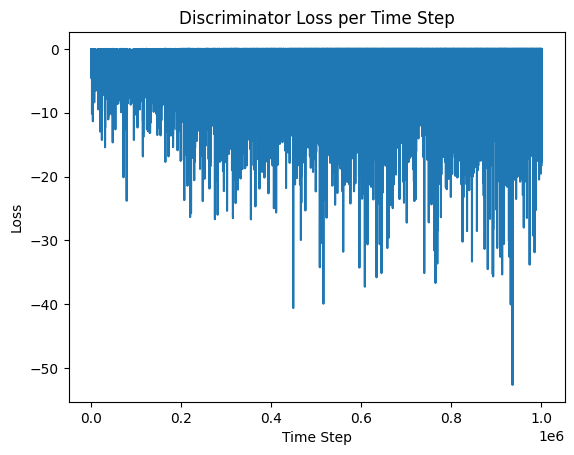

In [4]:
import matplotlib.pyplot as plt

plt.plot(all_loss)
plt.xlabel('Time Step')
plt.ylabel('Loss')
plt.title('Discriminator Loss per Time Step')
plt.show()

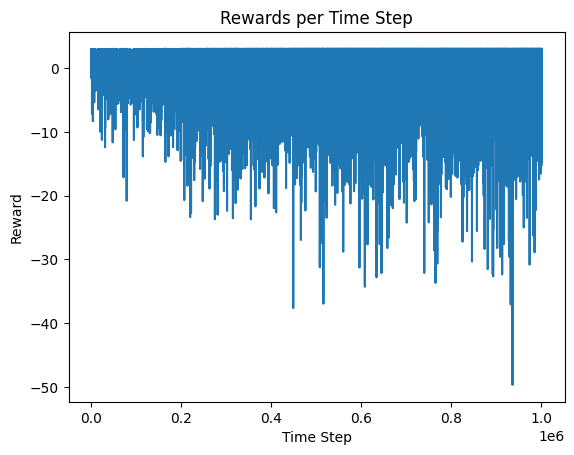

In [5]:
import matplotlib.pyplot as plt

plt.plot(all_rewards)
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Rewards per Time Step')
plt.show()

In [8]:
# Visualize model running

model = PPO.load("diayn_ppo_cheetah_big3")
env = gym.make("HalfCheetah-v4", render_mode="human")
env = CustomEnvWrapper(env)

obs, _ = env.reset()
print(env.cur_skill())
# env.skill = env.skill_dist.sample() # Replace <desired_skill> with the skill you want to use
rewards_all = []
for i in range(10000):
    if (i % 1000 == 0):
        obs, _ = env.reset()
    action, _states = model.predict(obs)
    obs, rewards, dones, info, _ = env.step(action)
    rewards_all.append(rewards)
    # env.render()

    if dones:
        break  

16


KeyboardInterrupt: 

In [13]:
# Record trajectories
num_eval_episodes = NUM_SKILLS

model = PPO.load("diayn_ppo_cheetah_big3")

env = gym.make("HalfCheetah-v4", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="cheetah-diayn-big3-embed", name_prefix="eval",
                  episode_trigger=lambda x: True)
# env = RecordEpisodeStatistics(env)
env = CustomEnvWrapper(env)

for episode_num in range(env.skill_dist.num_skills):
    obs, info = env.reset()
    env.skill = torch.tensor(episode_num)
    print(env.set_skill(episode_num))

    episode_over = False
    while not episode_over:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-0.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-0.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-1.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-1.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-2.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-2.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-3.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-3.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-4.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-4.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-5.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-5.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-6.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-6.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-7.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-7.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-8.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-8.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-9.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-9.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-10.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-10.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-11.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-11.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-12.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-12.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-13.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-13.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-14.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-14.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-15.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-15.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-16.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-16.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-17.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-17.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-18.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-18.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-19.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-19.mp4


/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.time_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.time_queue` for environment variables or `env.get_wrapper_attr('time_queue')` that will search the reminding wrappers.
  logger.warn(


AttributeError: 'HalfCheetahEnv' object has no attribute 'time_queue'

In [53]:
# Graph trajectories

model = PPO.load("diayn_ppo_cheetah_big3")

env = gym.make("HalfCheetah-v4", exclude_current_positions_from_observation=False) 
env = CustomEnvWrapper(env)

num_eval_episodes = 100

trajectories_x = []
trajectories_z = []

all_obs = []

skills = []

"""
I was being STUPID asf here
was cutting off the skill here but not the position
"""

for skill in tqdm(range(NUM_SKILLS)):
    for episode_num in range(num_eval_episodes):
        trajectory_x = []
        trajectory_z = []
        obs_ = []
        obs, info = env.reset()
        env.skill_i = torch.tensor(skill)
        env.skill = env.skill_dist.embed(env.skill_i)

        # trajectory_x.append(obs[:-1])
        # trajectory_z.append(obs[0])
        # append without the skill embedding
        obs_.append(obs[:-10])
        # get rid of embedding dimensions
        obs = np.delete(obs, -11)
        skills.append(env.cur_skill())

        # print(env.cur_skill())

        episode_over = False
        while not episode_over:
            action, _states = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)

            # trajectory_x.append(obs[:-1])
            # trajectory_z.append(obs[0])
            obs_.append(obs[:-10])
            obs = np.delete(obs, -11)

            episode_over = terminated or truncated

        # trajectories_x.append(trajectory_x)
        # trajectories_z.append(trajectory_z)
        all_obs.append(obs_)
    
env.close()

100%|██████████| 20/20 [21:35<00:00, 64.77s/it]


In [54]:
import numpy as np

mean_list = []
variance_list = []

for skill in range(NUM_SKILLS):
    skill_obs = []
    for j in range(num_eval_episodes):
        skill_obs += all_obs[skill * num_eval_episodes + j]

    skill_obs = np.array(skill_obs)
    skill_mean = np.mean(skill_obs, axis=0)
    skill_var = np.var(skill_obs, axis=0)

    mean_list.append(skill_mean)
    variance_list.append(skill_var)

mean_list = np.array(mean_list)
variance_list = np.array(variance_list)

[7.26428283e-02 2.35977421e-05 3.98971316e-02 1.15286620e-06
 2.32352392e-06 2.35530181e-06 6.32469180e-06 1.66798989e-06
 1.29195921e-06 6.03392354e-05 2.17638733e-06 3.83088351e-05
 9.75353052e-06 1.17860832e-05 1.92852010e-05 3.19726574e-05
 1.15252571e-05 2.28312527e-05]


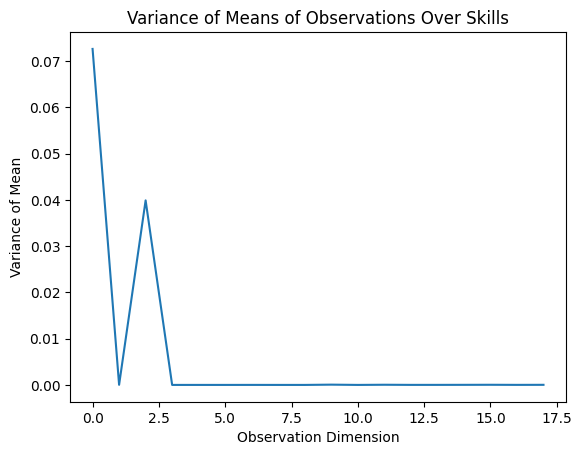

In [55]:
mean_list_ = np.var(mean_list, axis=0)
print(mean_list_)
plt.xlabel('Observation Dimension')
plt.ylabel('Variance of Mean')
plt.title('Variance of Means of Observations Over Skills')
plt.plot(mean_list_)

[2.34515675e+00 2.08470263e-06 6.93343662e-01 3.15875413e-07
 1.63214837e-07 1.29041492e-07 1.61051279e-06 6.06782910e-07
 1.97913518e-07 1.17579240e-04 1.03838940e-04 1.32545116e-03
 1.51680520e-01 1.74539695e-01 1.75122441e-01 1.76943908e-01
 2.47890555e-01 7.35669454e-02]


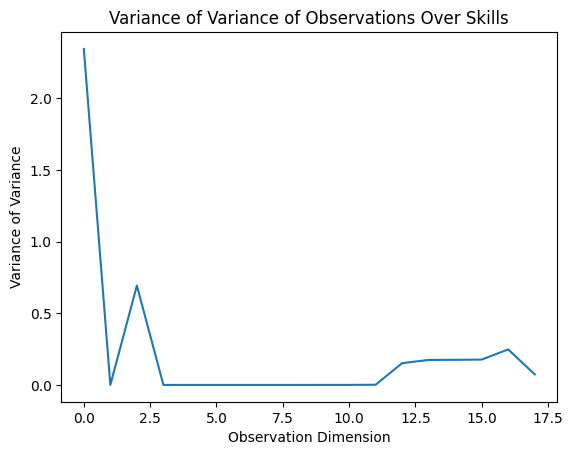

In [56]:
variance_list_ = np.var(variance_list, axis=0)
print(variance_list_)
plt.xlabel('Observation Dimension')
plt.ylabel('Variance of Variance')
plt.title('Variance of Variance of Observations Over Skills')
plt.plot(variance_list_)

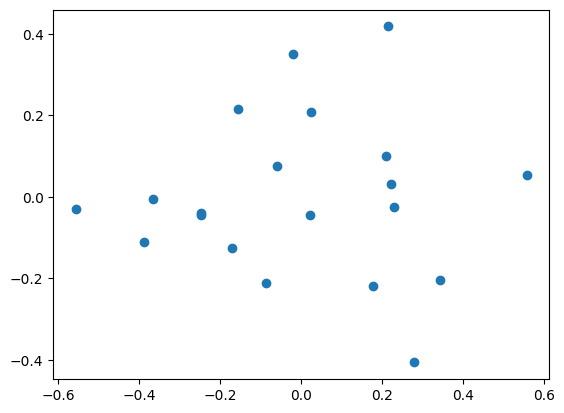

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out = pca.fit_transform(mean_list)
plt.scatter(out[:, 0], out[:, 1])
plt.show()

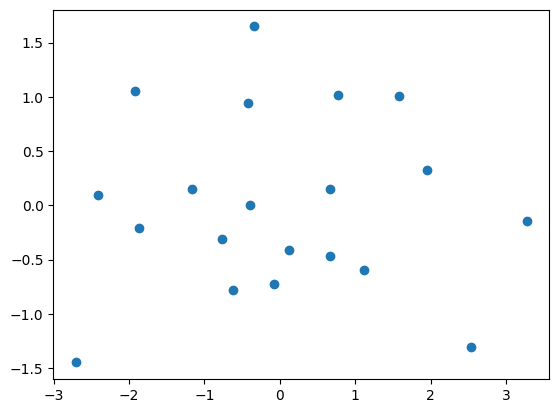

In [58]:
ca = PCA(n_components=2)
out = pca.fit_transform(variance_list)
plt.scatter(out[:, 0], out[:, 1])
plt.show()

In [29]:
import numpy as np

mean_list = []
variance_list = []

for skill in range(NUM_SKILLS):
    skill_obs = []
    for j in range(num_eval_episodes):
        skill_obs += all_obs[skill * num_eval_episodes + j]

    skill_obs = np.array(skill_obs)
    

mean_list = np.array(mean_list)
variance_list = np.array(variance_list)

20 100 2000


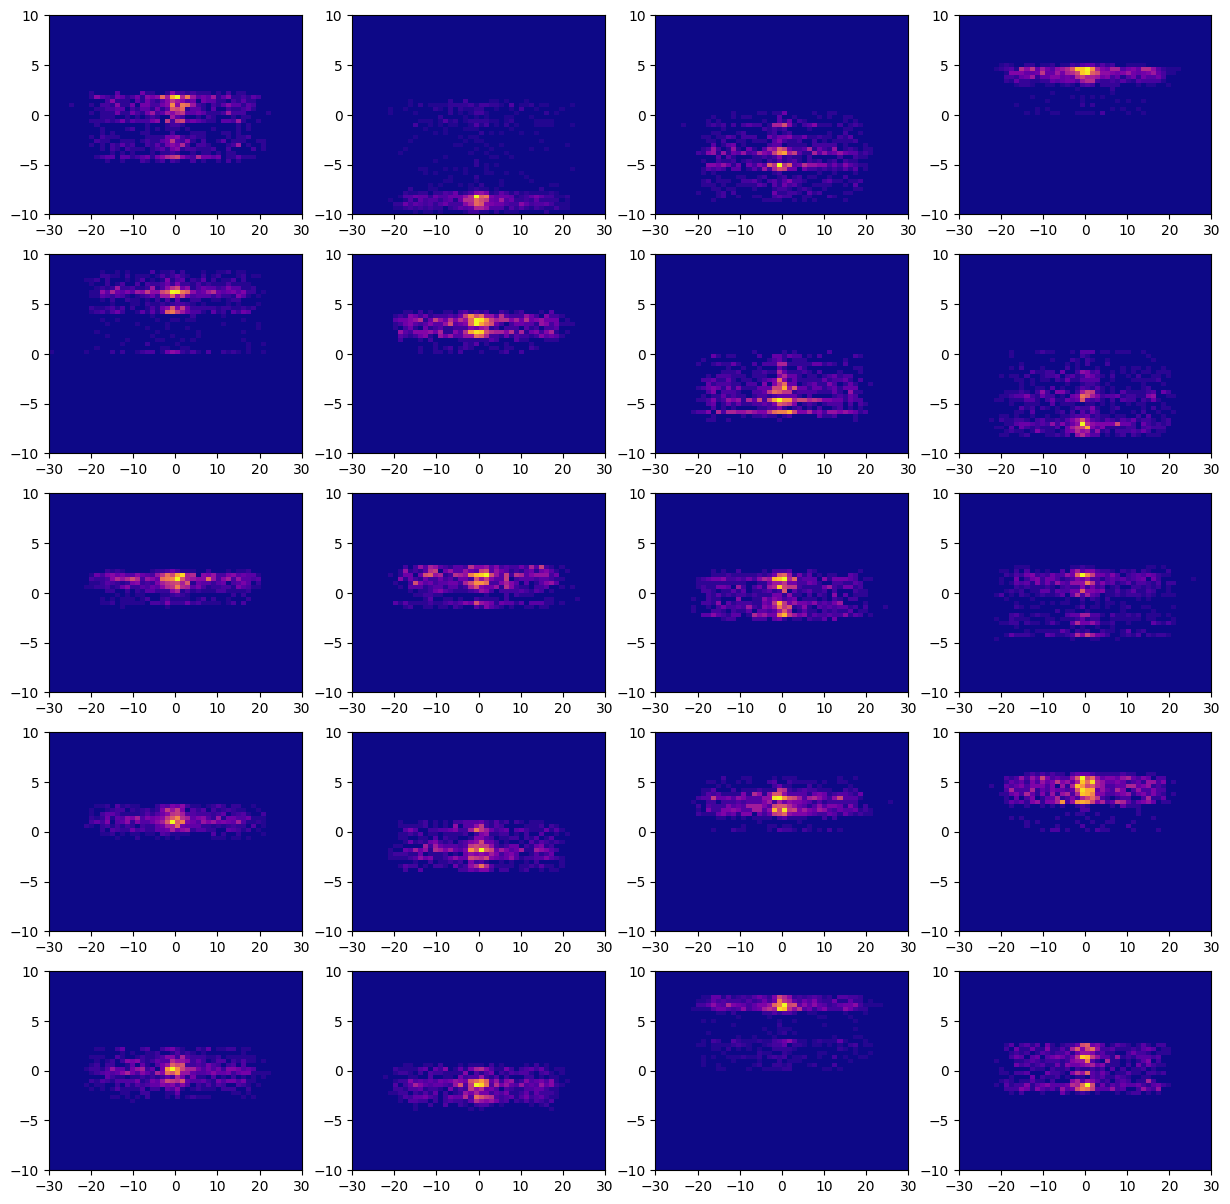

In [59]:
# z = [e[0].item() for e in obs_ for obs_ in all_obs]
# x = [e[-1].item() for e in obs_ for obs_ in all_obs

import math 

grid_size = int(np.ceil(np.sqrt(NUM_SKILLS)))

fig, axs = plt.subplots(5, 4, figsize=(15, 15))

j = 0
# for i in range(sk)

print(NUM_SKILLS, num_eval_episodes, len(all_obs))

for i in range(NUM_SKILLS):
    ax = axs[i // 4, i % 4]
    ax.set_xlim(-30, 30)
    ax.set_ylim(-10, 10)
    for j in range(num_eval_episodes):
        z = [e[0].item() for e in all_obs[i * num_eval_episodes + j]]
        x = [e[-1].item() for e in all_obs[i * num_eval_episodes + j]]
        edges0 = np.linspace(-30, 30, 51)
        edges1 = np.linspace(-10, 10, 51)
        bins = np.array([edges0, edges1])
        ax.hist2d(x, z, bins=bins, cmap='plasma', cmin=-30, cmax=30)

plt.show()

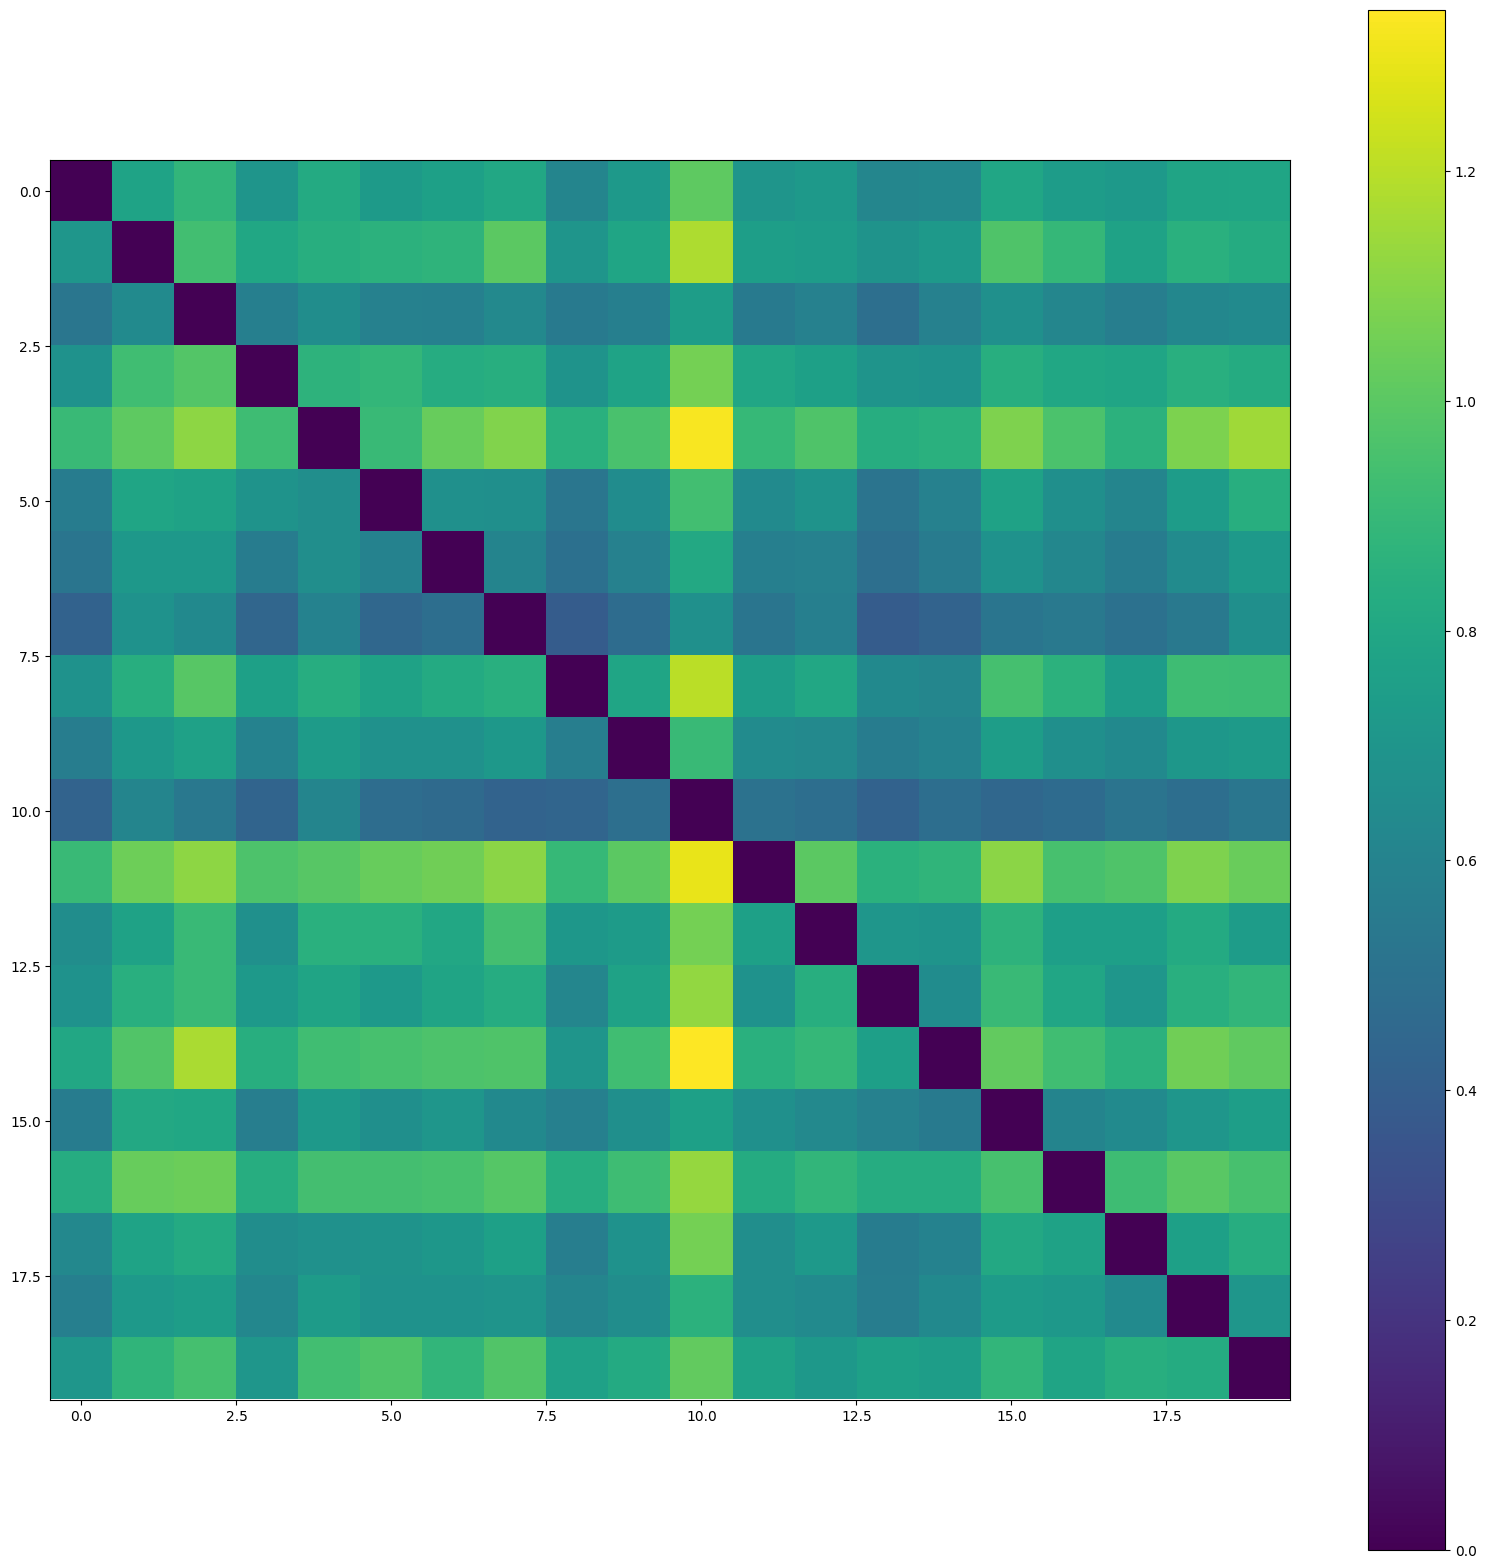

In [63]:
# fig, axs = plt.subplots(20,, figsize=(15, 15))

j = 0
# for i in range(sk)

# print(NUM_SKILLS, num_eval_episodes, len(all_obs))

fig, ax = plt.subplots(figsize=(20, 20))

kl_mat = np.zeros((NUM_SKILLS, NUM_SKILLS))

for i in range(NUM_SKILLS):
    zi = []
    xi = []
    for k in range(num_eval_episodes):
        zi += [e[0].item() for e in all_obs[i * num_eval_episodes + k]]
        xi += [e[-1].item() for e in all_obs[i * num_eval_episodes + k]]
    for j in range(NUM_SKILLS):
        z = []
        x = []
        for k in range(num_eval_episodes):
            z += [e[0].item() for e in all_obs[j * num_eval_episodes + k]]
            x += [e[-1].item() for e in all_obs[j * num_eval_episodes + k]]

        bin_edges_z = np.histogram_bin_edges(np.concatenate((z, zi)), bins='auto')
        bin_edges_x = np.histogram_bin_edges(np.concatenate((x, xi)), bins='auto')

        j_hist, _, _ = np.histogram2d(x, z, bins=[bin_edges_x, bin_edges_z], density=True)
        i_hist, _, _ = np.histogram2d(xi, zi, bins=[bin_edges_x, bin_edges_z], density=True)

        epsilon = 1e-10
        j_hist += epsilon
        i_hist += epsilon

        j_prob = j_hist / np.sum(j_hist)
        i_prob = i_hist / np.sum(i_hist)

        kl = np.sum(i_prob * np.log(i_prob / j_prob))

        kl_mat[i, j] = kl

cax = ax.imshow(kl_mat)
fig.colorbar(cax, ax=ax)

# for i in range(NUM_SKILLS):
#     for j in range(NUM_SKILLS):
#         text = ax.text(j, i, kl_mat[i, j], ha="center", va="center", color="w")

plt.show()